In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import colorsys
import scipy.stats as st
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
# %matplotlib inline
import pickle as pk
import seaborn as sns

In [2]:
import difflib

def get_overlap(s1, s2):
    s = difflib.SequenceMatcher(None, s1, s2)
    pos_a, pos_b, size = s.find_longest_match(0, len(s1), 0, len(s2)) 
    return s1[pos_a:pos_a+size]

In [3]:
def mean_list(list1):
    if len(list1)>0:
        sum_list=sum(list1)
        len_list=len(list1)
        mean=sum_list/len_list
    else:
        mean=0
    return mean

In [4]:
def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

In [44]:
from fuzzywuzzy import fuzz

# Preprocess the strings to improve matching accuracy
def preprocess_string(s):
    stopwords = {'in', 'of', 'and', 'on', 'for', 'with'}
    return ' '.join(word for word in s.lower().split() if word not in stopwords)

# Improved overlap function using fuzz for more flexible matching
def get_similarity_score(s1, s2):
    return fuzz.token_sort_ratio(s1, s2)  # Token sort ratio is useful for out-of-order terms


In [6]:
#Let's import the diseases 
with open('output/exp_random/real_significant_final_exp_proximity.pickle', 'rb') as handle:
    real_significant_final_exp_proximity = pk.load(handle)

In [7]:
#Import PPI
ppi = pd.read_csv("input/PPI/autocore_symbol_lcc.csv",delimiter= ',',    #import the PPI
           skipinitialspace=True)

G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')

G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

#Loading the disease-gene associations from Disegenet
gene_associations = pd.read_csv("input/Disease/all_gene_disease_associations.tsv",   
           delimiter= '\t',
           skipinitialspace=True)

gene_associations_filtered=gene_associations[gene_associations['score']>0.4]   #using a filtering score==4

diseases_genes_associated = {}     #creating a dictionary
for i,v in gene_associations_filtered.iterrows():
    try:
        diseases_genes_associated[v["diseaseName"]].append(v["geneSymbol"])
    except KeyError:
        diseases_genes_associated[v["diseaseName"]] = [v["geneSymbol"]]

diseases_genes_associated_ppi={}       #cleaning for those associations that have an encoded perturbation on the PPI
for k,v in diseases_genes_associated.items():
    gene_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            gene_list.append(gene)
        else:
            pass
    if len(gene_list)>0:
        diseases_genes_associated_ppi[k]=gene_list
    else:
        pass

18815
482935


In [53]:
#Let's import the no-statistically significant associations
with open('intermediate/exp_proximity_not_significant.pickle', 'rb') as handle:
    exp_proximity_not_significant = pk.load(handle)

### Air

In [8]:
#Let's import the WHO data at a national level
who_air_nation=pd.read_excel("input/WHO/F1_1_Total Releases at National Level into Air.xlsx",sheet_name=0)

In [9]:
#Let's import the CTD dataset
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', #import the database
            skipinitialspace=True)

chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')] #select only for human species


In [10]:
#Let's define a dictionary that will convert the chemical id in chemical Name
chem_id_name_conversion = {}
for i,v in chem_homo.iterrows():
    chem_id_name_conversion[v["ChemicalID"]] = v["# ChemicalName"]

chem_id_name_conversion_inv={}
for k,v in chem_id_name_conversion.items():
    chem_id_name_conversion_inv[v]=k

In [15]:
exp_set=set(who_air_nation['pollutant'])
chem_names=chem_id_name_conversion_inv.keys()
ctd_explist=[]
for exp in exp_set:
    try:
        ctd_explist.append(chem_id_name_conversion_inv[exp])
    except:
        for cc in chem_names:
            if exp.lower()==cc.lower():
                ctd_explist.append(chem_id_name_conversion_inv[cc])
            else:
                if exp=='Naphthalene':
                    ctd_explist.append(chem_id_name_conversion_inv['Naphthalenes'])
                elif exp=='Vinyl chloride':
                    ctd_explist.append(chem_id_name_conversion_inv['Polyvinyl Chloride'])
                elif exp=='Anthracene':
                    ctd_explist.append(chem_id_name_conversion_inv['Anthracenes'])


In [16]:
#Let's create a dictionary of conversion manually curated from CTD on the 12.02.2024
air_chem_name_conversion_dict = {}

air_chem_name_conversion_dict['1,1,1-trichloroethane (TCE-1,1,1)'] = 'C024566'
air_chem_name_conversion_dict['Hexachlorocyclohexane'] = 'D001556'
air_chem_name_conversion_dict['1,2-dichloroethane (DCE-1,2)'] = 'C024565'
air_chem_name_conversion_dict['Aldrin'] = 'D000452'
air_chem_name_conversion_dict['Ammonia (NH3)'] = 'D000641'
air_chem_name_conversion_dict['Anthracene'] = 'C034020'
air_chem_name_conversion_dict['Arsenic and compounds (as As)'] = 'D001151'
air_chem_name_conversion_dict['Asbestos'] = 'D001194'
air_chem_name_conversion_dict['Benzene'] = 'D001554'
air_chem_name_conversion_dict['Benzo(g,h,i)perylene'] = 'C006718'
air_chem_name_conversion_dict['Brominated diphenylethers (PBDE)'] = 'C477694'
air_chem_name_conversion_dict['Cadmium and compounds (as Cd)'] = 'D002104'
air_chem_name_conversion_dict['Carbon dioxide (CO2)'] = 'D002245'
air_chem_name_conversion_dict['Carbon monoxide (CO)'] = 'D002248'
air_chem_name_conversion_dict['Chlordecone'] = 'D007631'
air_chem_name_conversion_dict['Chlorine and inorganic compounds (as HCl)'] = 'D002713'
air_chem_name_conversion_dict['Chlorofluorocarbons (CFCs)'] = 'D017402'
air_chem_name_conversion_dict['Chromium and compounds (as Cr)'] = 'D002857'
air_chem_name_conversion_dict['Copper and compounds (as Cu)'] = 'D003300'
air_chem_name_conversion_dict['Di-(2-ethyl hexyl) phthalate (DEHP)'] = 'D004051'
air_chem_name_conversion_dict['Dichloromethane (DCM)'] = 'D008752'
air_chem_name_conversion_dict['Ethyl benzene'] = 'C004912'
air_chem_name_conversion_dict['Ethylene oxide'] = 'D005027'
air_chem_name_conversion_dict['Fine particulate matter (PM2.5)'] = 'D052638'
air_chem_name_conversion_dict['Fluorides (as total F)'] = 'D005459'
air_chem_name_conversion_dict['Fluorine and inorganic compounds (as HF)'] = 'D005461'
air_chem_name_conversion_dict['Hexachlorobenzene (HCB)'] = 'D006581'
air_chem_name_conversion_dict['Hydro-fluorocarbons (HFCS)'] = 'D005466'
air_chem_name_conversion_dict['Hydrogen cyanide (HCN)'] = 'D006856'
air_chem_name_conversion_dict['Lead and compounds (as Pb)'] = 'D007854'
air_chem_name_conversion_dict['Mercury and compounds (as Hg)'] = 'D008628'
air_chem_name_conversion_dict['Methane (CH4)'] = 'D008697'
air_chem_name_conversion_dict['Naphthalene'] = 'C031721'
air_chem_name_conversion_dict['Nickel and compounds (as Ni)'] = 'D009532'
air_chem_name_conversion_dict['Nitrogen oxides (NOX)'] = 'D009589'
air_chem_name_conversion_dict['Nitrous oxide (N2O)'] = 'D009609'
air_chem_name_conversion_dict['Non-methane volatile organic compounds (NMVOC)'] = 'D055549'
air_chem_name_conversion_dict['Nonylphenol and Nonylphenol ethoxylates'] = 'C025256'
air_chem_name_conversion_dict['Dioxins and Dioxin-like Compounds'] = 'D005663'
air_chem_name_conversion_dict['Furans'] = 'D000072316'
air_chem_name_conversion_dict['Dioxins' ]= 'D004147'
air_chem_name_conversion_dict['Particulate matter (PM10)'] = 'D052638'
air_chem_name_conversion_dict['Pentachlorobenzene'] = 'C003060'
air_chem_name_conversion_dict['Pentachlorophenol (PCP)'] = 'D010416'
air_chem_name_conversion_dict['Perfluorocarbons (PFCs)'] = 'D005466'
air_chem_name_conversion_dict['Phenols (as total C)'] = 'D010636'
air_chem_name_conversion_dict['Polychlorinated biphenyls (PCBs)' ]= 'D011078'
air_chem_name_conversion_dict['Polycyclic aromatic hydrocarbons (PAHs)'] = 'D011084'
air_chem_name_conversion_dict['Sulphur oxides (SOX)'] = 'D013458'
air_chem_name_conversion_dict['Tetrachloroethylene'] = 'D013750'
air_chem_name_conversion_dict['Toluene'] = 'D014050'
air_chem_name_conversion_dict['Trichloroethylene (TRI)'] = 'D014241'
air_chem_name_conversion_dict['Trichloromethane'] = 'D002725'
air_chem_name_conversion_dict['Vinyl chloride'] = 'D014752'
air_chem_name_conversion_dict['Xylenes'] = 'D014992'
air_chem_name_conversion_dict['Zinc and compounds (as Zn)'] = 'D015032'

In [17]:
country_set=set(who_air_nation['countryName'].tolist())
years=list(range(2007,2020))
country_chem_conc={}
for c in country_set:
    chem_concentration_dict={}
    for i,v in who_air_nation[who_air_nation['countryName']==c].iterrows():
        concentration=[]
        for y in years:
            concentration.append(v[y])
        concentration_clenaed=[x for x in concentration if str(x) != 'nan']
        chem_concentration_dict[v['pollutant']]=concentration_clenaed
    country_chem_conc[c]=chem_concentration_dict
 

In [18]:
country_chem_conc_mean_dict={}
for c,chem_con in country_chem_conc.items():
    chem_mean_dict={}
    for chem,con_list in chem_con.items():
        chem_mean_dict[chem]=mean_list(con_list)
    country_chem_conc_mean_dict[c]=chem_mean_dict

In [19]:
chem_set=set(who_air_nation['pollutant'].tolist())

chem_across_countries_dict={}
for chem in chem_set:
    chem_median_across_countries_list=[]
    for c in country_set:
        try:
            chem_median_across_countries_list.append(country_chem_conc_mean_dict[c][chem])
        except:
            pass
    chem_across_countries_dict[chem]=chem_median_across_countries_list

In [20]:
#If a chemical compound is express only in less than 4 countries then is considered as specific for that country. 
#Otherwise the concentration in that country should be > 75* percentile of the average concentration distribution across all countries
import statistics

country_selected_chem_dict={}

for country, chem_avgcon_dict in country_chem_conc_mean_dict.items():
    chem_list=[]
    for chem, avg_con_list in chem_across_countries_dict.items():
        if chem in chem_avgcon_dict.keys():
            if len(avg_con_list)>4:
                cutoff=np.percentile(avg_con_list,75)
                if chem_avgcon_dict[chem]>cutoff:
                    chem_list.append(chem)
            else:
                chem_list.append(chem)
    country_selected_chem_dict[country]=chem_list


low_country_selected_chem_dict={}

for country, chem_avgcon_dict in country_chem_conc_mean_dict.items():
    chem_list=[]
    for chem, avg_con_list in chem_across_countries_dict.items():
        if chem in chem_avgcon_dict.keys():
            if len(avg_con_list)>4:
                cutoff=np.percentile(avg_con_list,50)
                if chem_avgcon_dict[chem]>cutoff:
                    chem_list.append(chem)
            else:
                chem_list.append(chem)
    low_country_selected_chem_dict[country]=chem_list

high_country_selected_chem_dict={}

for country, chem_avgcon_dict in country_chem_conc_mean_dict.items():
    chem_list=[]
    for chem, avg_con_list in chem_across_countries_dict.items():
        if chem in chem_avgcon_dict.keys():
            if len(avg_con_list)>4:
                cutoff=np.percentile(avg_con_list,95)
                if chem_avgcon_dict[chem]>cutoff:
                    chem_list.append(chem)
            else:
                chem_list.append(chem)
    high_country_selected_chem_dict[country]=chem_list

In [21]:
chem_id_list = list(chem_id_name_conversion.keys())


country_selected_chem_id_dict={}
for country,chem_list in country_selected_chem_dict.items():
    id_chem_list=[]
    for chem in chem_list:
        try:
            if chem!='PCDD + PCDF (dioxins + furans) (as Teq)':   
                if air_chem_name_conversion_dict[chem] in chem_id_list:
                    id_chem_list.append(air_chem_name_conversion_dict[chem])
            else:
                if 'D005663' in chem_id_list:
                    id_chem_list.append('D005663')
                if 'D000072316' in chem_id_list:
                    id_chem_list.append('D000072316')
                if 'D004147' in chem_id_list:
                    id_chem_list.append('D004147')
        except:
            pass
    country_selected_chem_id_dict[country]=set(id_chem_list)

low_country_selected_chem_id_dict={}
for country,chem_list in low_country_selected_chem_dict.items():
    id_chem_list=[]
    for chem in chem_list:
        try:
            if chem!='PCDD + PCDF (dioxins + furans) (as Teq)':   
                if air_chem_name_conversion_dict[chem] in chem_id_list:
                    id_chem_list.append(air_chem_name_conversion_dict[chem])
            else:
                if 'D005663' in chem_id_list:
                    id_chem_list.append('D005663')
                if 'D000072316' in chem_id_list:
                    id_chem_list.append('D000072316')
                if 'D004147' in chem_id_list:
                    id_chem_list.append('D004147')
        except:
            pass
    low_country_selected_chem_id_dict[country]=set(id_chem_list)


high_country_selected_chem_id_dict={}
for country,chem_list in high_country_selected_chem_dict.items():
    id_chem_list=[]
    for chem in chem_list:
        try:
            if chem!='PCDD + PCDF (dioxins + furans) (as Teq)':   
                if air_chem_name_conversion_dict[chem] in chem_id_list:
                    id_chem_list.append(air_chem_name_conversion_dict[chem])
            else:
                if 'D005663' in chem_id_list:
                    id_chem_list.append('D005663')
                if 'D000072316' in chem_id_list:
                    id_chem_list.append('D000072316')
                if 'D004147' in chem_id_list:
                    id_chem_list.append('D004147')
        except:
            pass
    high_country_selected_chem_id_dict[country]=set(id_chem_list)


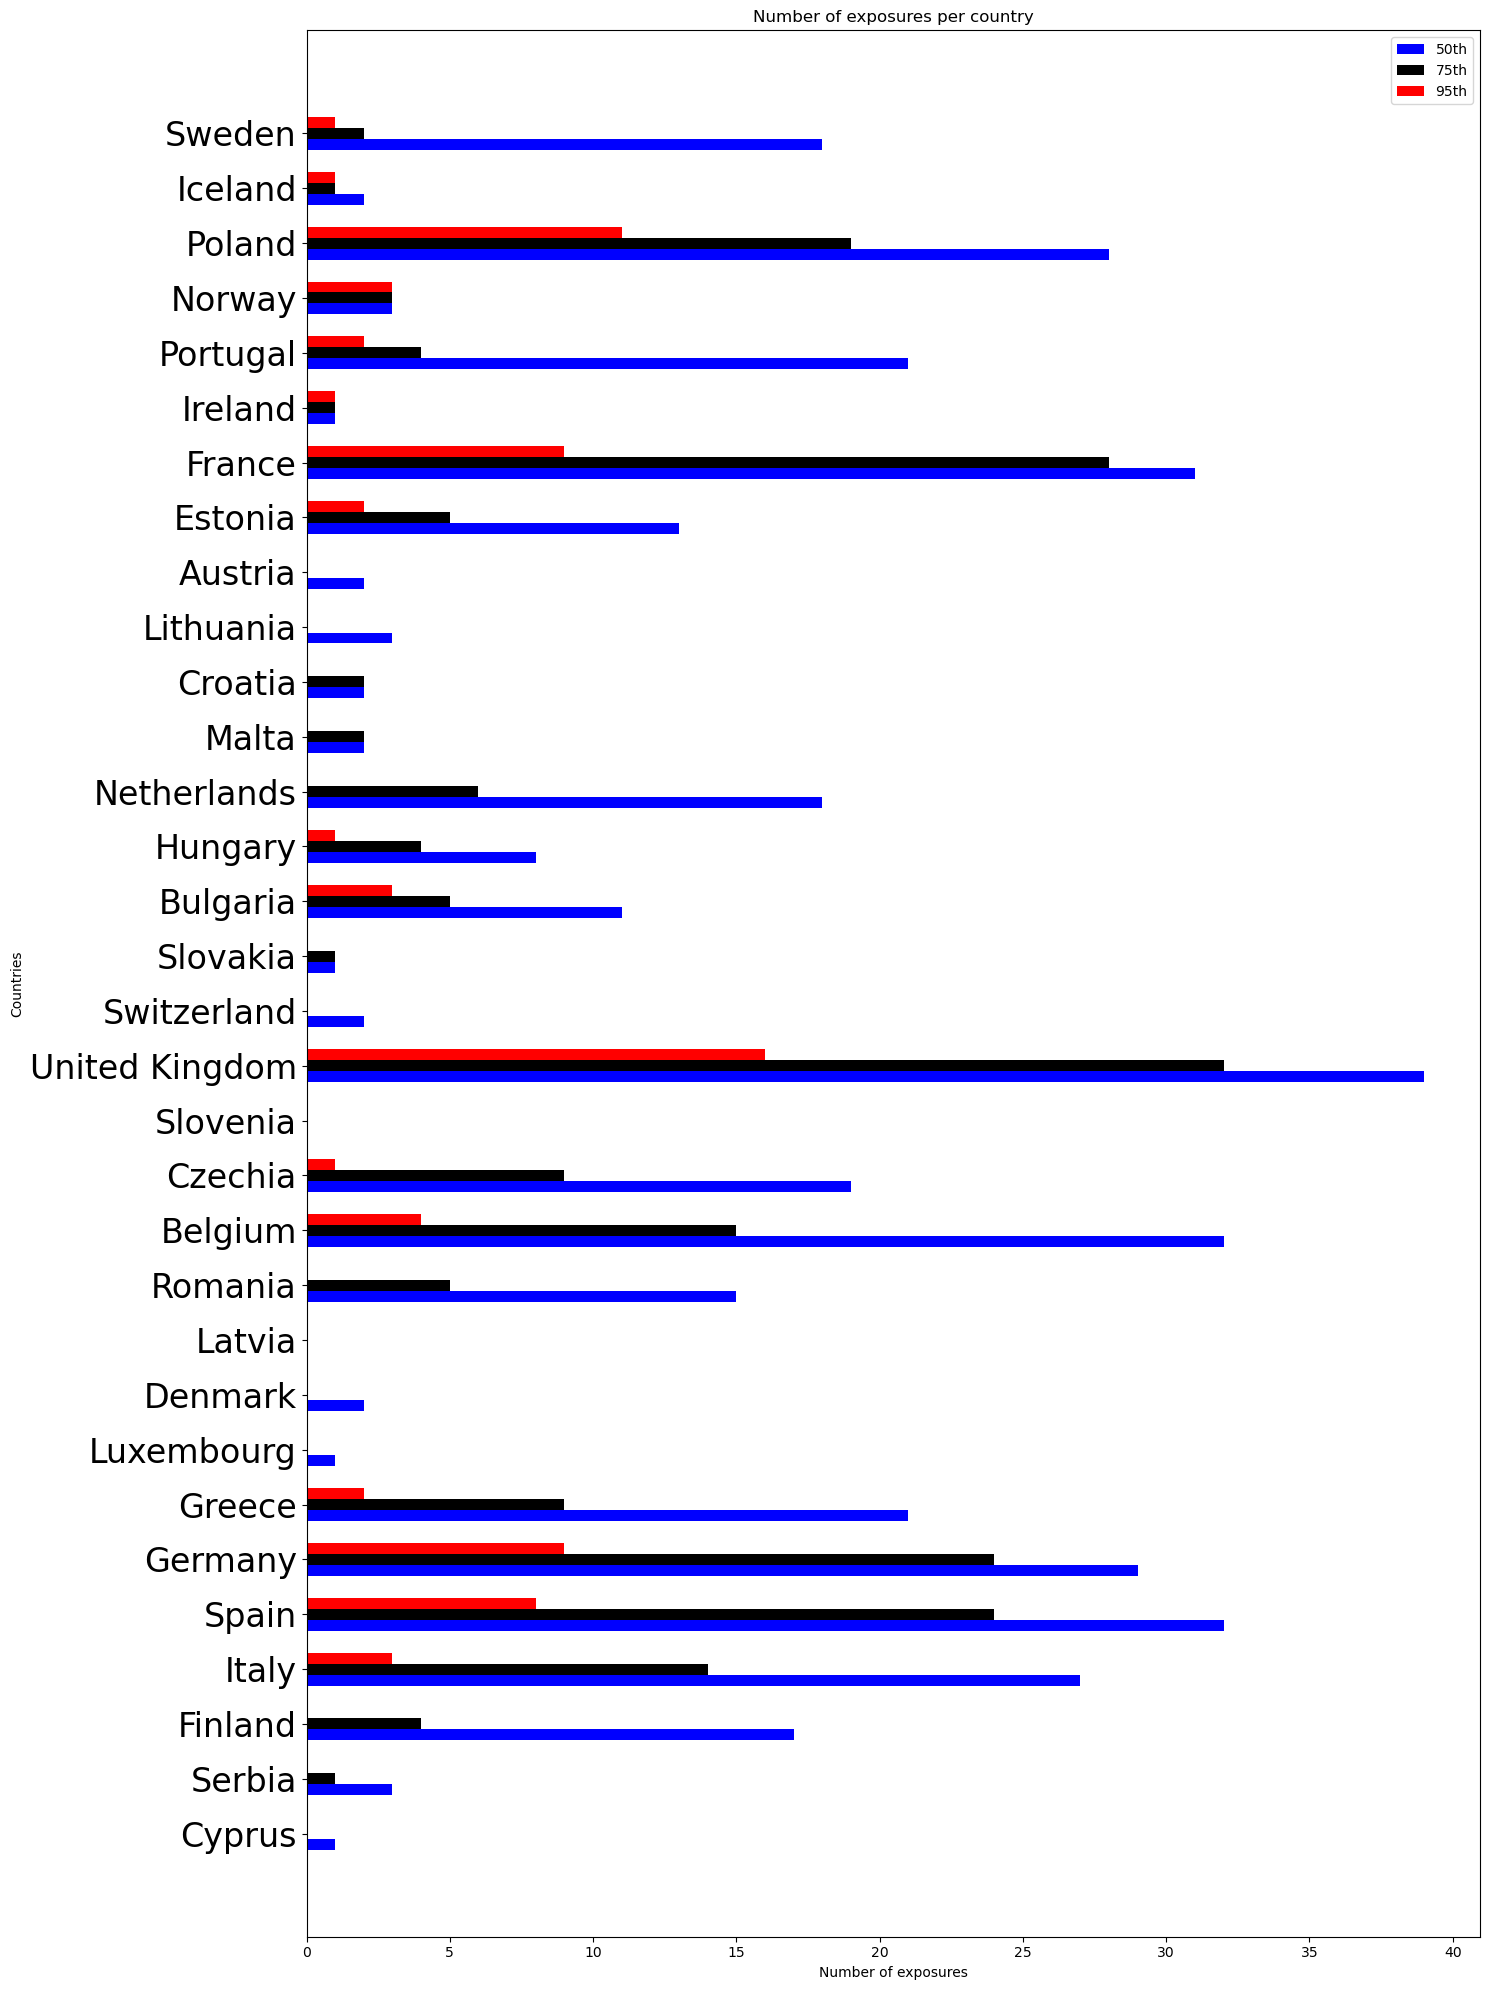

In [22]:


low_country_selected_chem_num_dict = {}
for country, chemlist in low_country_selected_chem_id_dict.items():
    low_country_selected_chem_num_dict[country] = len(chemlist)

country_selected_chem_num_dict = {}
for country, chemlist in country_selected_chem_id_dict.items():
    country_selected_chem_num_dict[country] = len(chemlist)

high_country_selected_chem_num_dict = {}
for country, chemlist in high_country_selected_chem_id_dict.items():
    high_country_selected_chem_num_dict[country] = len(chemlist)
    
# Get the list of countries (keys)
countries = list(country_selected_chem_num_dict.keys())

# Extract values from each dictionary
values_a = [low_country_selected_chem_num_dict[country] for country in countries]
values_b = [country_selected_chem_num_dict[country] for country in countries]
values_c = [high_country_selected_chem_num_dict[country] for country in countries]

# Define the position of bars on the x-axis
x = np.arange(len(countries))

# Width of a bar
width = 0.2

fig, ax = plt.subplots(figsize=(15, 20))

# Plotting the bars
rects1 = ax.barh(x - width, values_a, width, color='blue', label='50th')
rects2 = ax.barh(x, values_b, width, color='black', label='75th')
rects3 = ax.barh(x + width, values_c, width, color='red', label='95th')

# Adding labels, title, and customizing axes
ax.set_xlabel('Number of exposures')
ax.set_ylabel('Countries')
ax.set_title('Number of exposures per country')
ax.set_yticks(x)
ax.set_yticklabels(countries,fontsize=24)
ax.legend()

# Show the plot
plt.tight_layout()
#plt.savefig('output/Figures/SF8D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:

# Ensure same country order as plot
countries = list(country_selected_chem_num_dict.keys())

rows = []

for idx, country in enumerate(countries):
    rows.append({
        "Country": country,
        "Position_index": idx,
        "50th_percentile_count": low_country_selected_chem_num_dict.get(country, 0),
        "75th_percentile_count": country_selected_chem_num_dict.get(country, 0),
        "95th_percentile_count": high_country_selected_chem_num_dict.get(country, 0)
    })

df_barplot = pd.DataFrame(rows)

print("Total countries:", len(df_barplot))

# ----------------------------
# Save to Excel (single sheet)
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_barplot.to_excel(
        writer,
        sheet_name="SF15D",
        index=False
    )


In [24]:
low_country_selected_chem_num_dict = {}
for country, chemlist in low_country_selected_chem_id_dict.items():
    low_country_selected_chem_num_dict[country] = len(chemlist)

country_selected_chem_num_dict = {}
for country, chemlist in country_selected_chem_id_dict.items():
    country_selected_chem_num_dict[country] = len(chemlist)

high_country_selected_chem_num_dict = {}
for country, chemlist in high_country_selected_chem_id_dict.items():
    high_country_selected_chem_num_dict[country] = len(chemlist)

In [ ]:
print(np.mean(list(low_country_selected_chem_num_dict.values())))
print(np.mean(list(country_selected_chem_num_dict.values())))
print(np.mean(list(high_country_selected_chem_num_dict.values())))

In [25]:
jaccard_country_selected_chem_dict = {}

for country1,chemlist1 in country_selected_chem_id_dict.items():
    for country2,chemlist2 in country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            jaccard_country_selected_chem_dict[country1,country2] = overlap_jaccard(chemlist1,chemlist2)
        else:
            jaccard_country_selected_chem_dict[country1,country2] = 0

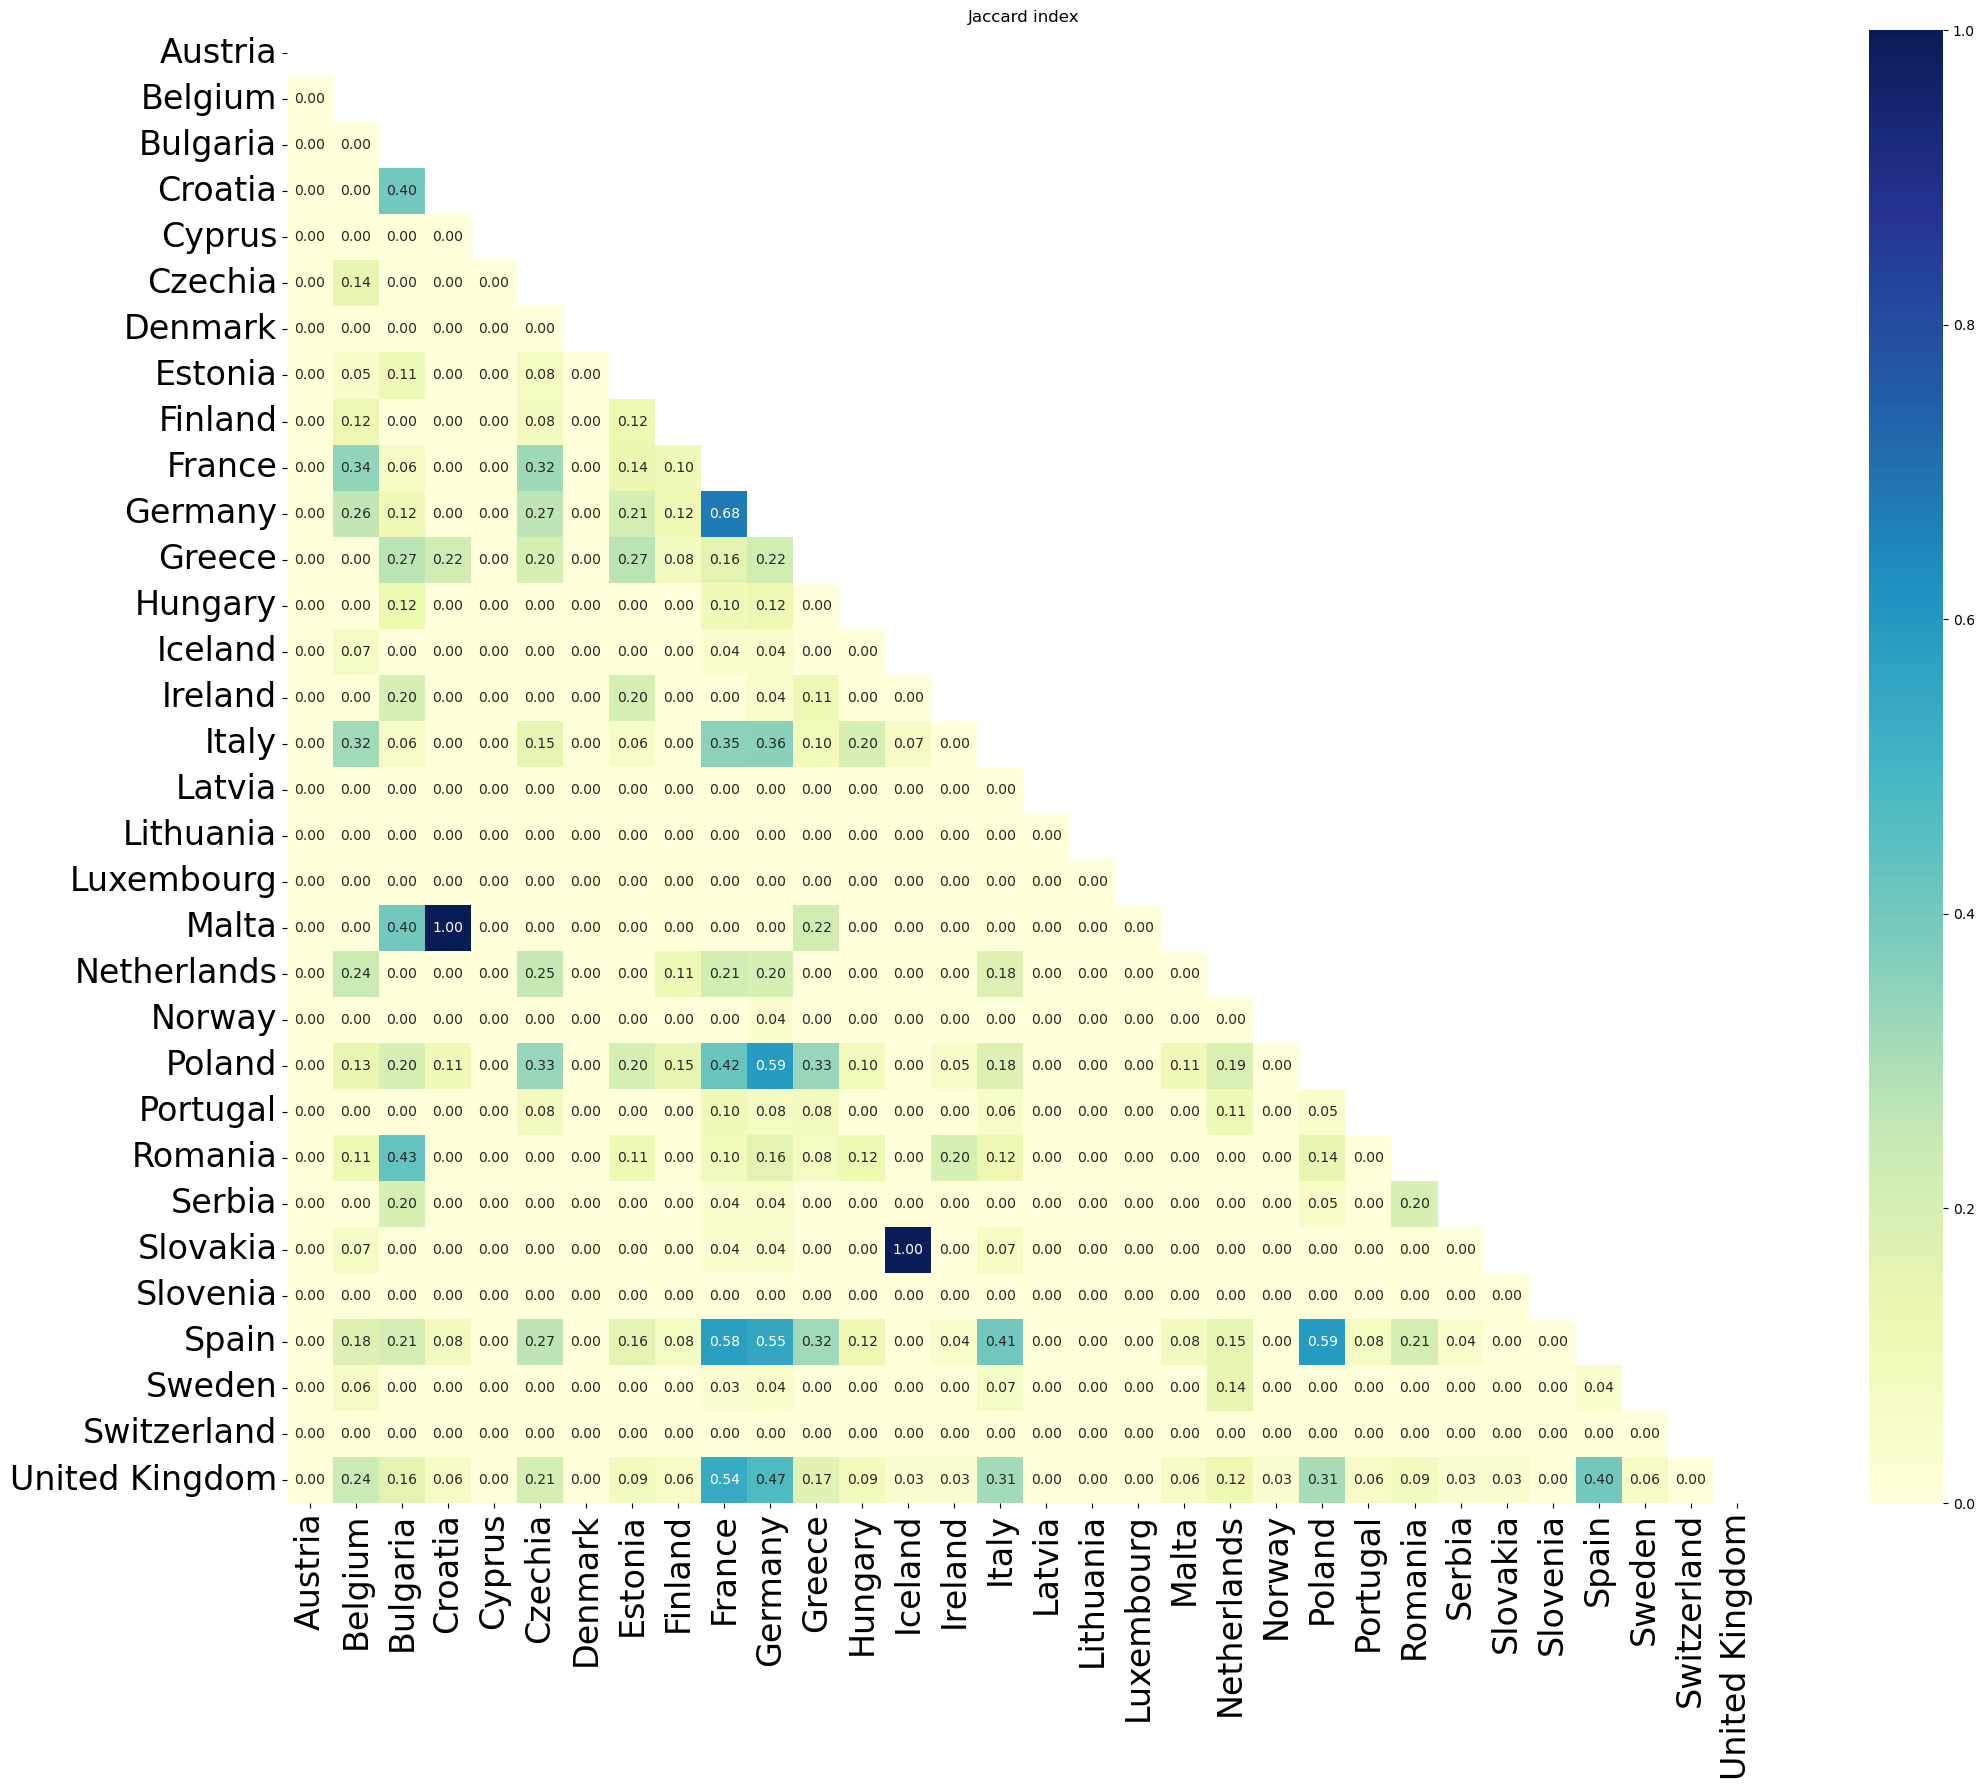

In [26]:

ser = pd.Series(list(jaccard_country_selected_chem_dict.values()),
                index=pd.MultiIndex.from_tuples(jaccard_country_selected_chem_dict.keys()))
jaccard_country_selected_chem_dict_df = ser.unstack().fillna(0)

# Create a mask for the higher triangle
mask = np.triu(np.ones_like(jaccard_country_selected_chem_dict_df, dtype=bool))

fig, ax = plt.subplots(figsize=(24, 18))

# Plot heatmap with the mask
hm = sns.heatmap(jaccard_country_selected_chem_dict_df, cbar=True, mask=mask, vmin=0, vmax=1,
                 fmt='.2f', annot_kws={'size': 10}, annot=True, 
                 square=True, cmap='YlGnBu')

ticks = np.arange(jaccard_country_selected_chem_dict_df.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(jaccard_country_selected_chem_dict_df.columns, rotation=90, fontsize=24)
ax.set_yticks(ticks)
ax.set_yticklabels(jaccard_country_selected_chem_dict_df.index, rotation=360, fontsize=24)

ax.set_title('Jaccard index')
plt.tight_layout()
#plt.savefig('output/Figures/SD9A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
country_selected_chem_dict_ji_list = []
for country1,chemlist1 in country_selected_chem_id_dict.items():
    for country2,chemlist2 in country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            if country1!=country2:
                country_selected_chem_dict_ji_list.append(overlap_jaccard(chemlist1,chemlist2))
print(np.mean(country_selected_chem_dict_ji_list))

In [27]:
jaccard_low_country_selected_chem_dict = {}

for country1,chemlist1 in low_country_selected_chem_id_dict.items():
    for country2,chemlist2 in low_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            jaccard_low_country_selected_chem_dict[country1,country2] = overlap_jaccard(chemlist1,chemlist2)
        else:
            jaccard_low_country_selected_chem_dict[country1,country2] = 0

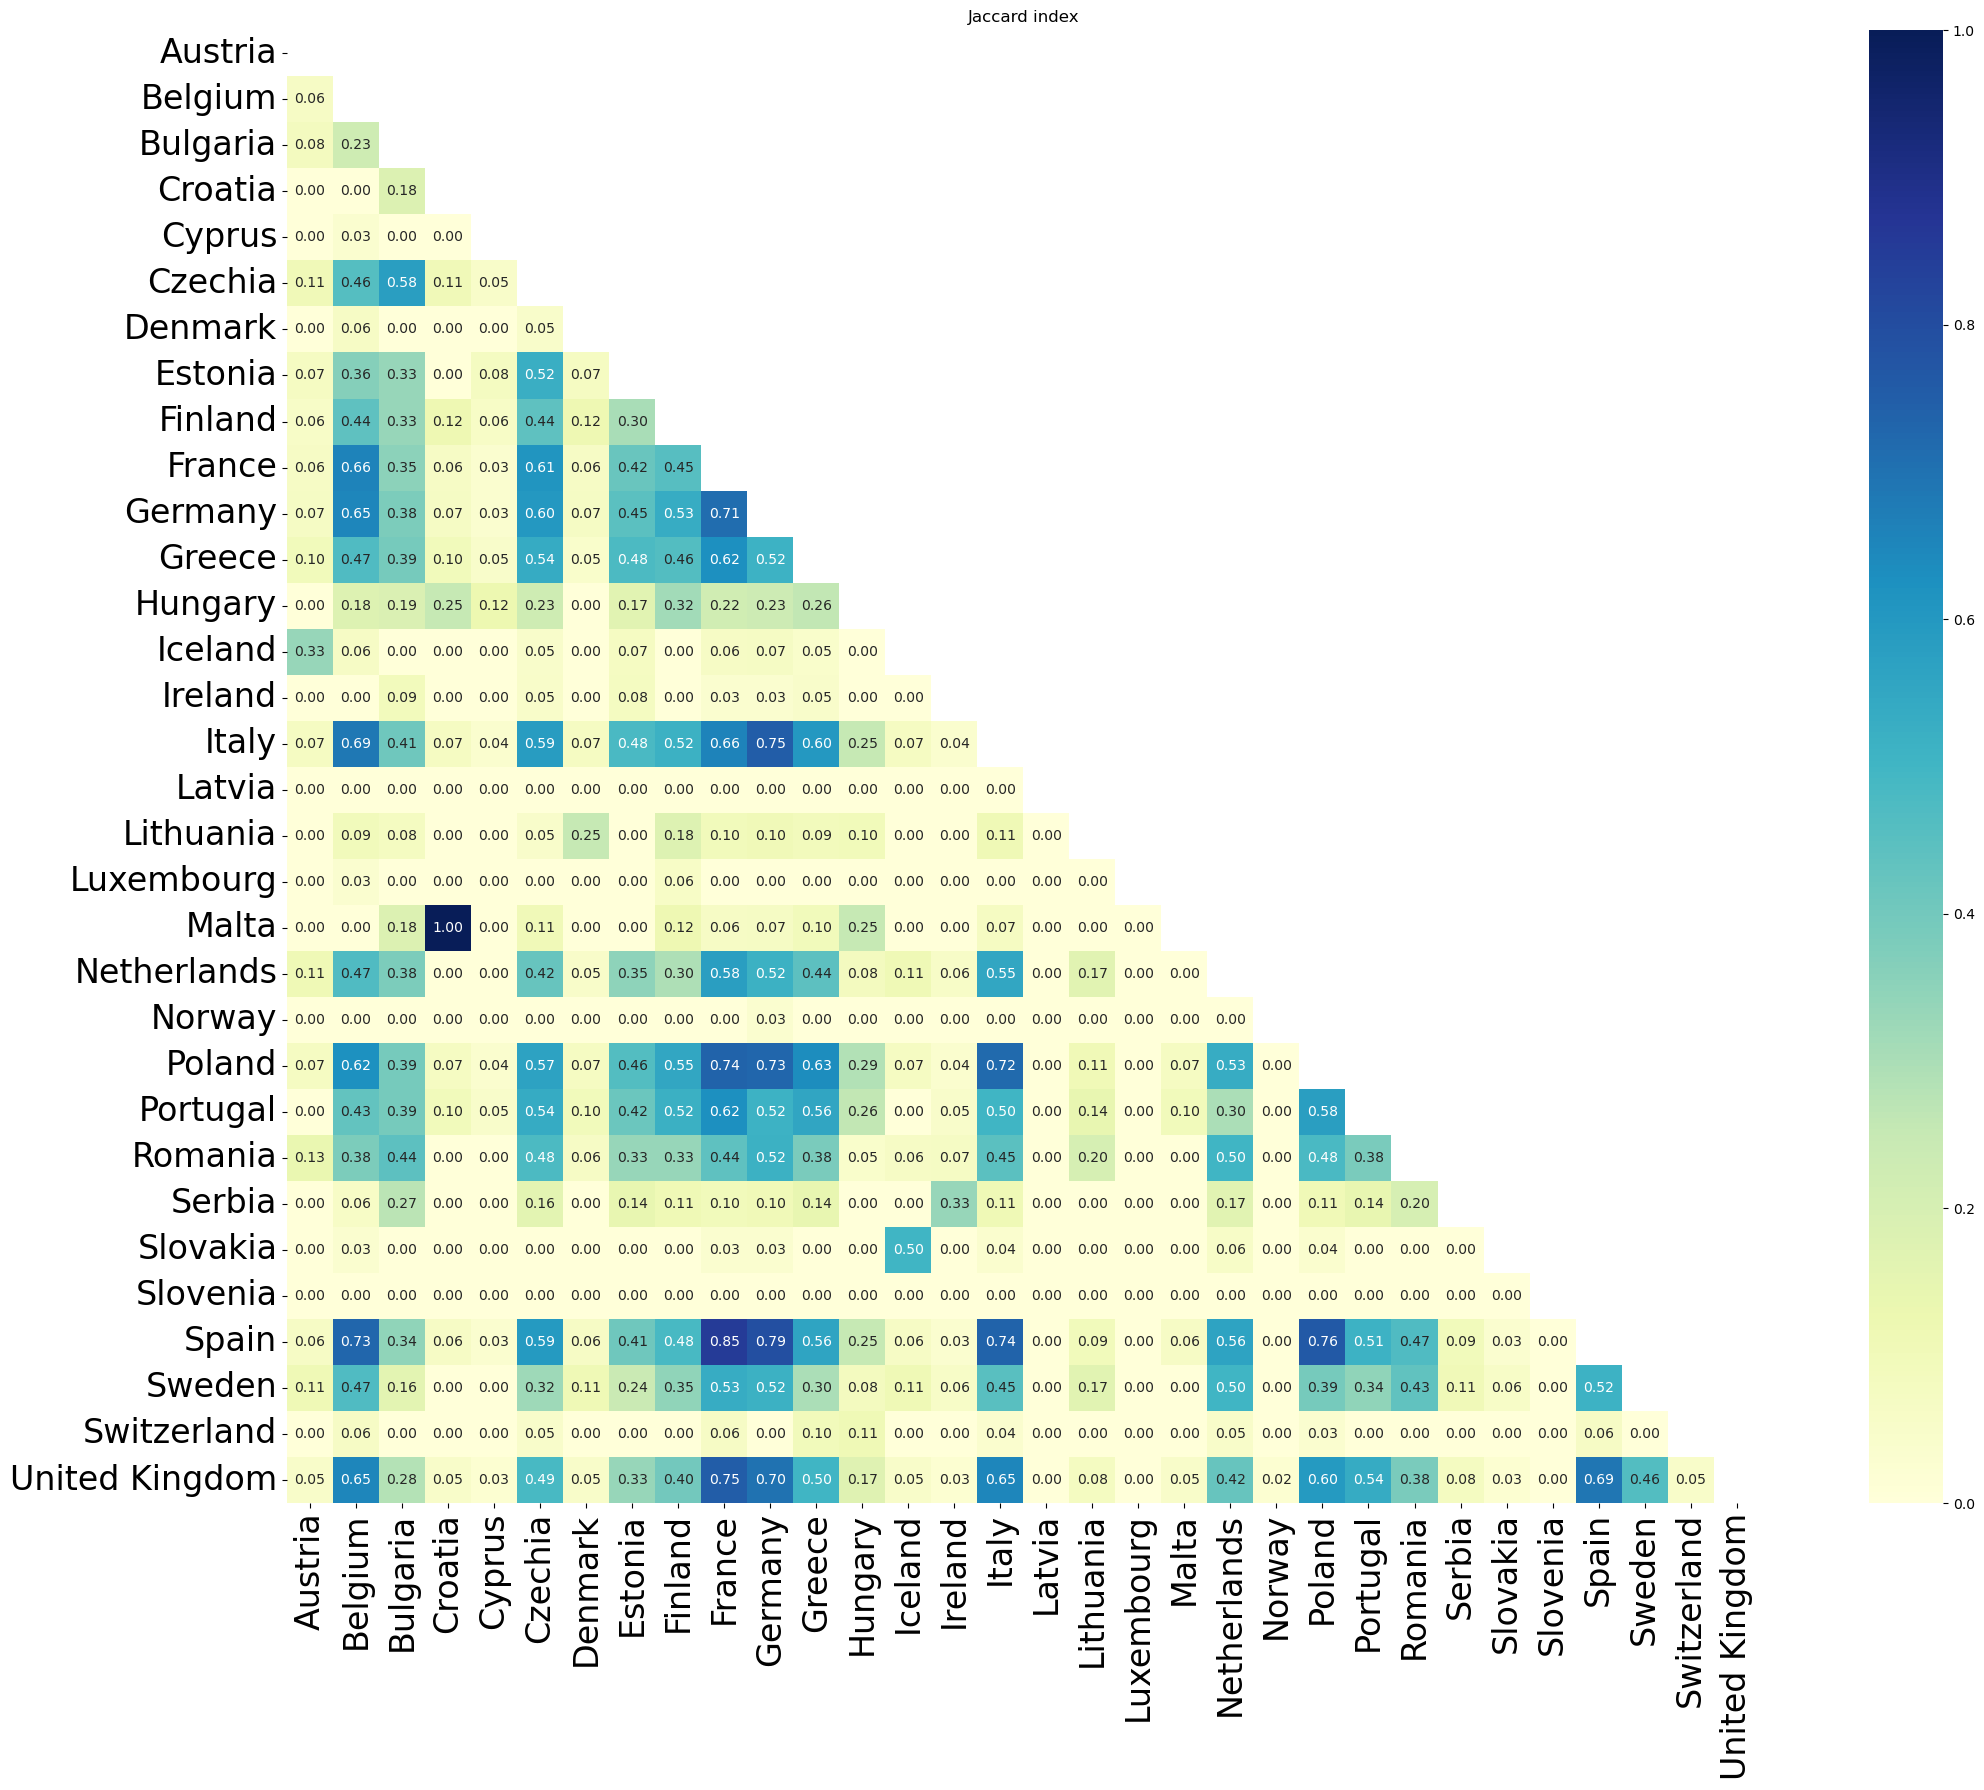

In [28]:

ser = pd.Series(list(jaccard_low_country_selected_chem_dict.values()),
                index=pd.MultiIndex.from_tuples(jaccard_low_country_selected_chem_dict.keys()))
jaccard_low_country_selected_chem_dict_df = ser.unstack().fillna(0)

# Create a mask for the higher triangle
mask = np.triu(np.ones_like(jaccard_low_country_selected_chem_dict_df, dtype=bool))

fig, ax = plt.subplots(figsize=(24, 18))

# Plot heatmap with the mask
hm = sns.heatmap(jaccard_low_country_selected_chem_dict_df, cbar=True, mask=mask, vmin=0, vmax=1,
                 fmt='.2f', annot_kws={'size': 10}, annot=True, 
                 square=True, cmap='YlGnBu')

ticks = np.arange(jaccard_low_country_selected_chem_dict_df.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(jaccard_low_country_selected_chem_dict_df.columns, rotation=90, fontsize=24)
ax.set_yticks(ticks)
ax.set_yticklabels(jaccard_low_country_selected_chem_dict_df.index, rotation=360, fontsize=24)

ax.set_title('Jaccard index')
plt.tight_layout()
#plt.savefig('output/Figures/SD9B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
low_country_selected_chem_dict_ji_list = []
for country1,chemlist1 in low_country_selected_chem_id_dict.items():
    for country2,chemlist2 in low_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            if country1!=country2:
                low_country_selected_chem_dict_ji_list.append(overlap_jaccard(chemlist1,chemlist2))
print(np.mean(low_country_selected_chem_dict_ji_list))

In [29]:
jaccard_high_country_selected_chem_dict = {}

for country1,chemlist1 in high_country_selected_chem_id_dict.items():
    for country2,chemlist2 in high_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            jaccard_high_country_selected_chem_dict[country1,country2] = overlap_jaccard(chemlist1,chemlist2)
        else:
            jaccard_high_country_selected_chem_dict[country1,country2] = 0

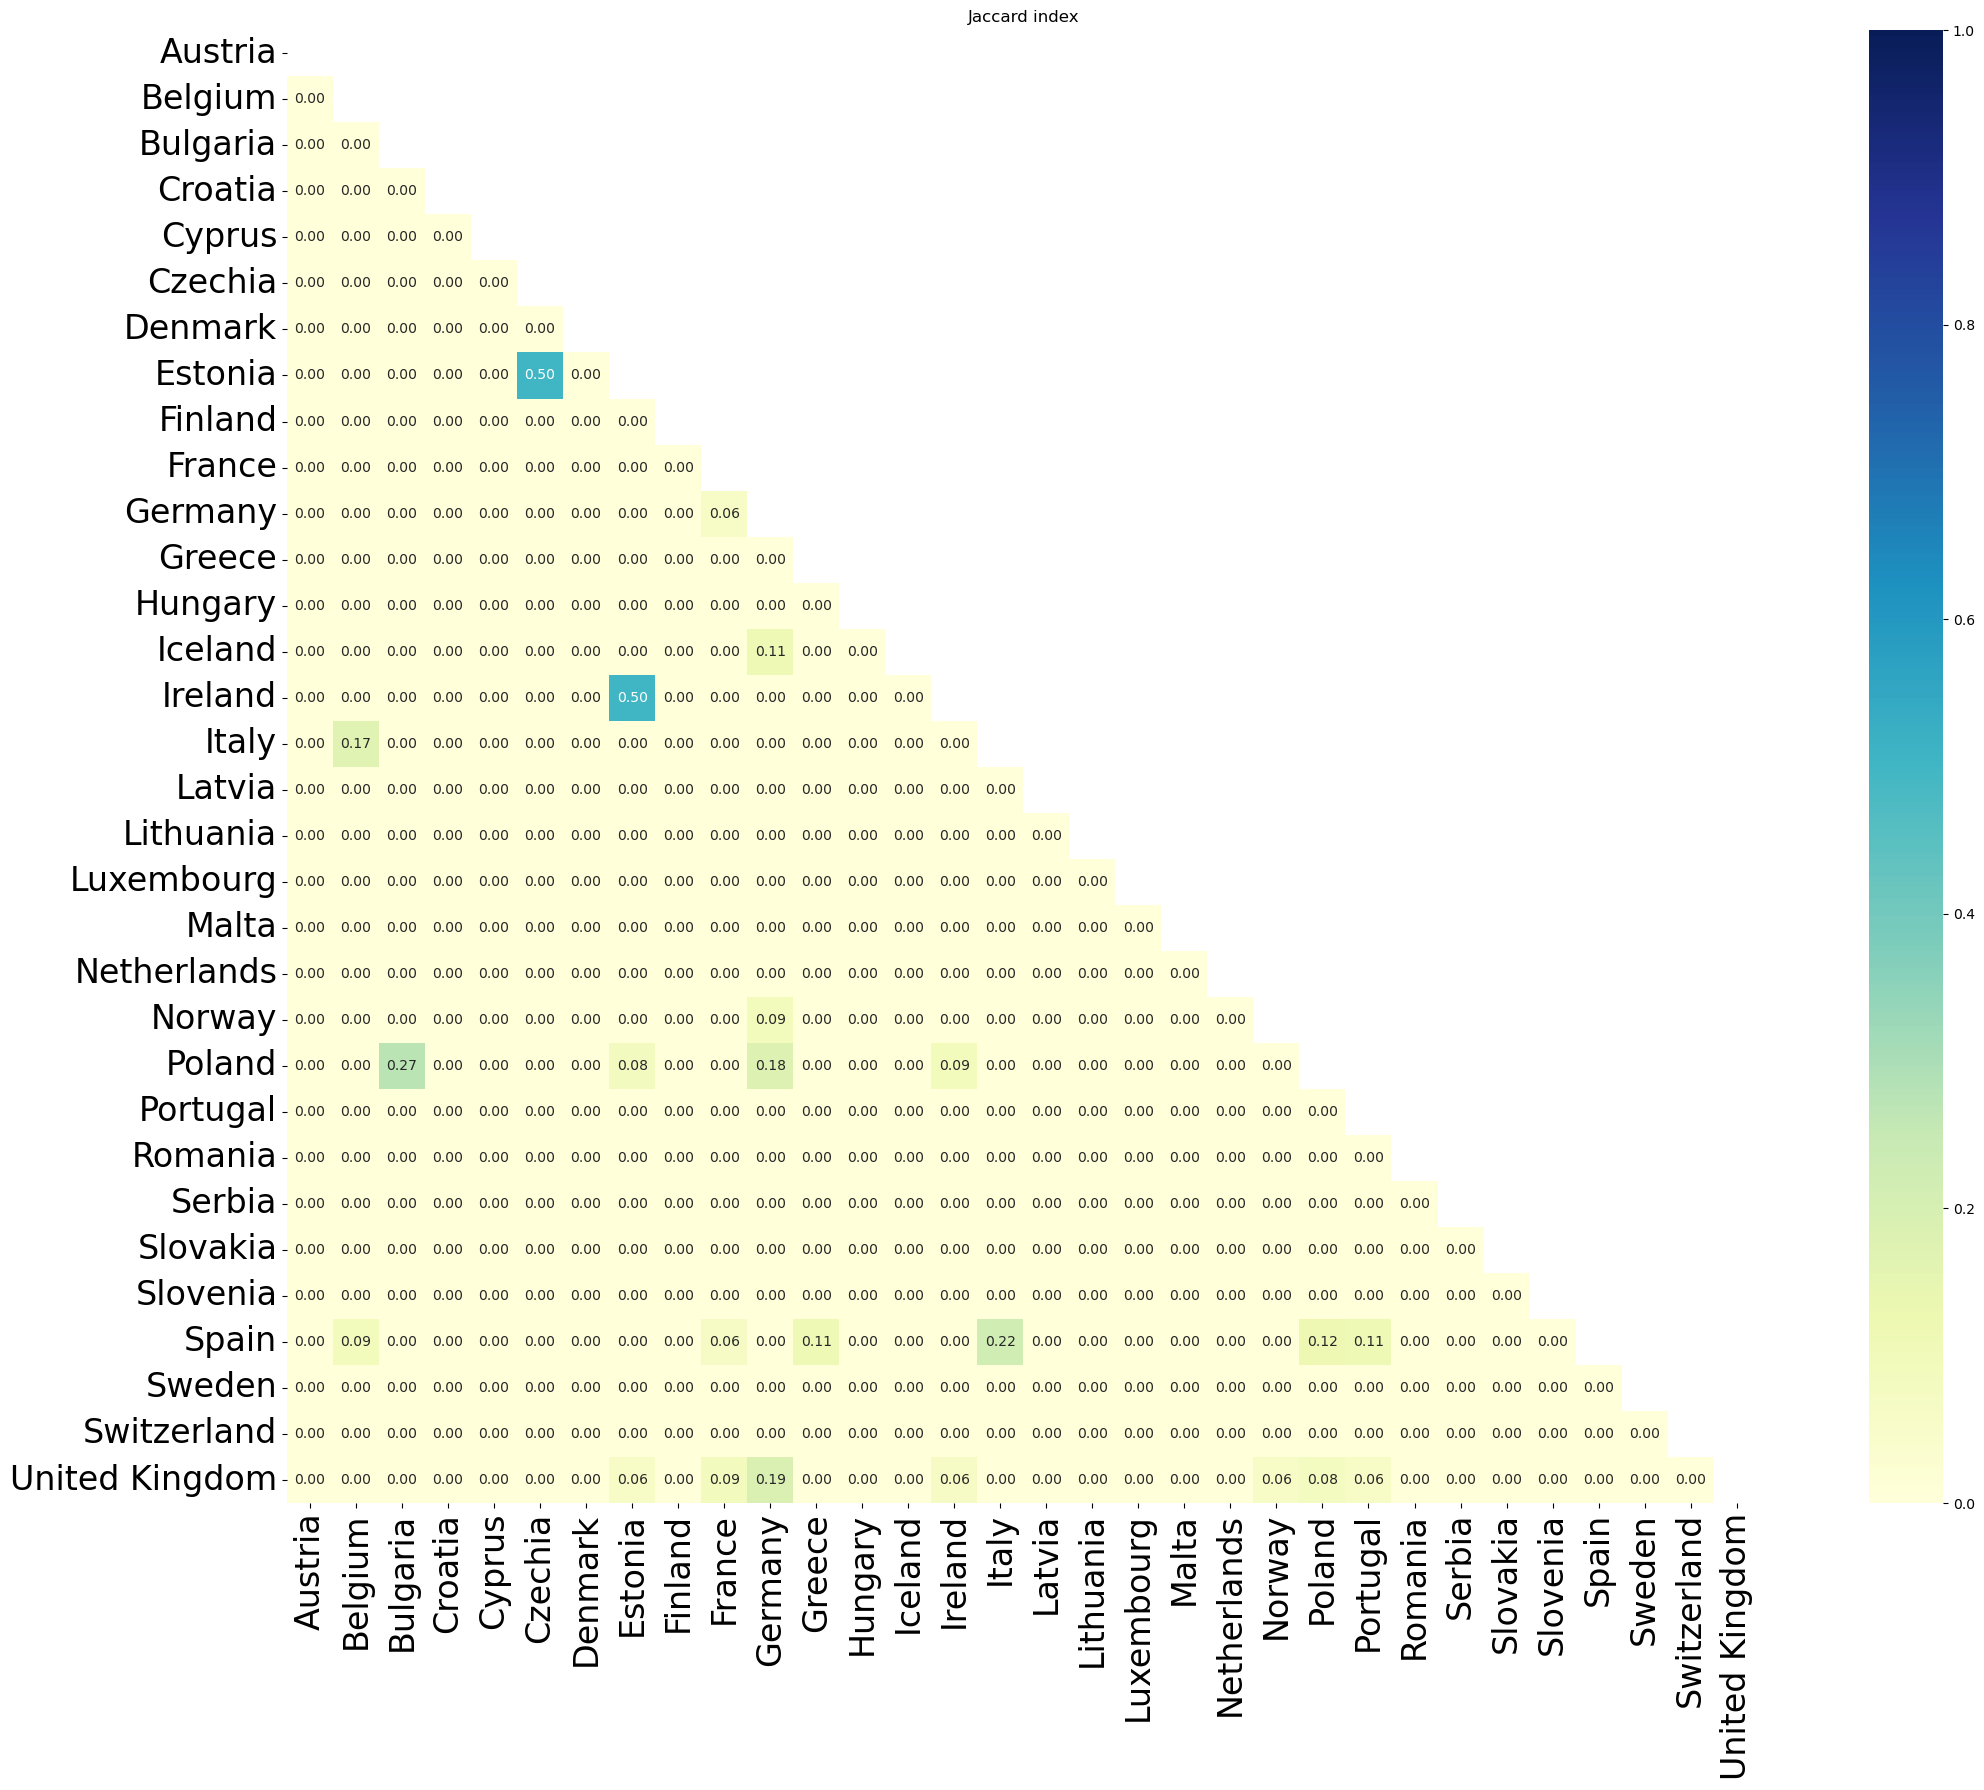

In [30]:
ser = pd.Series(list(jaccard_high_country_selected_chem_dict.values()),
                index=pd.MultiIndex.from_tuples(jaccard_high_country_selected_chem_dict.keys()))
jaccard_high_country_selected_chem_dict_df = ser.unstack().fillna(0)

# Create a mask for the higher triangle
mask = np.triu(np.ones_like(jaccard_high_country_selected_chem_dict_df, dtype=bool))

fig, ax = plt.subplots(figsize=(24, 18))

# Plot heatmap with the mask
hm = sns.heatmap(jaccard_high_country_selected_chem_dict_df, cbar=True, mask=mask, vmin=0, vmax=1,
                 fmt='.2f', annot_kws={'size': 10}, annot=True, 
                 square=True, cmap='YlGnBu')

ticks = np.arange(jaccard_high_country_selected_chem_dict_df.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(jaccard_high_country_selected_chem_dict_df.columns, rotation=90, fontsize=24)
ax.set_yticks(ticks)
ax.set_yticklabels(jaccard_high_country_selected_chem_dict_df.index, rotation=360, fontsize=24)

ax.set_title('Jaccard index')
plt.tight_layout()
#plt.savefig('output/Figures/SD9C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
high_country_selected_chem_dict_ji_list = []
for country1,chemlist1 in high_country_selected_chem_id_dict.items():
    for country2,chemlist2 in high_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            if country1!=country2:
                high_country_selected_chem_dict_ji_list.append(overlap_jaccard(chemlist1,chemlist2))
print(np.mean(high_country_selected_chem_dict_ji_list))

In [ ]:
#DISEASES

In [31]:
country_selected_dis_dict={}
for country, chem_list in country_selected_chem_id_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in real_significant_final_exp_proximity.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    country_selected_dis_dict[country]=set(dis_list)

low_country_selected_dis_dict={}
for country, chem_list in low_country_selected_chem_id_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in real_significant_final_exp_proximity.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    low_country_selected_dis_dict[country]=set(dis_list)

high_country_selected_dis_dict={}
for country, chem_list in high_country_selected_chem_id_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in real_significant_final_exp_proximity.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    high_country_selected_dis_dict[country]=set(dis_list)

In [32]:
air_proximal_disease_list = [] 

for country, disset in country_selected_dis_dict.items():
    for dis in disset:
        if dis not in air_proximal_disease_list:
            air_proximal_disease_list.append(dis)

print(len(air_proximal_disease_list))

low_air_proximal_disease_list = [] 
for country, disset in low_country_selected_dis_dict.items():
    for dis in disset:
        if dis not in low_air_proximal_disease_list:
            low_air_proximal_disease_list.append(dis)

print(len(low_air_proximal_disease_list))

high_air_proximal_disease_list = [] 

for country, disset in high_country_selected_dis_dict.items():
    for dis in disset:
        if dis not in high_air_proximal_disease_list:
            high_air_proximal_disease_list.append(dis)

print(len(high_air_proximal_disease_list))

147
147
147


In [ ]:
for dis in low_air_proximal_disease_list:
    if dis not in air_proximal_disease_list:
        print(dis)

In [ ]:
for dis in high_air_proximal_disease_list:
    if dis not in air_proximal_disease_list:
        print(dis)

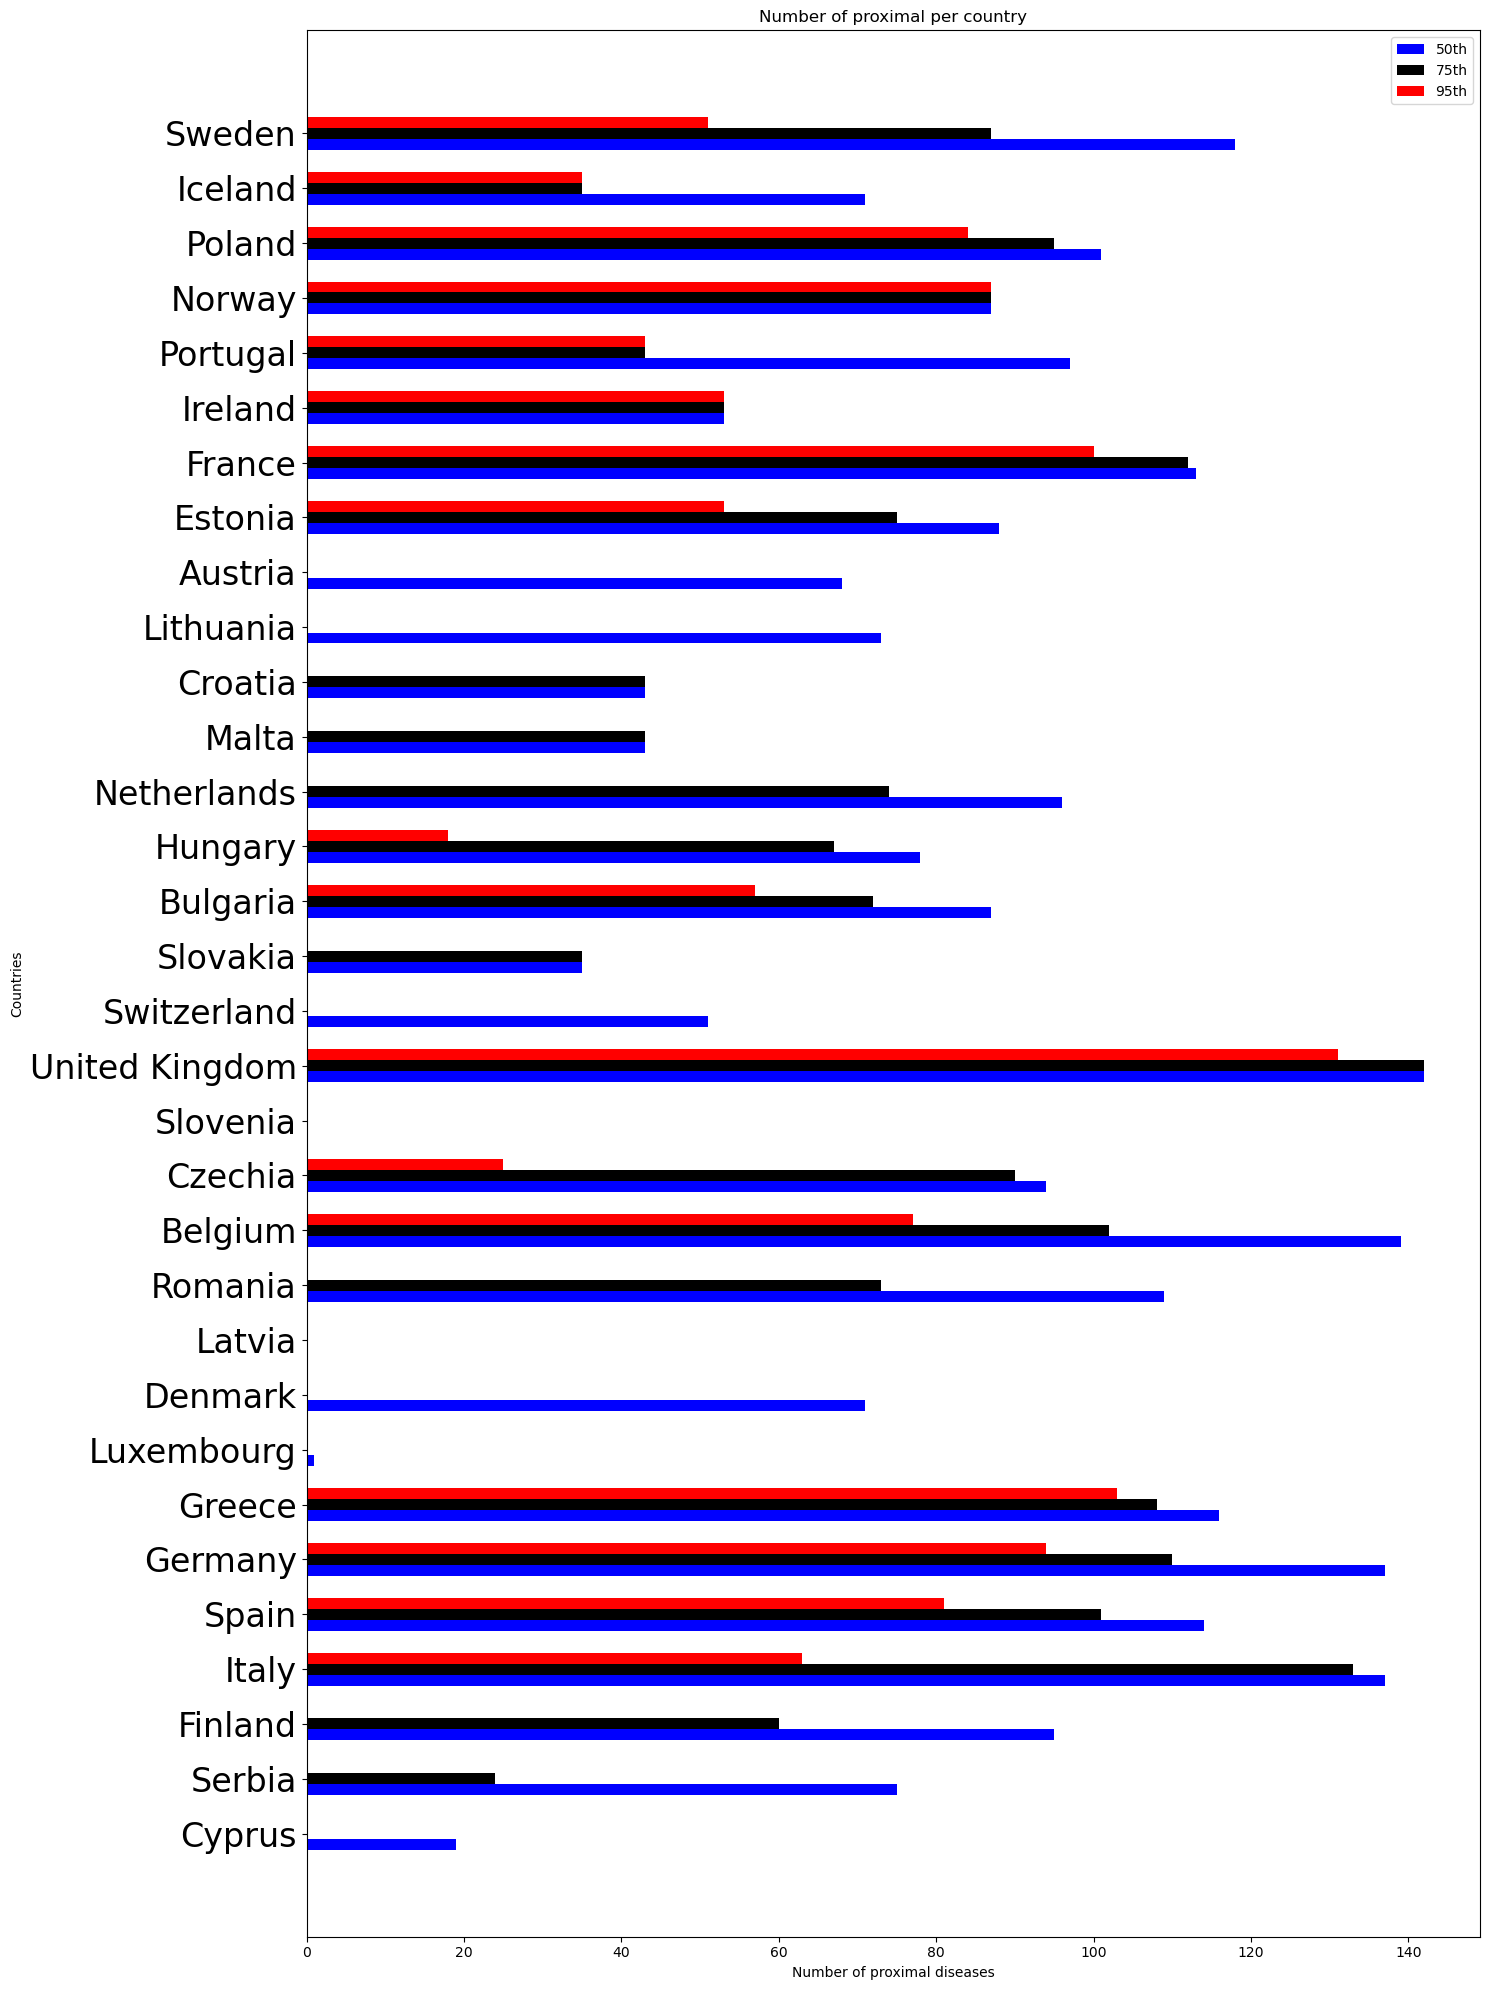

In [33]:


low_country_selected_dis_num_dict = {}
for country, dislist in low_country_selected_dis_dict.items():
    low_country_selected_dis_num_dict[country] = len(dislist)

country_selected_dis_num_dict = {}
for country, dislist in country_selected_dis_dict.items():
    country_selected_dis_num_dict[country] = len(dislist)
    
high_country_selected_dis_num_dict = {}
for country, dislist in high_country_selected_dis_dict.items():
    high_country_selected_dis_num_dict[country] = len(dislist)
    
# Get the list of countries (keys)
countries = list(country_selected_chem_num_dict.keys())

# Extract values from each dictionary
values_a = [low_country_selected_dis_num_dict[country] for country in countries]
values_b = [country_selected_dis_num_dict[country] for country in countries]
values_c = [high_country_selected_dis_num_dict[country] for country in countries]

# Define the position of bars on the x-axis
x = np.arange(len(countries))

# Width of a bar
width = 0.2

fig, ax = plt.subplots(figsize=(15, 20))

# Plotting the bars
rects1 = ax.barh(x - width, values_a, width, color='blue', label='50th')
rects2 = ax.barh(x, values_b, width, color='black', label='75th')
rects3 = ax.barh(x + width, values_c, width, color='red', label='95th')

# Adding labels, title, and customizing axes
ax.set_xlabel('Number of proximal diseases')
ax.set_ylabel('Countries')
ax.set_title('Number of proximal per country')
ax.set_yticks(x)
ax.set_yticklabels(countries,fontsize=24)
ax.legend()

# Show the plot
plt.tight_layout()
#plt.savefig('output/Figures/SF10A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [34]:

# Ensure same country order as plot
countries = list(country_selected_chem_num_dict.keys())

rows = []

for idx, country in enumerate(countries):
    rows.append({
        "Country": country,
        "Position_index": idx,
        "50th_percentile_count": low_country_selected_dis_num_dict.get(country, 0),
        "75th_percentile_count": country_selected_dis_num_dict.get(country, 0),
        "95th_percentile_count": high_country_selected_dis_num_dict.get(country, 0)
    })

df_barplot = pd.DataFrame(rows)

print("Total countries:", len(df_barplot))

# ----------------------------
# Save to Excel (single sheet)
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_barplot.to_excel(
        writer,
        sheet_name="SF16A",
        index=False
    )

    

Total countries: 32


In [35]:
#Here, we will import the epidemiological data for all countries and diseases
#The download of the data was performed from https://vizhub.healthdata.org/gbd-results/
#on 24.05.2022, using as parameters of research: all causes, locations, deaths, DALYs, Prevalence, Incidence, Rate
#This generated 11 files, that should be merged together

GBD_df_partial_list=[]
for i in range(11):
    GBD_df_partial=pd.read_csv("input/Disease/GBD/IHME-GBD_2019_DATA-e09bfeaa-%s.csv"%(i+1))
    GBD_df_partial_list.append(GBD_df_partial)
GBD_df=pd.concat(GBD_df_partial_list, sort=False)

In [36]:
disease_set=set(GBD_df['cause'])

In [45]:
#Let's create a dictionary conversion of the diseases that came from disgenet to the ones that are in GBD


air_disgenet_gbd_dict = {}
for dis in air_proximal_disease_list:
    dis_disgenet_lower = dis.lower()
    for dis_gbd in disease_set:
        dis_gbd_lower = dis_gbd.lower()
        if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.8*len(dis_disgenet_lower):
            air_disgenet_gbd_dict[dis] = dis_gbd

print(len(air_disgenet_gbd_dict))

22


In [46]:
air_disgenet_gbd_dict['Renal Cell Carcinoma'] = 'Kidney cancer'
air_disgenet_gbd_dict['Colorectal Carcinoma'] = 'Colon and rectum cancer'
air_disgenet_gbd_dict['Ovarian Carcinoma'] = 'Ovarian cancer'
air_disgenet_gbd_dict['Liver Cirrhosis, Experimental'] = 'Cirrhosis and other chronic liver diseases'
air_disgenet_gbd_dict['melanoma'] = 'Malignant skin melanoma'
air_disgenet_gbd_dict['MYELODYSPLASTIC SYNDROME'] = 'Myelodysplastic, myeloproliferative, and other hematopoietic neoplasms'
air_disgenet_gbd_dict['Cutaneous Melanoma'] = 'Malignant skin melanoma'
air_disgenet_gbd_dict['Liver Neoplasms, Experimental'] = 'Liver cancer'
air_disgenet_gbd_dict['Leukemia, Myelocytic, Acute'] = 'Acute myeloid leukemia'
air_disgenet_gbd_dict['Chronic Lymphocytic Leukemia'] = 'Chronic lymphoid leukemia'
air_disgenet_gbd_dict["Alzheimer's Disease"] = "Alzheimer's disease and other dementias"
air_disgenet_gbd_dict['Squamous cell carcinoma of esophagus'] = 'Esophageal cancer'
air_disgenet_gbd_dict['Carcinoma of lung'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Non-Small Cell Lung Carcinoma'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Brain Neoplasms'] = "Brain and central nervous system cancer"
air_disgenet_gbd_dict['Malignant neoplasm of pancreas'] = "Pancreatic cancer"
air_disgenet_gbd_dict['Malignant neoplasm of liver'] = 'Liver cancer'
air_disgenet_gbd_dict['Depressive disorder'] = "Depressive disorders"
air_disgenet_gbd_dict['Malignant neoplasm of lung'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Hypertensive disease'] = 'Hypertensive heart disease'
air_disgenet_gbd_dict['Myocardial Infarction'] = "Ischemic heart disease"
air_disgenet_gbd_dict['Malignant neoplasm of ovary'] = 'Ovarian cancer'
air_disgenet_gbd_dict['Seizures'] = "Idiopathic epilepsy"
air_disgenet_gbd_dict['Adenocarcinoma of lung (disorder)'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Cardiomyopathy, Dilated'] = 'Cardiomyopathy and myocarditis'
air_disgenet_gbd_dict['Prostatic Neoplasms'] = "Prostate cancer"
air_disgenet_gbd_dict['Mammary Neoplasms'] = 'Breast cancer'
air_disgenet_gbd_dict['Cerebrovascular accident'] = "Ischemic stroke"
air_disgenet_gbd_dict['Glioma'] = "Brain and central nervous system cancer"
air_disgenet_gbd_dict['Diabetes Mellitus, Experimental'] = 'Diabetes mellitus'
air_disgenet_gbd_dict['Liver neoplasms'] = 'Liver cancer'
air_disgenet_gbd_dict['Colonic Neoplasms'] = 'Colon and rectum cancer'
air_disgenet_gbd_dict['Malignant neoplasm of urinary bladder'] = "Bladder cancer"
air_disgenet_gbd_dict['Malignant neoplasm of stomach'] = "Stomach cancer"
air_disgenet_gbd_dict['ovarian neoplasm'] = 'Ovarian cancer'
air_disgenet_gbd_dict['Major Depressive Disorder'] = "Major depressive disorder"
air_disgenet_gbd_dict['Malignant neoplasm of prostate'] = "Prostate cancer"
air_disgenet_gbd_dict['Schizophrenia'] = "Schizophrenia"
air_disgenet_gbd_dict['Endometrial Carcinoma'] = "Uterine cancer"
air_disgenet_gbd_dict['Esophageal Neoplasms'] = 'Esophageal cancer'
air_disgenet_gbd_dict['Mammary Neoplasms, Experimental'] = 'Breast cancer'
air_disgenet_gbd_dict['Stomach Neoplasms'] = "Stomach cancer"
air_disgenet_gbd_dict['Diabetes Mellitus, Non-Insulin-Dependent'] = "Diabetes mellitus type 2"
air_disgenet_gbd_dict['Colorectal Neoplasms'] = 'Colon and rectum cancer'
air_disgenet_gbd_dict['Asthma'] = 'Asthma'
air_disgenet_gbd_dict['Liver carcinoma'] = 'Liver cancer'
air_disgenet_gbd_dict['Rheumatoid Arthritis'] = "Rheumatoid arthritis"
air_disgenet_gbd_dict['Breast Carcinoma'] = 'Breast cancer'
air_disgenet_gbd_dict['Malignant neoplasm of breast'] = 'Breast cancer'
air_disgenet_gbd_dict['Pancreatic Neoplasm'] = "Pancreatic cancer"
air_disgenet_gbd_dict['Malignant tumor of colon'] = 'Colon and rectum cancer'
air_disgenet_gbd_dict['Lung Neoplasms'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Brain Ischemia'] = 'Ischemic stroke'
air_disgenet_gbd_dict['Carcinoma, Basal Cell'] = 'Non-melanoma skin cancer (basal-cell carcinoma)'
air_disgenet_gbd_dict['Lymphoma, Non-Hodgkin'] = "Non-Hodgkin lymphoma"
air_disgenet_gbd_dict['Diabetic Nephropathy'] = 'Diabetes and kidney diseases'
air_disgenet_gbd_dict['Coronary heart disease'] = 'Ischemic heart disease'
air_disgenet_gbd_dict['Kidney Failure, Chronic'] = 'Chronic kidney disease'
air_disgenet_gbd_dict['Parkinson Disease'] = "Parkinson's disease"
air_disgenet_gbd_dict['Autistic Disorder'] = "Autism spectrum disorders"
air_disgenet_gbd_dict['Pancreatic carcinoma'] = "Pancreatic cancer"
air_disgenet_gbd_dict['Breast adenocarcinoma'] = 'Breast cancer'
air_disgenet_gbd_dict['Thyroid carcinoma'] = 'Thyroid cancer'
air_disgenet_gbd_dict['Unipolar Depression'] = "Major depressive disorder"
air_disgenet_gbd_dict['Polycystic Ovary Syndrome'] = "Polycystic ovarian syndrome"
air_disgenet_gbd_dict['Squamous cell carcinoma of lung'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Glioblastoma Multiforme'] = "Brain and central nervous system cancer"
air_disgenet_gbd_dict['Esophageal carcinoma'] = 'Esophageal cancer'
air_disgenet_gbd_dict['Parkinsonian Disorders'] = "Parkinson's disease"
air_disgenet_gbd_dict['Mental Depression'] = "Major depressive disorder"
air_disgenet_gbd_dict['Coronary Artery Disease'] = 'Ischemic heart disease'
air_disgenet_gbd_dict['Cleft Palate'] = "Orofacial clefts"
air_disgenet_gbd_dict['Chronic Obstructive Airway Disease'] = 'Chronic obstructive pulmonary disease'
air_disgenet_gbd_dict['Uterine Cervical Neoplasm'] = "Uterine cancer"
air_disgenet_gbd_dict['Pulmonary Fibrosis'] = "Interstitial lung disease and pulmonary sarcoidosis"


In [47]:
country_selected_dis_mean_prox_dict = {}
for country,disset in country_selected_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(country_selected_chem_id_dict[country])>0:
            for chem in country_selected_chem_id_dict[country]:
                try:
                    z_list.append(real_significant_final_exp_proximity[chem,dis][1])
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)
                    
    country_selected_dis_mean_prox_dict[country] = dis_dict

#Here, we have to clean the diseases that appears in each countries, considering only the ones that are reported in
#GBD and using a little of manual curation for merging some terms (for example breast cancer and carcinoma of breast)
#Now, we can create a country proximal diseases dictionary with the diseases taken from GBD


country_selected_chem_id_gbd_dict = {}
for country,dis_dict in country_selected_dis_mean_prox_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([air_disgenet_gbd_dict[dis],z])
            except:
                pass
        country_selected_chem_id_gbd_dict[country] = dis_z_list



country_selected_chem_id_gbd_mean_dict = {}
for country,dislist in country_selected_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    country_selected_chem_id_gbd_mean_dict[country]=dis_dict

            

In [39]:
#Let's import the distant diseases
with open('output/exp_random/faraway_exp_dis_dict.pickle', 'rb') as handle:
    faraway_exp_dis_dict = pk.load(handle)

In [48]:
country_selected_faraway_dis_dict={}
for country,chemset in country_selected_chem_id_dict.items():
    if len(chemset)>0:
        far_away_dis_set = []
        for chem in chemset:
            for chem_dis_pair in faraway_exp_dis_dict.keys():
                if chem in chem_dis_pair[0]:
                    far_away_dis_set.append(chem_dis_pair[1])
        country_selected_faraway_dis_dict[country] = set(far_away_dis_set)

faraway_air_disset = []
for country,disset in country_selected_faraway_dis_dict.items():
    for dis in disset:
        if dis not in faraway_air_disset:
            faraway_air_disset.append(dis)

print(len(faraway_air_disset))

210


In [49]:
#Let's convert the name of the distant diseases

long_faraway_air_disset_gbd_dict = {}
for dis in faraway_air_disset:
    dis_disgenet_lower = dis.lower()
    for dis_gbd in disease_set:
        dis_gbd_lower = dis_gbd.lower()
        if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.7*len(dis_disgenet_lower):
            long_faraway_air_disset_gbd_dict[dis] = dis_gbd

print(len(long_faraway_air_disset_gbd_dict))

4


In [50]:
n_long_faraway_air_disset_gbd_dict = {}
for dis1 in faraway_air_disset:
    dis1_processed = preprocess_string(dis1)
    # Initialize best match tracking
    best_match = (None, 0)  # (Best match disease name, similarity score)
    for dis2 in disease_set:
        dis2_processed = preprocess_string(dis2)
        similarity = get_similarity_score(dis1_processed, dis2_processed)
        # Update if this is the best match so far
        if similarity > best_match[1]:
            best_match = (dis2, similarity)
    
    # You may want to set a threshold for "good enough" matching
    if best_match[1] > 50:  # This threshold
        n_long_faraway_air_disset_gbd_dict[dis1] = best_match[0]

print(len(n_long_faraway_air_disset_gbd_dict))

110


In [51]:
#Let's remove those diseases that had the wrong march


keys_to_delete=['Weill-Marchesani-Like Syndrome','HYPOGONADOTROPIC HYPOGONADISM 11 WITH OR WITHOUT ANOSMIA','Night blindness, congenital stationary',
             'Narcolepsy 1', 'DEAFNESS, X-LINKED 4 (disorder)','Juvenile nephropathic cystinosis (disorder)', 'Congenital Pain Insensitivity',
                'Nephropathic cystinosis','Congenital long QT syndrome','Glomerulocystic Kidney Disease with Hyperuricemia and Isosthenuria',
                'Keutel syndrome','FICOLIN 3 DEFICIENCY','Autosomal Dominant Nocturnal Frontal Lobe Epilepsy','Cavitary Optic Disc Anomalies',
                'alpha, alpha-Trehalase deficiency','Nephritis, Tubulointerstitial','Cerebral ventriculomegaly','HYPOGONADOTROPIC HYPOGONADISM 4 WITH OR WITHOUT ANOSMIA',
                'Goiter','Medullary Cystic Kidney Disease Type 2','Malabsorption Syndrome','CATARACT 39, MULTIPLE TYPES',
                'Long Qt Syndrome 10','RETINITIS PIGMENTOSA 49','Olmsted syndrome','Cystinosis','HIRSCHSPRUNG DISEASE, SUSCEPTIBILITY TO, 4',
                'MASP2 Deficiency','Cone monochromatism','Enterokinase Deficiency','Retinitis Pigmentosa 7','Narcolepsy','Jarcho-Levin syndrome',
                'Waardenburg Syndrome, Type 4b','NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1E','Factor XIII, B Subunit, Deficiency Of',
                'Renal hypouricemia','MYASTHENIC SYNDROME, CONGENITAL, 1A, Shigh-CHANNEL','BLEEDING DISORDER, PLATELET-TYPE, 20',
                'SMALL PATELLA SYNDROME','Amish Infantile Epilepsy Syndrome','Scoliosis, unspecified','Focal glomerulosclerosis',
                'Meningococcal Infections','Indifference to Pain, Congenital, Autosomal Recessive','Neuropathy, Distal Hereditary Motor, Type VIIA',
                'Obstruction of pelviureteric junction','TELANGIECTASIA, HEREDITARY HEMORRHAGIC, TYPE 5','Marshall syndrome','STICKLER SYNDROME, TYPE II (disorder)',
                'Histiocytosis','Hypopigmentation disorder','PAROXYSMAL EXTREME PAIN DISORDER','NEMALINE MYOPATHY 10','DEAFNESS, AUTOSOMAL RECESSIVE 42 (disorder)',
                'Nivelon Nivelon Mabille syndrome','HERMANSKY-PUDLAK SYNDROME 4','Juvenile hemochromatosis','HEMOCHROMATOSIS, TYPE 2A','USHER SYNDROME, TYPE IJ',
                'CATARACT 47','Usher Syndrome, Type IF','Hypouricemia, Renal, 2','NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1G','Primary Erythermalgia',
                'Trimethylaminuria','Hypertrichosis','Congenital disorder of glycosylation, type 2C','Night Blindness, Congenital Stationary, Autosomal Dominant 3',
                'Lysinuric Protein Intolerance','RETINITIS PIGMENTOSA, JUVENILE, LRAT-RELATED','Trichotillomania','Hydrocephalus','Usher Syndrome, Type I',
                'STARGARDT DISEASE 1 (disorder)','Perisylvian syndrome','Liver Failure','CATARACT 4, MULTIPLE TYPES','DEAFNESS, AUTOSOMAL RECESSIVE 1A (disorder)',
                'CILIARY DYSKINESIA, PRIMARY, 7 (disorder)','Vesico-Ureteral Reflux','VAN DER WOUDE SYNDROME 1','Hyperaldosteronism','Popliteal pterygium syndrome',
                'Riboflavin Deficiency','Zunich neuroectodermal syndrome','Hypercalcemia, Infantile','CONE-ROD DYSTROPHY 3 (disorder)','RETINITIS PIGMENTOSA 19','CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Ip',
                'Juvenile macular degeneration',"Stargardt's disease",'RETINITIS PIGMENTOSA 48'
                

]

n_long_faraway_air_disset_gbd_dict_cleaned = {}
for disgenet_dis, gbd_dis in n_long_faraway_air_disset_gbd_dict.items():
    if disgenet_dis not in keys_to_delete:
        n_long_faraway_air_disset_gbd_dict_cleaned[disgenet_dis] = gbd_dis

n_long_faraway_air_disset_gbd_dict_cleaned['CATARACT 39, MULTIPLE TYPES'] = 'Cataract'
n_long_faraway_air_disset_gbd_dict_cleaned['NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1E'] = 'Blindness and vision loss'
n_long_faraway_air_disset_gbd_dict_cleaned['CATARACT 4, MULTIPLE TYPES'] = 'Cataract'
n_long_faraway_air_disset_gbd_dict_cleaned['CATARACT 47'] = 'Cataract'

faraway_dis_list = list(n_long_faraway_air_disset_gbd_dict_cleaned.values())
faraway_dis_list.extend(['Congenital musculoskeletal and limb anomalies','Congenital birth defects','Congenital heart anomalies',
                        'Turner syndrome','Klinefelter syndrome'])

print(len(faraway_dis_list))

27


In [54]:
faraway_manually_added_diseases = ['Congenital musculoskeletal and limb anomalies','Congenital birth defects','Congenital heart anomalies']

country_faraway_dis_dict = {}
for country,dis_dict in country_selected_chem_id_gbd_mean_dict.items():
    chem_set = country_selected_chem_id_dict[country]
    country_faraway_dis_list = []
    country_specific_faraway_dis_dict = {}
    
    for dis in faraway_dis_list:
        if dis not in dis_dict.keys():
            country_faraway_dis_list.append(dis)
    for dis in country_faraway_dis_list:
        if dis not in faraway_manually_added_diseases:
            disgenet_name_list = []
            z_score_list = []
            for disgenet_name,gbd_id in n_long_faraway_air_disset_gbd_dict_cleaned.items():
                if dis == gbd_id:
                    disgenet_name_list.append(disgenet_name)
                    for chem in chem_set:
                        try:
                            z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                        except:
                            pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        elif dis=='Congenital heart anomalies':
            disgenet_name_list = ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon',
                                 'Congenital long QT syndrome']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        
        elif dis=='Congenital musculoskeletal and limb anomalies':
            disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                 'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                 'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                 'Congenital Fibrosis of the Extraocular Muscles']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
            
        elif dis=='Congenital birth defects':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Congenital' in dis or 'congenital' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)

        elif dis=='Turner syndrome':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Turner' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
    country_faraway_dis_dict[country] = country_specific_faraway_dis_dict

    

In [55]:
no_prox_air_disset_gbd_dict = {}
for dis1 in diseases_genes_associated_ppi.keys():
    if 'syndrome' not in dis1:
        if 'Syndrome' not in dis1 :
            dis1_processed = preprocess_string(dis1)
            # Initialize best match tracking
            best_match = (None, 0)  # (Best match disease name, similarity score)
            for dis2 in disease_set:
                dis2_processed = preprocess_string(dis2)
                similarity = get_similarity_score(dis1_processed, dis2_processed)
                # Update if this is the best match so far
                if similarity > best_match[1]:
                    best_match = (dis2, similarity)
            
            # You may want to set a threshold for "good enough" matching
            if best_match[1] > 70:  # This threshold
                no_prox_air_disset_gbd_dict[dis1] = best_match[0]

print(len(no_prox_air_disset_gbd_dict))

306


In [56]:

#Let's clean the dictionary removing those terms that are wrong by the systematic analysis
elements_to_delete = ['CHOPS SYNDROME','ADULT SYNDROME','Leber Congenital Amaurosis','COWDEN SYNDROME 6','Canavan Disease',
                      'Cystic Kidney Diseases','Cystic Fibrosis','IRAK4 Deficiency','NOONAN SYNDROME 10','Glucagonoma',
                      'MAST SYNDROME','Cholelithiasis','ovarian neoplasm','MYD88 Deficiency','Urocanase deficiency',
                      'LONG QT SYNDROME 5','Malignant mesothelioma','Neurodevelopmental Disorders','Prion Diseases',
                      'Mood Disorders','L-FERRITIN DEFICIENCY','Malignant neoplasm of liver','T-Cell Prolymphocytic Leukemia',
                      'VERHEIJ SYNDROME','Tyrosine Kinase 2 Deficiency','Malignant neoplasm of testis','Steatohepatitis',
                      'MEESTER-LOEYS SYNDROME','Heart Diseases','Cystinosis','Cardiomyopathy, Dilated, 1g','5-oxoprolinase deficiency',
                      'Disorder of eye','Heart valve disease','HYDROCEPHALUS, CONGENITAL, 3, WITH BRAIN ANOMALIES','Transcobalamin II deficiency',
                      'NOONAN SYNDROME 9','Hodgkin Disease','Malignant neoplasm of kidney','Acute Promyelocytic Leukemia','NGLY1 deficiency',
                      'Movement Disorders','MASP2 Deficiency','Eye Diseases, Hereditary','FICOLIN 3 DEFICIENCY','MEND SYNDROME',
                      'Scrapie','Endometrial Neoplasms','Diverticular Diseases','Manic Disorder','Malignant neoplasm of pancreas',
                      'Enterokinase Deficiency','Malignant neoplasm of brain','COWDEN SYNDROME 7','Pneumonitis','Deficiency of galactokinase',
                      'Arthritis, Psoriatic','Memory Disorders','Properdin deficiency disease','TORG-WINCHESTER SYNDROME','Thyroid Neoplasm',
                      'NOONAN SYNDROME 7','COWCHOCK SYNDROME','Ataxia with vitamin E deficiency','INFLAMMATORY SKIN AND BOWEL DISEASE, NEONATAL, 1',
                      'Skin Neoplasms','Glioma','Uterine Neoplasms','ZAP70 deficiency','AU-KLINE SYNDROME','Uremia','Kidney Calculi',
                      'Lung Diseases, Interstitial','KLEEFSTRA SYNDROME 1','Protein C Deficiency','Gastritis, Atrophic','Peritoneal Fibrosis',
                      'Stomach Neoplasms','Chronic Neutrophilic Leukemia','Nodal rhythm disorder','Malignant neoplasm of breast',
                      'RAINE SYNDROME','Malignant neoplasm of ovary','Mitochondrial Diseases','COCOON SYNDROME','Thymus Neoplasms',
                      'Malignant neoplasm of mouth','SWEENEY-COX SYNDROME','Celiac Disease','TYLOSIS WITH ESOPHAGEAL CANCER',
                      'MUNGAN SYNDROME','Deficiency of prolidase','Galactosemias','Malignant neoplasm of prostate','prostatitis',
                      'NOONAN SYNDROME 8','Dystonia','Glutamine deficiency, congenital','Liver neoplasms','C9 Deficiency','Retinal Diseases',
                      'LONG QT SYNDROME 3','Mouth Neoplasms','Deficiency of fructokinase','Brain Neoplasms','BAKER-GORDON SYNDROME',
                      'NOONAN SYNDROME 3','MYOPIA 6 (disorder)','Malignant neoplasm of lung','MACULAR DEGENERATION, EARLY-ONSET',
                      'HIV Infections','Neonatal diabetes mellitus','Colitis','Dihydropyrimidinase deficiency','TENORIO SYNDROME',
                      'Herpes encephalitis','Malignant melanoma of iris','GATA2 Deficiency','Intestinal Pseudo-Obstruction',
                      "Dent's disease",'HEART DEFECTS, CONGENITAL, AND OTHER CONGENITAL ANOMALIES','Malignant neoplasm of stomach',
                      'Osteitis Deformans','Fibrinogen Deficiency','Lung diseases','Metabolic Bone Disorder','Sialidase deficiency',
                      'Lung Neoplasms','Iron Metabolism Disorders','Graves Disease','Malignant Neoplasms','Riboflavin Deficiency','Migraine Disorders',
                      'Crohn Disease'
]

no_prox_air_disset_gbd_dict_cleaned = {}

for disgenet_name,gbd_name in no_prox_air_disset_gbd_dict.items():
    if disgenet_name not in elements_to_delete:
        no_prox_air_disset_gbd_dict_cleaned[disgenet_name] = gbd_name

noprox_gbd_list = set(list(no_prox_air_disset_gbd_dict_cleaned.values()))

no_prox_air_disset_gbd_dict_cleaned_inv = {}
for gbd_dis in noprox_gbd_list:
    disgenet_name_list = [] 
    for disg_id,gbd_ in no_prox_air_disset_gbd_dict_cleaned.items():
        if gbd_dis==gbd_:
            disgenet_name_list.append(disg_id)
    no_prox_air_disset_gbd_dict_cleaned_inv[gbd_dis] = disgenet_name_list

print(len(no_prox_air_disset_gbd_dict_cleaned_inv))
            



85


In [57]:

country_noprox_dis_dict = {}
for country,dis_dict in country_selected_chem_id_gbd_mean_dict.items():
    n_dis = len(dis_dict)
    chem_set = country_selected_chem_id_dict[country]
    country_noprox_dis_list = []
    country_specific_noprox_dis_dict = {}
    
    for gbd_dis,dislist in no_prox_air_disset_gbd_dict_cleaned_inv.items():
        if gbd_dis not in dis_dict.keys():
            if gbd_dis not in list(country_faraway_dis_dict[country].keys()):
                country_noprox_dis_list.append(gbd_dis)
    for dis in country_noprox_dis_list:
        disgenet_name_list = no_prox_air_disset_gbd_dict_cleaned_inv[dis]
        z_score_list = []
        for chem in chem_set:
            for disgenet_name in disgenet_name_list:
                try:
                    z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                except:
                    pass
        if np.mean(z_score_list)>-1.5:
            country_specific_noprox_dis_dict[dis]=np.mean(z_score_list)
    country_specific_noprox_dis_dict_sort = {k: v for k, v in sorted(country_specific_noprox_dis_dict.items(), key=lambda item: item[1])}
    
    if len(country_specific_noprox_dis_dict_sort)>n_dis:
        country_specific_noprox_dis_dict_sort_keys = list(country_specific_noprox_dis_dict_sort.keys())
        n_country_specific_noprox_dis_dict_sort = {}
        for k in list(country_specific_noprox_dis_dict_sort_keys)[:n_dis]:
            n_country_specific_noprox_dis_dict_sort[k]=country_specific_noprox_dis_dict_sort[k]
        
        country_noprox_dis_dict[country] = n_country_specific_noprox_dis_dict_sort
    else:
        country_noprox_dis_dict[country] = country_specific_noprox_dis_dict_sort
 

In [ ]:
for k,v in country_noprox_dis_dict.items():
    print(k,len(v))

In [58]:
#Let's import the incidence data
with open('output/GBD/country_dis_incidence.pickle', 'rb') as handle:
    country_dis_incidence = pk.load(handle)
    
with open('output/GBD/country_dis_prevalence.pickle', 'rb') as handle:
    country_dis_prevalence = pk.load(handle)
    
with open('output/GBD/country_dis_DALYs.pickle', 'rb') as handle:
    country_dis_DALYs = pk.load(handle)
    
with open('output/GBD/country_dis_mortality.pickle', 'rb') as handle:
    country_dis_mortality = pk.load(handle)

In [75]:
#Let's just merge the no-proximal dictionary and the faraway dictionary
new_country_distant_dis_dict = {}
for country,dis_dict in country_selected_chem_id_gbd_mean_dict.items():
    n_proxdis = len(dis_dict)
    n_distantdis = len(country_faraway_dis_dict[country])
    noprox_list = list(country_noprox_dis_dict[country].keys())
    missing_dis = n_proxdis-n_distantdis
    try:
        dislist = noprox_list[:missing_dis]
        distant_dict = country_faraway_dis_dict[country].copy()
        for dis in dislist:
            distant_dict[dis] = country_noprox_dis_dict[country][dis]
        new_country_distant_dis_dict[country] = distant_dict
    except:
        distant_dict = {**country_faraway_dis_dict[country], **country_noprox_dis_dict[country]}
        new_country_distant_dis_dict[country] = distant_dict

In [76]:
proximal_dis_list=[] 
for country, disdict in country_selected_chem_id_gbd_mean_dict.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list


proximal_dis_prevalence={}
for dis in set(proximal_dis_list):
    prevalence_list=[]
    for country in country_set:
        prevalence_list.append(country_dis_prevalence[country][dis])
    proximal_dis_prevalence[dis]=prevalence_list

proximal_dis_mortality={}
for dis in set(proximal_dis_list):
    mortality_list=[]
    for country in country_set:
        mortality_list.append(country_dis_mortality[country][dis])
    proximal_dis_mortality[dis]=mortality_list

proximal_dis_daly={}
for dis in set(proximal_dis_list):
    daly_list=[]
    for country in country_set:
        daly_list.append(country_dis_DALYs[country][dis])
    proximal_dis_daly[dis]=daly_list

In [77]:
import seaborn as sns
country_proximal_zscore_dict={}
for country,dis_dict in country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_incidence[dis])
        std = np.std(proximal_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    country_proximal_zscore_dict[country]=country_proximal_zscore_list

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/558231825.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [78]:
distant_dis_list=[] 
for country, disdict in new_country_distant_dis_dict.items():
    distant_dis_list.extend(list(disdict.keys()))
    
distant_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(distant_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    distant_dis_incidence[dis]=incidence_list

distant_dis_prevalence={}
for dis in set(distant_dis_list):
    prevalence_list=[]
    for country in country_set:
        prevalence_list.append(country_dis_prevalence[country][dis])
    distant_dis_prevalence[dis]=prevalence_list

distant_dis_mortality={}
for dis in set(distant_dis_list):
    mortality_list=[]
    for country in country_set:
        mortality_list.append(country_dis_mortality[country][dis])
    distant_dis_mortality[dis]=mortality_list

distant_dis_daly={}
for dis in set(distant_dis_list):
    daly_list=[]
    for country in country_set:
        daly_list.append(country_dis_DALYs[country][dis])
    distant_dis_daly[dis]=daly_list

In [79]:
air_country_distant_zscore_dict={}

for country,dis_dict in new_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_incidence[dis])
        std = np.std(distant_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2876578949.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [80]:
air_pollution_zscore_df = pd.DataFrame()

selected_countries=set(air_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

In [81]:
my_order = sorted(list(set(air_pollution_zscore_df['location'])))

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/607095486.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size = 36)


[Text(-4.0, 0, '-4.0'),
 Text(-2.0, 0, '-2.0'),
 Text(0.0, 0, '0.0'),
 Text(2.0, 0, '2.0'),
 Text(4.0, 0, '4.0'),
 Text(6.0, 0, '6.0'),
 Text(8.0, 0, '8.0'),
 Text(10.0, 0, '10.0')]

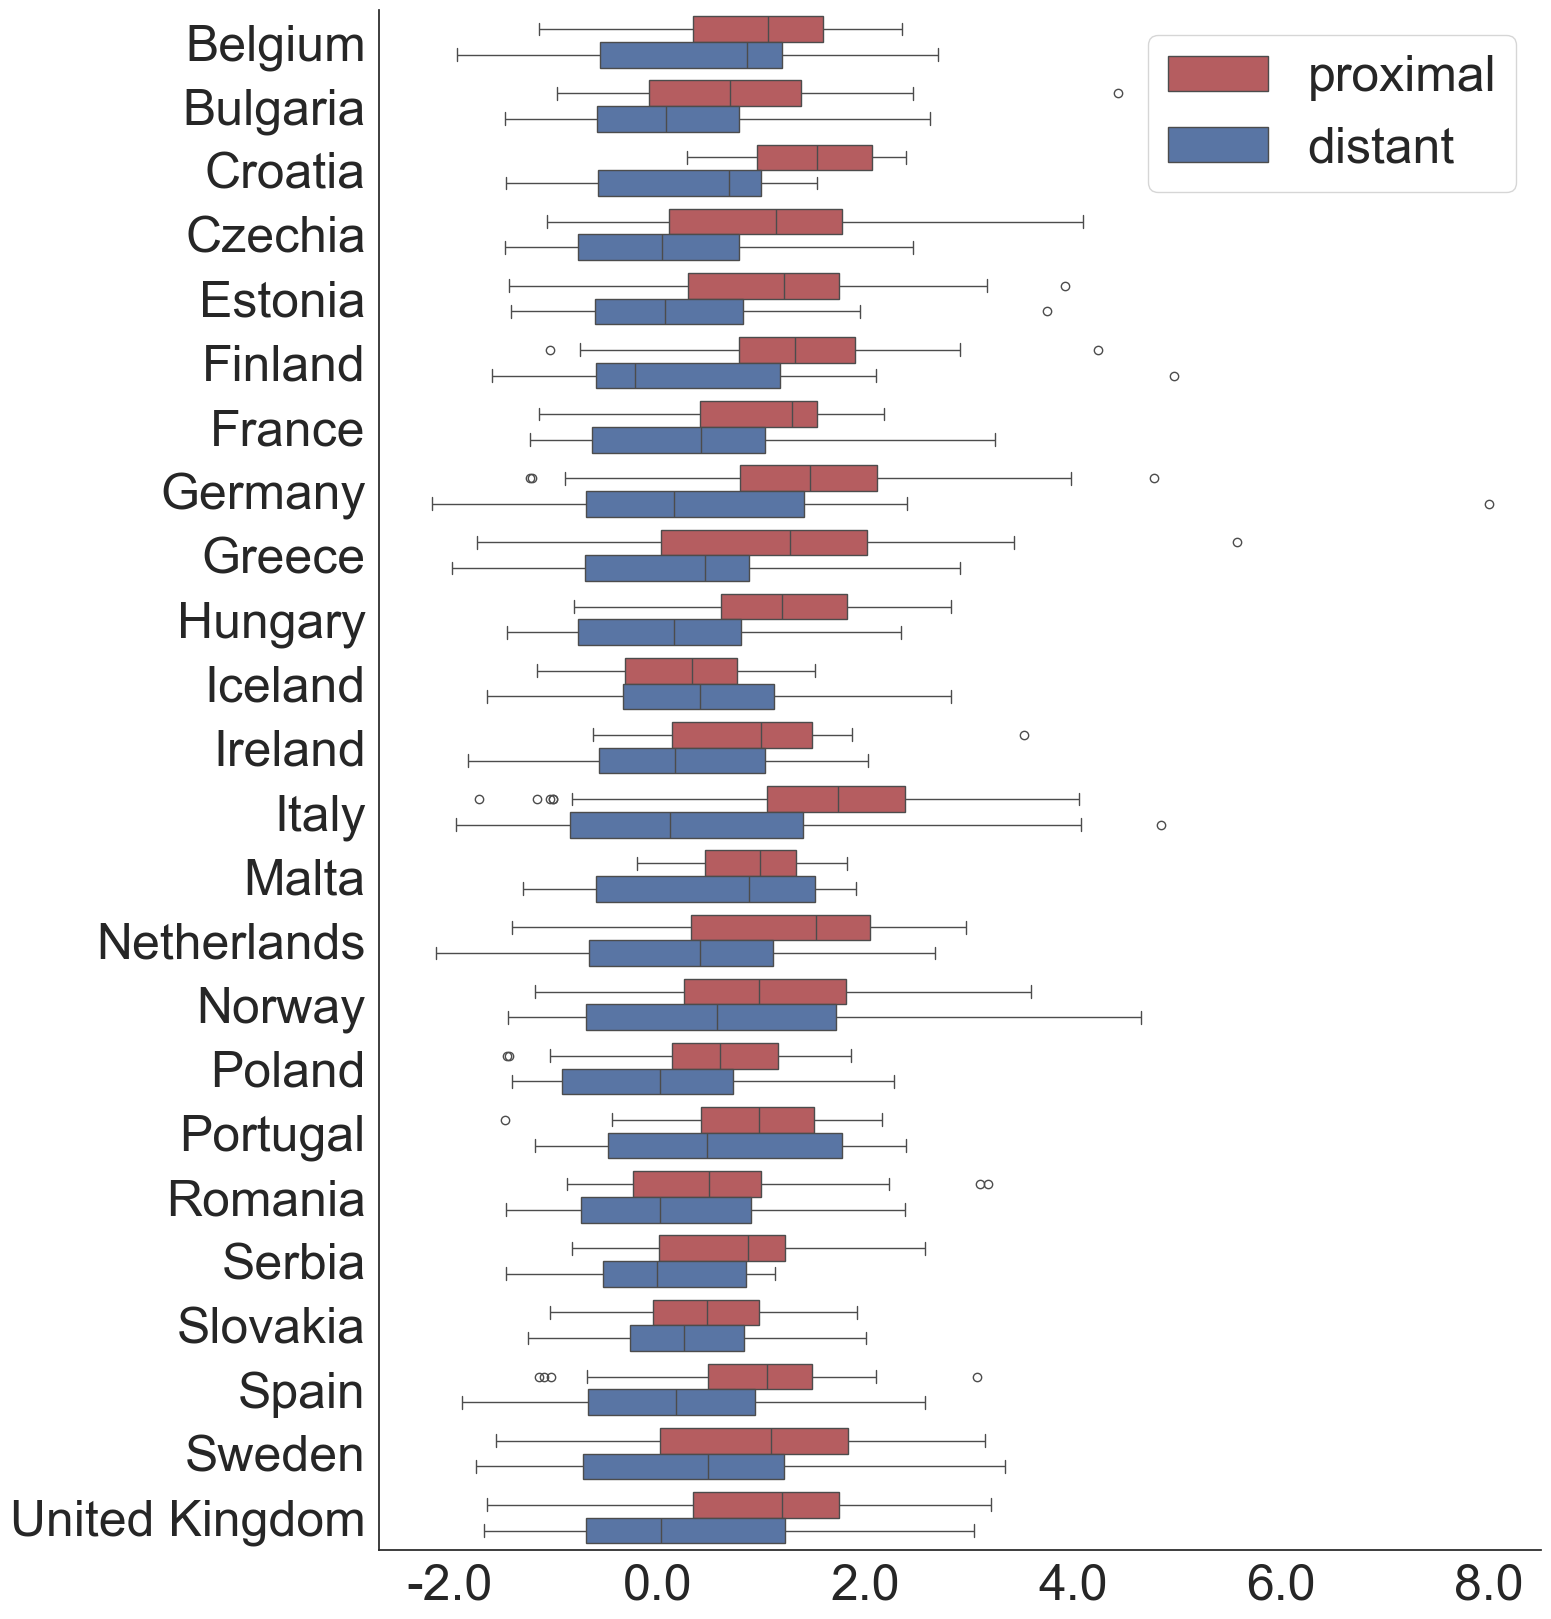

In [82]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
# Draw a nested boxplot to show bills by day and time
g=sns.boxplot(x="z-score", y="location",orient="h",
            hue="network_location", palette=["r","b"],order=my_order,
            data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)
#g.set_xscale("log")
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)
#plt.title('Incidence of network proximal and distant diseases to air polluted from 2000 to 2019', fontsize=25)
plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels(ax.get_xticks(), size = 36)

In [ ]:
#Let's test the difference between proximal and no-proximal (because with distant is kind of obvious and it doesn't
#make so much sense)
import scipy
for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
        

In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["r", "b"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')


plt.show()


In [83]:
#Prevalence

country_proximal_zscore_dict={}
for country,dis_dict in country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_prevalence[dis])
        std = np.std(proximal_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_prevalence[dis])
        std = np.std(distant_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(air_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))



Serbia 0.6534195721140563 0.2510169972715501 0.1145
Finland 1.439274472155152 0.4533261511795242 0.0004
Italy 1.7399102629118548 0.9955464008581164 0.0219
Spain 1.0689220911019066 0.5003303419054735 0.0055
Germany 1.7324600795507945 0.7008737171244596 0.001
Greece 1.1107513078802507 0.413563689759011 0.008
Romania 0.5436351916999763 0.17985362399032187 0.0295
Belgium 0.9373894253987936 0.5062785509673671 0.0566
Czechia 1.0564094686501557 0.24437197170909408 0.0002
United Kingdom 1.107356469076014 0.42575482161873723 0.006
Slovakia 0.4229445355766738 0.2983589166424932 0.3392
Bulgaria 0.7615045402889028 0.13650804545298684 0.0069
Hungary 1.1445421825453472 0.30605946596892075 0.0005
Netherlands 1.2550291537360123 0.24151254649725232 0.0006
Malta 0.8126384660949996 0.7007751375240765 0.4785
Croatia 1.3111676754465424 0.3913117638062667 0.0055
Estonia 1.204694828251655 0.25928111648031676 0.0003
France 0.9623043998998552 0.42703678300051895 0.012
Ireland 0.7424689804285551 0.1495442221624

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/133755012.py:21: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_prevalence[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF12A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()


In [84]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF18A_part1",
        index=False
    )

In [85]:
#mortality

country_proximal_zscore_dict={}
for country,dis_dict in country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_mortality[dis])
        std = np.std(proximal_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_mortality[dis])
        std = np.std(distant_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(air_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.5149628556682387 0.3567953578476822 0.2001
Finland 0.9210770423049187 0.3953428414915563 0.0301
Italy 1.1710972537095967 0.5239510089597733 0.0151
Spain 0.7639951619548618 0.28946445959535266 0.0204
Germany 1.2675174223487427 0.6948095452083062 0.017
Greece 0.9723314420168527 0.07052275591707262 0.0106
Romania 0.8535564862693508 0.22109832589350661 0.0186
Belgium 0.8905634045160387 0.5290185850003623 0.0802
Czechia 0.7848793591593796 0.1212724438521152 0.0099
United Kingdom 0.8777939579875581 0.4739325404736116 0.0504
Slovakia 0.30382405257009715 0.2336154134359699 0.4548
Bulgaria 1.3265541423941662 0.5422323090084674 0.0349
Hungary 1.5519647464513526 0.3674108519392115 0.0001
Netherlands 0.9326288795896001 0.5735766461057893 0.0377
Malta 0.7795969488348656 0.09060896397517701 0.0164
Croatia 1.490551962374477 0.3590017772895878 0.0008
Estonia 1.2988379014735847 0.21894500784795656 0.0008
France 0.9319539051822101 0.5628072064417862 0.0211
Ireland 0.499278519531925 -0.156453778

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2799601336.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2799601336.py:21: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF13A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [86]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF19A_part1",
        index=False
    )

In [87]:
#daly

country_proximal_zscore_dict={}
for country,dis_dict in country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_daly[dis])
        std = np.std(proximal_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_daly[dis])
        std = np.std(distant_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(air_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))



Serbia 0.5132231766798772 0.12281917885265718 0.1067
Finland 0.7720079365102528 0.33606011111939305 0.0514
Italy 0.9231933371580848 0.7307577371371858 0.0704
Spain 0.6359078878111232 0.5346399289715136 0.1337
Germany 0.8480501695091924 0.3631631031437548 0.0161
Greece 0.7807030616079181 0.22885157929771005 0.0175
Romania 0.7759523272934505 -0.009563216836614359 0.0005
Belgium 0.6057609694863071 0.2968332411923689 0.0557
Czechia 0.7405860153460477 -0.03045336078236412 0.0005
United Kingdom 0.7667494175750702 0.3308002681560541 0.0211
Slovakia 0.3124700331738663 0.04360227957256098 0.1919
Bulgaria 1.24071123566902 0.19887557683990945 0.0017
Hungary 1.4101960354474214 0.21814112428858703 0.0
Netherlands 0.7999110022613145 0.23710863481153746 0.0163
Malta 0.6557072602700507 0.19249876364715415 0.0395
Croatia 1.4453282778300212 0.1269169728538179 0.0001
Estonia 1.2204812011362278 0.19417806912267974 0.0002
France 0.5945737102844385 0.3799657615738881 0.1253
Ireland 0.4350281171138459 -0.006

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3414583971.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3414583971.py:21: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF14A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [88]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF20A_part1",
        index=False
    )

In [ ]:
#Low


In [90]:
#Proximal
low_country_selected_dis_mean_prox_dict = {}
for country,disset in low_country_selected_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(low_country_selected_chem_id_dict[country])>0:
            for chem in low_country_selected_chem_id_dict[country]:
                try:
                    z_list.append(real_significant_final_exp_proximity[chem,dis][1])
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)
                    
    low_country_selected_dis_mean_prox_dict[country] = dis_dict

low_country_selected_chem_id_gbd_dict = {}
for country,dis_dict in low_country_selected_dis_mean_prox_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([air_disgenet_gbd_dict[dis],z])
            except:
                pass
        low_country_selected_chem_id_gbd_dict[country] = dis_z_list

low_country_selected_chem_id_gbd_mean_dict = {}
for country,dislist in low_country_selected_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    low_country_selected_chem_id_gbd_mean_dict[country]=dis_dict

proximal_dis_list=[] 
for country, disdict in low_country_selected_chem_id_gbd_mean_dict.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list

proximal_dis_prevalence={}
for dis in set(proximal_dis_list):
    prevalence_list=[]
    for country in country_set:
        prevalence_list.append(country_dis_prevalence[country][dis])
    proximal_dis_prevalence[dis]=prevalence_list

proximal_dis_mortality={}
for dis in set(proximal_dis_list):
    mortality_list=[]
    for country in country_set:
        mortality_list.append(country_dis_mortality[country][dis])
    proximal_dis_mortality[dis]=mortality_list

proximal_dis_daly={}
for dis in set(proximal_dis_list):
    daly_list=[]
    for country in country_set:
        daly_list.append(country_dis_DALYs[country][dis])
    proximal_dis_daly[dis]=daly_list

low_country_proximal_zscore_dict={}
for country,dis_dict in low_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_incidence[dis])
        std = np.std(proximal_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        low_country_proximal_zscore_dict[country]=country_proximal_zscore_list



/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/1757315247.py:88: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [91]:
#Distant
low_country_selected_faraway_dis_dict={}
for country,chemset in low_country_selected_chem_id_dict.items():
    if len(chemset)>0:
        far_away_dis_set = []
        for chem in chemset:
            for chem_dis_pair in faraway_exp_dis_dict.keys():
                if chem in chem_dis_pair[0]:
                    far_away_dis_set.append(chem_dis_pair[1])
        low_country_selected_faraway_dis_dict[country] = set(far_away_dis_set)


low_country_faraway_dis_dict = {}
for country,dis_dict in low_country_selected_chem_id_gbd_mean_dict.items():
    chem_set = low_country_selected_chem_id_dict[country]
    country_faraway_dis_list = []
    country_specific_faraway_dis_dict = {}
    
    for dis in faraway_dis_list:
        if dis not in dis_dict.keys():
            country_faraway_dis_list.append(dis)
    for dis in country_faraway_dis_list:
        if dis not in faraway_manually_added_diseases:
            disgenet_name_list = []
            z_score_list = []
            for disgenet_name,gbd_id in n_long_faraway_air_disset_gbd_dict_cleaned.items():
                if dis == gbd_id:
                    disgenet_name_list.append(disgenet_name)
                    for chem in chem_set:
                        try:
                            z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                        except:
                            pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        elif dis=='Congenital heart anomalies':
            disgenet_name_list = ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon',
                                 'Congenital long QT syndrome']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        
        elif dis=='Congenital musculoskeletal and limb anomalies':
            disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                 'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                 'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                 'Congenital Fibrosis of the Extraocular Muscles']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
            
        elif dis=='Congenital birth defects':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Congenital' in dis or 'congenital' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)

        elif dis=='Turner syndrome':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Turner' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
    low_country_faraway_dis_dict[country] = country_specific_faraway_dis_dict

low_country_noprox_dis_dict = {}
for country,dis_dict in low_country_selected_chem_id_gbd_mean_dict.items():
    n_dis = len(dis_dict)
    chem_set = low_country_selected_chem_id_dict[country]
    country_noprox_dis_list = []
    country_specific_noprox_dis_dict = {}
    
    for gbd_dis,dislist in no_prox_air_disset_gbd_dict_cleaned_inv.items():
        if gbd_dis not in dis_dict.keys():
            if gbd_dis not in list(low_country_faraway_dis_dict[country].keys()):
                country_noprox_dis_list.append(gbd_dis)
    for dis in country_noprox_dis_list:
        disgenet_name_list = no_prox_air_disset_gbd_dict_cleaned_inv[dis]
        z_score_list = []
        for chem in chem_set:
            for disgenet_name in disgenet_name_list:
                try:
                    z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                except:
                    pass
        if np.mean(z_score_list)>-1.5:
            country_specific_noprox_dis_dict[dis]=np.mean(z_score_list)
    country_specific_noprox_dis_dict_sort = {k: v for k, v in sorted(country_specific_noprox_dis_dict.items(), key=lambda item: item[1])}
    
    if len(country_specific_noprox_dis_dict_sort)>n_dis:
        country_specific_noprox_dis_dict_sort_keys = list(country_specific_noprox_dis_dict_sort.keys())
        n_country_specific_noprox_dis_dict_sort = {}
        for k in list(country_specific_noprox_dis_dict_sort_keys)[:n_dis]:
            n_country_specific_noprox_dis_dict_sort[k]=country_specific_noprox_dis_dict_sort[k]
        
        low_country_noprox_dis_dict[country] = n_country_specific_noprox_dis_dict_sort
    else:
        low_country_noprox_dis_dict[country] = country_specific_noprox_dis_dict_sort

#Let's just merge the no-proximal dictionary and the faraway dictionary
new_low_country_distant_dis_dict = {}
for country,dis_dict in low_country_selected_chem_id_gbd_mean_dict.items():
    n_proxdis = len(dis_dict)
    n_distantdis = len(low_country_faraway_dis_dict[country])
    noprox_list = list(low_country_noprox_dis_dict[country].keys())
    missing_dis = n_proxdis-n_distantdis
    try:
        dislist = noprox_list[:missing_dis]
        distant_dict = low_country_faraway_dis_dict[country].copy()
        for dis in dislist:
            distant_dict[dis] = low_country_noprox_dis_dict[country][dis]
        new_low_country_distant_dis_dict[country] = distant_dict
    except:
        distant_dict = {**low_country_faraway_dis_dict[country], **low_country_noprox_dis_dict[country]}
        new_low_country_distant_dis_dict[country] = distant_dict

distant_dis_list=[] 
for country, disdict in new_low_country_distant_dis_dict.items():
    distant_dis_list.extend(list(disdict.keys()))
    
distant_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(distant_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    distant_dis_incidence[dis]=incidence_list
   
distant_dis_prevalence={}
for dis in set(distant_dis_list):
    prevalence_list=[]
    for country in country_set:
        prevalence_list.append(country_dis_prevalence[country][dis])
    distant_dis_prevalence[dis]=prevalence_list

distant_dis_mortality={}
for dis in set(distant_dis_list):
    mortality_list=[]
    for country in country_set:
        mortality_list.append(country_dis_mortality[country][dis])
    distant_dis_mortality[dis]=mortality_list

distant_dis_daly={}
for dis in set(distant_dis_list):
    daly_list=[]
    for country in country_set:
        daly_list.append(country_dis_DALYs[country][dis])
    distant_dis_daly[dis]=daly_list
air_low_country_distant_zscore_dict={}

for country,dis_dict in new_low_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_incidence[dis])
        std = np.std(distant_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_low_country_distant_zscore_dict[country]=country_distant_zscore_list

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2133740425.py:182: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [69]:
air_pollution_low_zscore_df = pd.DataFrame()

selected_countries=set(low_country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_low_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in low_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_low_zscore_df['location']=tot_country_list
air_pollution_low_zscore_df['z-score']=tot_zscore_list
air_pollution_low_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_low_zscore_df['location'])))

In [70]:
#Let's test the difference between proximal and no-proximal (because with distant is kind of obvious and it doesn't
#make so much sense)
import scipy
for country in low_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in low_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_low_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
        

Cyprus 0.5538965625733642 0.03900720980661834 0.0633
Serbia 0.7548697026544875 0.14866025870230923 0.0176
Finland 1.1624088410437994 0.34401983513971346 0.0019
Italy 1.5362635455917664 0.5531875673836243 0.0029
Spain 0.9811408536839265 0.1950178884792146 0.0018
Germany 1.4350390293940236 0.500337017218557 0.0004
Greece 1.0639801785177319 0.3364821817016025 0.0172
Denmark 1.1086743493718199 0.5187379318483041 0.0372
Romania 0.4946382303837726 0.2378091032450263 0.1891
Belgium 0.9218295252532657 0.2555105288482595 0.008
Czechia 1.0312062965417026 0.09690268550660026 0.0004
United Kingdom 1.0706408218396875 0.22328644450899823 0.0012
Switzerland 1.0160460454184357 0.09644634455842123 0.0056
Slovakia 0.4398604030477871 0.33152746866535726 0.4085
Bulgaria 0.7698297412559224 0.1957476430780704 0.0211
Hungary 1.142103182685472 0.06771770788288183 0.0001
Netherlands 1.1111768480972368 0.22057772688044472 0.0011
Malta 0.8784134881053345 0.5417890446992645 0.2873
Croatia 1.4728264390485355 0.256

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3977161258.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size=36)


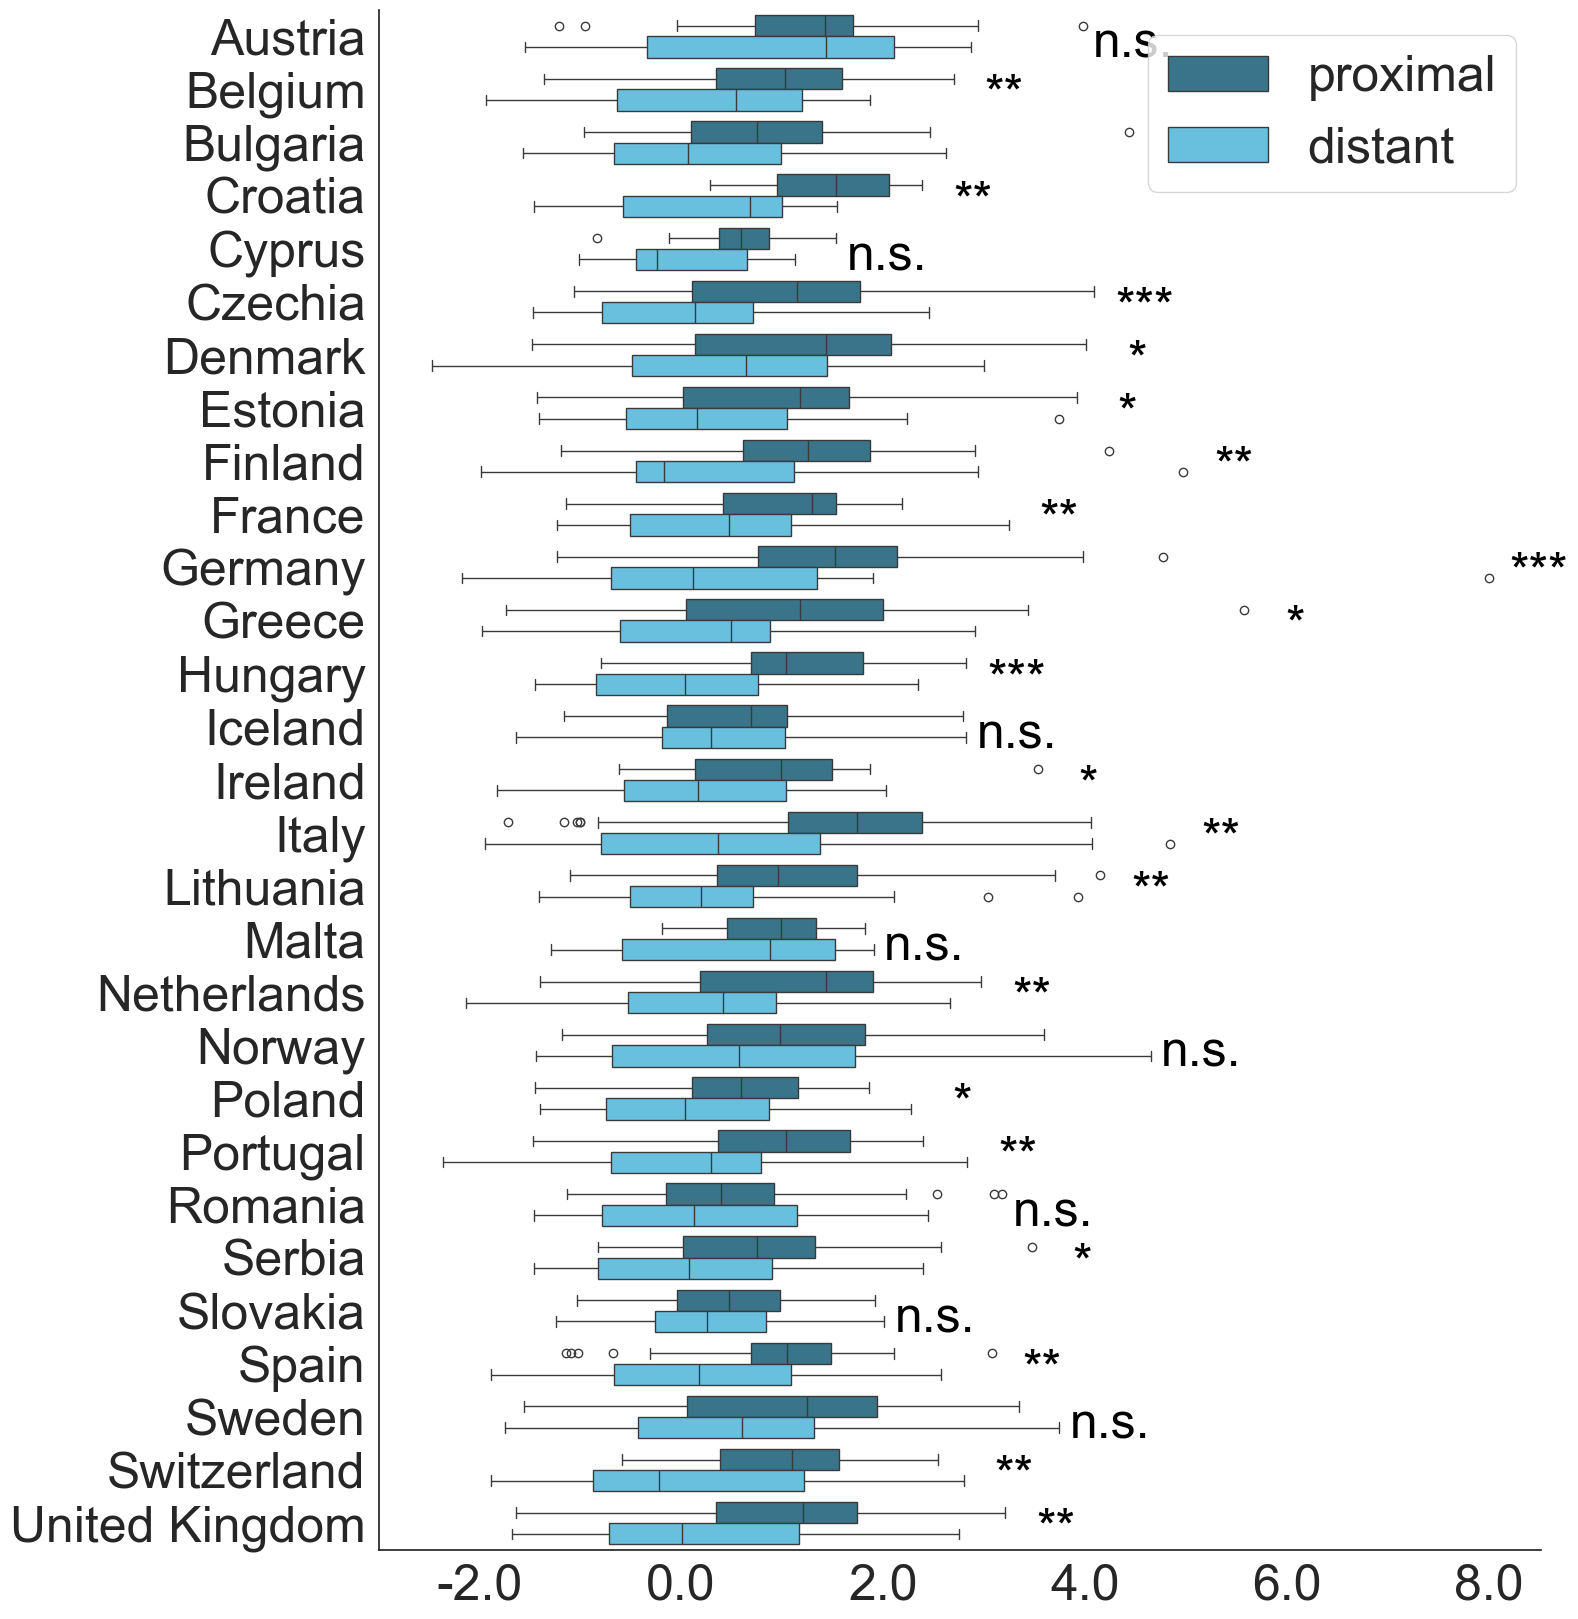

In [71]:
import scipy 
# Assuming your data loading and plot setup code here

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_low_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

# Example of adding significance stars between two boxplots
# Let's assume you've got p-values and locations. You'll
# Placeholder list of p-values, x (z-score) and y (location) coordinates for the text, and the text to be added (stars).
# You need to calculate these based on your actual data and tests.
pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in low_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_low_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    # This part is tricky without the data; you need to find the specific y coordinates for your boxplots.
    # A simplistic approach:
    yloc = my_order.index(loc) + 0.4  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(air_pollution_low_zscore_df[air_pollution_low_zscore_df['location'] == loc]['z-score']) + 0.5  
  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')
#plt.savefig('output/Figures/SF11A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()


In [72]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_low_zscore_df.to_excel(
        writer,
        sheet_name="SF17A",
        index=False
    )

In [73]:
#Prevalence

country_proximal_zscore_dict={}
for country,dis_dict in low_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_prevalence[dis])
        std = np.std(proximal_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_low_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_prevalence[dis])
        std = np.std(distant_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))



Cyprus 0.46785963302173583 0.15406501208250922 0.178
Serbia 0.6456927058967522 0.24512393433047988 0.0276
Finland 1.3655818301412839 0.4650668114379678 0.0003
Italy 1.7399102629118548 1.033705491506799 0.0289
Spain 1.0863328787597142 0.5337078377630234 0.0079
Germany 1.6834768534999112 0.6560793300107159 0.0007
Greece 1.0822771857566353 0.41177370996469126 0.0082
Denmark 1.1110011169563005 0.5880050120915439 0.0483
Romania 0.5131015030158801 0.2991198473142807 0.0935
Belgium 0.9773131031064758 0.4157636190118925 0.0232
Czechia 1.0564094686501557 0.24122372953816848 0.0003
United Kingdom 1.107356469076014 0.345721090240839 0.0026
Switzerland 1.1499808960865958 0.10782130633483772 0.0004
Slovakia 0.4229445355766738 0.2983589166424932 0.3392
Bulgaria 0.7314326366243724 0.18746151375495207 0.0104
Hungary 1.1499186616762807 0.2091996240210922 0.0
Netherlands 1.1490355054329147 0.25044218595277407 0.0008
Malta 0.8126384660949996 0.7007751375240765 0.4785
Croatia 1.3111676754465424 0.39131176

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/1894529228.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_prevalence[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF12B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()


In [74]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF18A_part2",
        index=False
    )

In [92]:
#mortality

country_proximal_zscore_dict={}
for country,dis_dict in low_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_mortality[dis])
        std = np.std(proximal_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_low_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_mortality[dis])
        std = np.std(distant_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Cyprus 0.24841883221752092 -0.22705499120730044 0.0549
Serbia 1.0200011206376551 0.39214044276748267 0.0255
Finland 0.8574824432808792 0.26053407900672876 0.0253
Italy 1.1710972537095967 0.5518570985146612 0.0149
Spain 0.775281513629088 0.24832757125402594 0.0071
Germany 1.2227672364758237 0.6785317766849923 0.0186
Greece 0.9434024965447102 0.04733565160311251 0.0075
Denmark 1.2892421361679938 0.7422321223602713 0.0562
Romania 0.7609117902965543 0.2730669193024161 0.0433
Belgium 0.8783320136381333 0.47751995381392537 0.0531
Czechia 0.7848793591593796 0.09720016467826885 0.0089
United Kingdom 0.8777939579875581 0.25235873198337155 0.0191
Switzerland 0.8030799602643048 -0.27724763024584276 0.0002
Slovakia 0.30382405257009715 0.2336154134359699 0.4548
Bulgaria 1.2329606600188319 0.47222384883881663 0.0199
Hungary 1.431223666466051 0.2959786618154709 0.0002
Netherlands 0.817301218044835 0.532042065104225 0.0587
Malta 0.7795969488348656 0.09060896397517701 0.0164
Croatia 1.490551962374477 0

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3380992812.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3380992812.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF13B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [93]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF19A_part2",
        index=False
    )

In [94]:
#daly

country_proximal_zscore_dict={}
for country,dis_dict in low_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_daly[dis])
        std = np.std(proximal_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_low_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_daly[dis])
        std = np.std(distant_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))



Cyprus 0.16023450261808003 -0.28524289605308645 0.0559
Serbia 0.8762116881786404 0.06389648623295902 0.0008
Finland 0.7340179989725653 0.3695918443357704 0.0604
Italy 0.9231933371580848 0.7550842609471627 0.0906
Spain 0.6052699444442361 0.538802167350629 0.1503
Germany 0.8618610264799956 0.30449525548070394 0.0089
Greece 0.7505353914857991 0.2000063175672342 0.016
Denmark 0.8701846145378126 0.4695159948806014 0.0681
Romania 0.6394048532740395 0.03167147022803506 0.0017
Belgium 0.6548544076788546 0.20501967745243377 0.0183
Czechia 0.7405860153460478 -0.06182149712628695 0.0003
United Kingdom 0.7667494175750702 0.2279605431326029 0.0104
Switzerland 0.5710610884539761 -0.18077074248678687 0.0005
Slovakia 0.3124700331738663 0.04360227957256098 0.1919
Bulgaria 1.1294775501296928 0.13178994543649256 0.0006
Hungary 1.3087432658406577 0.12862512241982416 0.0
Netherlands 0.6828937009783992 0.23493834134574323 0.0357
Malta 0.6557072602700507 0.19249876364715415 0.0395
Croatia 1.4453282778300212 

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/1665762806.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF14B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [95]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF20A_part2",
        index=False
    )

In [ ]:
#HIGH


In [96]:
#Proximal
high_country_selected_dis_mean_prox_dict = {}
for country,disset in high_country_selected_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(high_country_selected_chem_id_dict[country])>0:
            for chem in high_country_selected_chem_id_dict[country]:
                try:
                    z_list.append(real_significant_final_exp_proximity[chem,dis][1])
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)
                    
    high_country_selected_dis_mean_prox_dict[country] = dis_dict

high_country_selected_chem_id_gbd_dict = {}
for country,dis_dict in high_country_selected_dis_mean_prox_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([air_disgenet_gbd_dict[dis],z])
            except:
                pass
        high_country_selected_chem_id_gbd_dict[country] = dis_z_list

high_country_selected_chem_id_gbd_mean_dict = {}
for country,dislist in high_country_selected_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    high_country_selected_chem_id_gbd_mean_dict[country]=dis_dict

proximal_dis_list=[] 
for country, disdict in high_country_selected_chem_id_gbd_mean_dict.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list

proximal_dis_prevalence={}
for dis in set(proximal_dis_list):
    prevalence_list=[]
    for country in country_set:
        prevalence_list.append(country_dis_prevalence[country][dis])
    proximal_dis_prevalence[dis]=prevalence_list

proximal_dis_mortality={}
for dis in set(proximal_dis_list):
    mortality_list=[]
    for country in country_set:
        mortality_list.append(country_dis_mortality[country][dis])
    proximal_dis_mortality[dis]=mortality_list

proximal_dis_daly={}
for dis in set(proximal_dis_list):
    daly_list=[]
    for country in country_set:
        daly_list.append(country_dis_DALYs[country][dis])
    proximal_dis_daly[dis]=daly_list


high_country_proximal_zscore_dict={}
for country,dis_dict in high_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_incidence[dis])
        std = np.std(proximal_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        high_country_proximal_zscore_dict[country]=country_proximal_zscore_list


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3203285023.py:89: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [97]:
#Distant
high_country_selected_faraway_dis_dict={}
for country,chemset in high_country_selected_chem_id_dict.items():
    if len(chemset)>0:
        far_away_dis_set = []
        for chem in chemset:
            for chem_dis_pair in faraway_exp_dis_dict.keys():
                if chem in chem_dis_pair[0]:
                    far_away_dis_set.append(chem_dis_pair[1])
        high_country_selected_faraway_dis_dict[country] = set(far_away_dis_set)


high_country_faraway_dis_dict = {}
for country,dis_dict in high_country_selected_chem_id_gbd_mean_dict.items():
    chem_set = high_country_selected_chem_id_dict[country]
    country_faraway_dis_list = []
    country_specific_faraway_dis_dict = {}
    
    for dis in faraway_dis_list:
        if dis not in dis_dict.keys():
            country_faraway_dis_list.append(dis)
    for dis in country_faraway_dis_list:
        if dis not in faraway_manually_added_diseases:
            disgenet_name_list = []
            z_score_list = []
            for disgenet_name,gbd_id in n_long_faraway_air_disset_gbd_dict_cleaned.items():
                if dis == gbd_id:
                    disgenet_name_list.append(disgenet_name)
                    for chem in chem_set:
                        try:
                            z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                        except:
                            pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        elif dis=='Congenital heart anomalies':
            disgenet_name_list = ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon',
                                 'Congenital long QT syndrome']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        
        elif dis=='Congenital musculoskeletal and limb anomalies':
            disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                 'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                 'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                 'Congenital Fibrosis of the Extraocular Muscles']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
            
        elif dis=='Congenital birth defects':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Congenital' in dis or 'congenital' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)

        elif dis=='Turner syndrome':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Turner' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
    high_country_faraway_dis_dict[country] = country_specific_faraway_dis_dict

high_country_noprox_dis_dict = {}
for country,dis_dict in high_country_selected_chem_id_gbd_mean_dict.items():
    n_dis = len(dis_dict)
    chem_set = high_country_selected_chem_id_dict[country]
    country_noprox_dis_list = []
    country_specific_noprox_dis_dict = {}
    
    for gbd_dis,dislist in no_prox_air_disset_gbd_dict_cleaned_inv.items():
        if gbd_dis not in dis_dict.keys():
            if gbd_dis not in list(high_country_faraway_dis_dict[country].keys()):
                country_noprox_dis_list.append(gbd_dis)
    for dis in country_noprox_dis_list:
        disgenet_name_list = no_prox_air_disset_gbd_dict_cleaned_inv[dis]
        z_score_list = []
        for chem in chem_set:
            for disgenet_name in disgenet_name_list:
                try:
                    z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                except:
                    pass
        if np.mean(z_score_list)>-1.5:
            country_specific_noprox_dis_dict[dis]=np.mean(z_score_list)
    country_specific_noprox_dis_dict_sort = {k: v for k, v in sorted(country_specific_noprox_dis_dict.items(), key=lambda item: item[1])}
    
    if len(country_specific_noprox_dis_dict_sort)>n_dis:
        country_specific_noprox_dis_dict_sort_keys = list(country_specific_noprox_dis_dict_sort.keys())
        n_country_specific_noprox_dis_dict_sort = {}
        for k in list(country_specific_noprox_dis_dict_sort_keys)[:n_dis]:
            n_country_specific_noprox_dis_dict_sort[k]=country_specific_noprox_dis_dict_sort[k]
        
        high_country_noprox_dis_dict[country] = n_country_specific_noprox_dis_dict_sort
    else:
        high_country_noprox_dis_dict[country] = country_specific_noprox_dis_dict_sort

#Let's just merge the no-proximal dictionary and the faraway dictionary
new_high_country_distant_dis_dict = {}
for country,dis_dict in high_country_selected_chem_id_gbd_mean_dict.items():
    n_proxdis = len(dis_dict)
    n_distantdis = len(high_country_faraway_dis_dict[country])
    noprox_list = list(high_country_noprox_dis_dict[country].keys())
    missing_dis = n_proxdis-n_distantdis
    try:
        dislist = noprox_list[:missing_dis]
        distant_dict = high_country_faraway_dis_dict[country].copy()
        for dis in dislist:
            distant_dict[dis] = high_country_noprox_dis_dict[country][dis]
        new_high_country_distant_dis_dict[country] = distant_dict
    except:
        distant_dict = {**high_country_faraway_dis_dict[country], **high_country_noprox_dis_dict[country]}
        new_high_country_distant_dis_dict[country] = distant_dict

distant_dis_list=[] 
for country, disdict in new_high_country_distant_dis_dict.items():
    distant_dis_list.extend(list(disdict.keys()))
    
distant_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(distant_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    distant_dis_incidence[dis]=incidence_list
  
distant_dis_prevalence={}
for dis in set(distant_dis_list):
     prevalence_list=[]
     for country in country_set:
         prevalence_list.append(country_dis_prevalence[country][dis])
     distant_dis_prevalence[dis]=prevalence_list

distant_dis_mortality={}
for dis in set(distant_dis_list):
     mortality_list=[]
     for country in country_set:
         mortality_list.append(country_dis_mortality[country][dis])
     distant_dis_mortality[dis]=mortality_list

distant_dis_daly={}
for dis in set(distant_dis_list):
     daly_list=[]
     for country in country_set:
         daly_list.append(country_dis_DALYs[country][dis])
     distant_dis_daly[dis]=daly_list

air_high_country_distant_zscore_dict={}

for country,dis_dict in new_high_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_incidence[dis])
        std = np.std(distant_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_high_country_distant_zscore_dict[country]=country_distant_zscore_list

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3599022792.py:183: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [98]:
air_pollution_high_zscore_df = pd.DataFrame()

selected_countries=set(high_country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_high_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in high_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_high_zscore_df['location']=tot_country_list
air_pollution_high_zscore_df['z-score']=tot_zscore_list
air_pollution_high_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_high_zscore_df['location'])))

In [ ]:
#Let's test the difference between proximal and no-proximal (because with distant is kind of obvious and it doesn't
#make so much sense)
import scipy
for country in high_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in high_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_high_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
        

In [ ]:
import scipy 
# Assuming your data loading and plot setup code here

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_high_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  
for country in my_order:
    proximallist_cleaned = [x for x in high_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_high_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_high_zscore_df[air_pollution_high_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')
    
plt.savefig('output/Figures/SF11B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [99]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_high_zscore_df.to_excel(
        writer,
        sheet_name="SF17B",
        index=False
    )

In [100]:
#Prevalence

country_proximal_zscore_dict={}
for country,dis_dict in high_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_prevalence[dis])
        std = np.std(proximal_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_high_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_prevalence[dis])
        std = np.std(distant_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))



Italy 2.1001734764465514 0.9404691981689391 0.0075
Spain 1.0793910866981877 0.5691253485002707 0.0236
Germany 1.6510668537137576 0.5183780463821154 0.0032
Greece 1.2428760513885613 0.33865320743100397 0.0013
Belgium 1.0990411479690523 0.49237404178821026 0.0238
Czechia 1.0621904738018775 0.21282226487122144 0.0093
United Kingdom 1.1212840191338098 0.4363935100902048 0.0067
Bulgaria 0.7275621358099178 0.04278836495395987 0.0049
Hungary 1.195118029316895 0.12838176797754922 0.0097
Estonia 1.239463221152131 0.49478683794186706 0.0034
France 1.063060350828153 0.41569698905997554 0.0014
Ireland 0.7424689804285551 0.14954422216246202 0.0253
Portugal 0.7659449651291969 0.37349805121996393 0.0559
Norway 1.1454079862227369 0.757898271651639 0.0535
Poland 0.6499579301181004 0.1962175607633644 0.013
Iceland 0.39336728254848 0.5871956531278182 0.6142
Sweden 1.1922345380797903 0.35204442320994295 0.0243


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2040041325.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_prevalence[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF12C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()


In [101]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF18A_part3",
        index=False
    )

In [102]:
#mortality

country_proximal_zscore_dict={}
for country,dis_dict in high_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_mortality[dis])
        std = np.std(proximal_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_high_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_mortality[dis])
        std = np.std(distant_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Italy 1.3504015051587153 0.6612127371973433 0.0203
Spain 0.8185331406495957 0.3288475475665083 0.0281
Germany 1.2072714966578106 0.8259835653703684 0.0555
Greece 1.0750510118812762 0.057330037608629945 0.0038
Belgium 1.1072301889416258 0.6089449155679074 0.0367
Czechia 0.8654035256362103 -0.17268923270093622 0.001
United Kingdom 0.8678853171328506 0.6907169521587562 0.1237
Bulgaria 1.1985354002219402 0.4233636306514128 0.0398
Hungary 1.366810730833459 0.4897540011056378 0.1055
Estonia 1.4935863841046286 0.366006246147725 0.0005
France 1.0524029348671298 0.44512323098256223 0.0022
Ireland 0.499278519531925 -0.15645377845925068 0.0073
Portugal 1.0261634722441733 0.1284211971477227 0.0008
Norway 0.6950338058925992 -0.12605813434829363 0.01
Poland 0.9082331328983494 0.365884624814143 0.0313
Iceland -0.21376967397164529 0.3370761813041679 0.9439
Sweden 1.2535170167370435 -0.22591243284645982 0.0047


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/216185522.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/216185522.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF13C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [103]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF19A_part3",
        index=False
    )

In [104]:
#daly

country_proximal_zscore_dict={}
for country,dis_dict in high_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_daly[dis])
        std = np.std(proximal_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        country_proximal_zscore_dict[country]=country_proximal_zscore_list

air_country_distant_zscore_dict={}
for country,dis_dict in new_high_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_daly[dis])
        std = np.std(distant_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list

air_pollution_zscore_df = pd.DataFrame()
selected_countries=set(country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(air_pollution_zscore_df['location'])))

for country in country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))



Italy 1.1073586296988647 0.5743344897645443 0.0344
Spain 0.6187126089526156 0.5667985921381669 0.2219
Germany 0.8272129048172486 0.4078652303418473 0.0382
Greece 0.8827296778931681 0.22531114029955412 0.0068
Belgium 0.7575667393436804 0.2771725368427873 0.0227
Czechia 0.885449211444199 -0.11970174624854074 0.0022
United Kingdom 0.7639880999289653 0.47359083387189055 0.0746
Bulgaria 1.2544063508858576 0.08651696180434675 0.0011
Hungary 1.4008660870434542 0.08024900997478673 0.0071
Estonia 1.412309175698408 0.3973911695137766 0.0003
France 0.6855568679485523 0.30038471771397757 0.0278
Ireland 0.4350281171138459 -0.0061823346002135215 0.0306
Portugal 0.7609953571034919 0.1639979297829816 0.0062
Norway 0.48722623794586756 0.37211788194641987 0.2341
Poland 0.7605325672111463 0.05082293687924407 0.0022
Iceland -0.2493076869115436 0.4375968375421756 0.8933
Sweden 0.8397170184077097 0.15284734293541713 0.0404


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/561908209.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/561908209.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  
locations = []  
stars = []  

for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4 
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SF14C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [105]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    air_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF20A_part3",
        index=False
    )

### Water

In [106]:
water_chem_name_conversion_dict = air_chem_name_conversion_dict.copy()

#Let's add the chemicals that are only in the water and not in the air
water_chem_name_conversion_dict['Triphenyltin and compounds'] = 'C030665'
water_chem_name_conversion_dict['Isoproturon'] = 'C028904'
water_chem_name_conversion_dict['Mirex'] = 'D008917'
water_chem_name_conversion_dict['Hexachlorobutadiene'] = 'C001335'
water_chem_name_conversion_dict['Heptachlor'] = 'D006533'

water_chem_name_conversion_dict['Diuron'] = 'D004237'
water_chem_name_conversion_dict['Chlorpyrifos'] = 'D004390'
water_chem_name_conversion_dict['Fluoranthene'] = 'C007738'
water_chem_name_conversion_dict['Toxaphene'] = 'D014112'
water_chem_name_conversion_dict['Halogenated organic compounds (as AOX)'] = 'D006846'

water_chem_name_conversion_dict['Simazine'] = 'D012839'
water_chem_name_conversion_dict['Atrazine'] = 'D001280'
water_chem_name_conversion_dict['Total nitrogen'] = 'D009584'
water_chem_name_conversion_dict['Dieldrin'] = 'D004026'
water_chem_name_conversion_dict['Chlordane'] = 'D002706'


water_chem_name_conversion_dict['Alachlor'] = 'C000188'
water_chem_name_conversion_dict['Chlorides'] = 'D002712'
water_chem_name_conversion_dict['DDT (DDT)'] = 'D003634'
water_chem_name_conversion_dict['Tributyltin and compounds'] = 'C011559'
water_chem_name_conversion_dict['Chlorfenvinphos'] = 'D002709'


water_chem_name_conversion_dict['Endrin'] = 'D004732'
water_chem_name_conversion_dict['Organotin compounds (as total Sn)'] = 'D009947'
water_chem_name_conversion_dict['1,2,3,4,5,6-hexachlorocyclohexane (HCH)'] = 'D001556'
water_chem_name_conversion_dict['Trifluralin'] = 'D014274'
water_chem_name_conversion_dict['Cyanides (as total CN)'] = 'D003486'

In [107]:
#Let's import the WHO data at a national level
#water
who_water_nation=pd.read_excel("input/WHO/F2_1_Total Releases at National Level into Water.xlsx",sheet_name=0)

In [108]:

country_set=set(who_water_nation['countryName'].tolist())
years=list(range(2007,2020))
country_chem_conc_water={}
for c in country_set:
    chem_concentration_dict={}
    for i,v in who_water_nation[who_water_nation['countryName']==c].iterrows():
        concentration=[]
        for y in years:
            concentration.append(v[y])
        concentration_clenaed=[x for x in concentration if str(x) != 'nan']
        chem_concentration_dict[v['pollutant']]=concentration_clenaed
    country_chem_conc_water[c]=chem_concentration_dict

In [109]:
country_chem_conc_mean_water_dict={}
for c,chem_con in country_chem_conc_water.items():
    chem_mean_dict={}
    for chem,con_list in chem_con.items():
        chem_mean_dict[chem]=mean_list(con_list)
    country_chem_conc_mean_water_dict[c]=chem_mean_dict

In [110]:
chem_set=set(who_water_nation['pollutant'].tolist())

chem_across_countries_water_dict={}
for chem in chem_set:
    chem_median_across_countries_list=[]
    for c in country_set:
        try:
            chem_median_across_countries_list.append(country_chem_conc_mean_water_dict[c][chem])
        except:
            pass
    chem_across_countries_water_dict[chem]=chem_median_across_countries_list
    


In [111]:
#If a chemical compound is express only in less than 4 countries then is considered as specific for that country. 
#Otherwise the concentration in that country should be > 75* percentile of the average concentration distribution across all countries
import statistics

water_country_selected_chem_dict={}

for country, chem_avgcon_dict in country_chem_conc_mean_water_dict.items():
    chem_list=[]
    for chem, avg_con_list in chem_across_countries_water_dict.items():
        if chem in chem_avgcon_dict.keys():
            if len(avg_con_list)>4:
                cutoff=np.percentile(avg_con_list,75)
                if chem_avgcon_dict[chem]>cutoff:
                    chem_list.append(chem)
            else:
                chem_list.append(chem)
    water_country_selected_chem_dict[country]=chem_list


water_low_country_selected_chem_dict={}

for country, chem_avgcon_dict in country_chem_conc_mean_water_dict.items():
    chem_list=[]
    for chem, avg_con_list in chem_across_countries_water_dict.items():
        if chem in chem_avgcon_dict.keys():
            if len(avg_con_list)>4:
                cutoff=np.percentile(avg_con_list,50)
                if chem_avgcon_dict[chem]>cutoff:
                    chem_list.append(chem)
            else:
                chem_list.append(chem)
    water_low_country_selected_chem_dict[country]=chem_list

water_high_country_selected_chem_dict={}

for country, chem_avgcon_dict in country_chem_conc_mean_water_dict.items():
    chem_list=[]
    for chem, avg_con_list in chem_across_countries_water_dict.items():
        if chem in chem_avgcon_dict.keys():
            if len(avg_con_list)>4:
                cutoff=np.percentile(avg_con_list,95)
                if chem_avgcon_dict[chem]>cutoff:
                    chem_list.append(chem)
            else:
                chem_list.append(chem)
    water_high_country_selected_chem_dict[country]=chem_list

In [112]:
water_country_selected_chem_id_dict={}
for country,chem_list in water_country_selected_chem_dict.items():
    id_chem_list=[]
    for chem in chem_list:
        try:
            if chem!='PCDD + PCDF (dioxins + furans) (as Teq)':   
                if water_chem_name_conversion_dict[chem] in chem_id_list:
                    id_chem_list.append(water_chem_name_conversion_dict[chem])
            else:
                if 'D005663' in chem_id_list:
                    id_chem_list.append('D005663')
                if 'D000072316' in chem_id_list:
                    id_chem_list.append('D000072316')
                if 'D004147' in chem_id_list:
                    id_chem_list.append('D004147')
        except:
            pass
    water_country_selected_chem_id_dict[country]=set(id_chem_list)

water_low_country_selected_chem_id_dict={}
for country,chem_list in water_low_country_selected_chem_dict.items():
    id_chem_list=[]
    for chem in chem_list:
        try:
            if chem!='PCDD + PCDF (dioxins + furans) (as Teq)':   
                if water_chem_name_conversion_dict[chem] in chem_id_list:
                    id_chem_list.append(water_chem_name_conversion_dict[chem])
            else:
                if 'D005663' in chem_id_list:
                    id_chem_list.append('D005663')
                if 'D000072316' in chem_id_list:
                    id_chem_list.append('D000072316')
                if 'D004147' in chem_id_list:
                    id_chem_list.append('D004147')
        except:
            pass
    water_low_country_selected_chem_id_dict[country]=set(id_chem_list)

water_high_country_selected_chem_id_dict={}
for country,chem_list in water_high_country_selected_chem_dict.items():
    id_chem_list=[]
    for chem in chem_list:
        try:
            if chem!='PCDD + PCDF (dioxins + furans) (as Teq)':   
                if water_chem_name_conversion_dict[chem] in chem_id_list:
                    id_chem_list.append(water_chem_name_conversion_dict[chem])
            else:
                if 'D005663' in chem_id_list:
                    id_chem_list.append('D005663')
                if 'D000072316' in chem_id_list:
                    id_chem_list.append('D000072316')
                if 'D004147' in chem_id_list:
                    id_chem_list.append('D004147')
        except:
            pass
    water_high_country_selected_chem_id_dict[country]=set(id_chem_list)

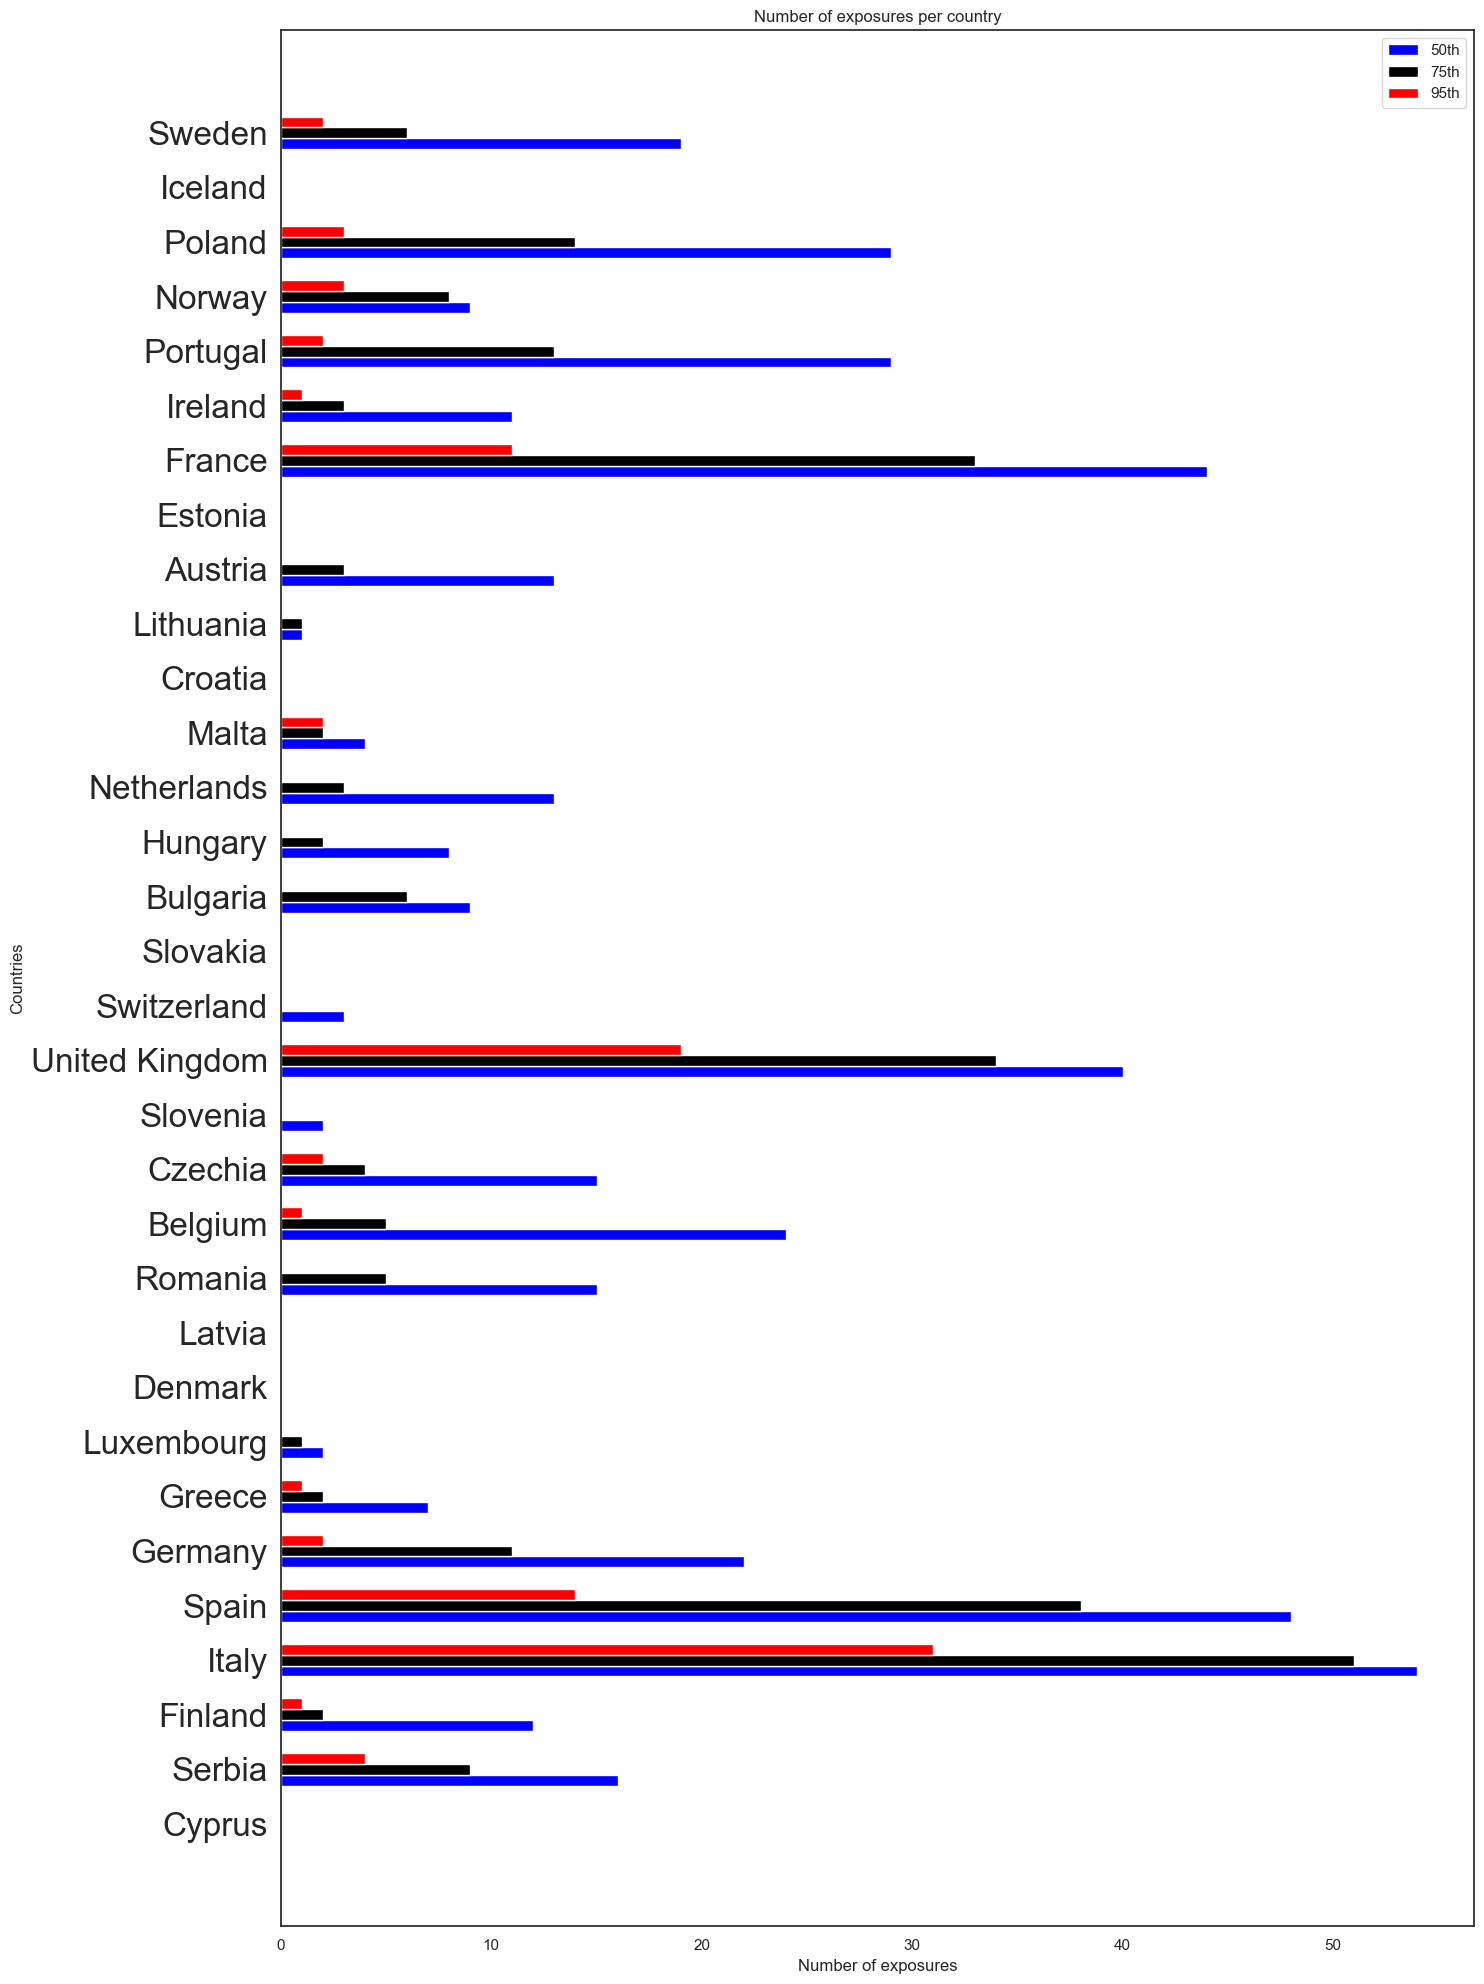

In [113]:

water_low_country_selected_chem_num_dict = {}
for country, chemlist in water_low_country_selected_chem_id_dict.items():
    water_low_country_selected_chem_num_dict[country] = len(chemlist)

water_country_selected_chem_num_dict = {}
for country, chemlist in water_country_selected_chem_id_dict.items():
    water_country_selected_chem_num_dict[country] = len(chemlist)

water_high_country_selected_chem_num_dict = {}
for country, chemlist in water_high_country_selected_chem_id_dict.items():
    water_high_country_selected_chem_num_dict[country] = len(chemlist)
    
# Get the list of countries (keys)
countries = list(water_country_selected_chem_num_dict.keys())

# Extract values from each dictionary
values_a = [water_low_country_selected_chem_num_dict[country] for country in countries]
values_b = [water_country_selected_chem_num_dict[country] for country in countries]
values_c = [water_high_country_selected_chem_num_dict[country] for country in countries]

# Define the position of bars on the x-axis
x = np.arange(len(countries))

# Width of a bar
width = 0.2

fig, ax = plt.subplots(figsize=(15, 20))

# Plotting the bars
rects1 = ax.barh(x - width, values_a, width, color='blue', label='50th')
rects2 = ax.barh(x, values_b, width, color='black', label='75th')
rects3 = ax.barh(x + width, values_c, width, color='red', label='95th')

# Adding labels, title, and customizing axes
ax.set_xlabel('Number of exposures')
ax.set_ylabel('Countries')
ax.set_title('Number of exposures per country')
ax.set_yticks(x)
ax.set_yticklabels(countries,fontsize=24)
ax.legend()

# Show the plot
plt.tight_layout()
#plt.savefig('output/Figures/SF8E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [114]:

# Ensure same country order as plot
countries = list(water_country_selected_chem_num_dict.keys())

rows = []

for idx, country in enumerate(countries):
    rows.append({
        "Country": country,
        "Position_index": idx,
        "50th_percentile_count": water_low_country_selected_chem_num_dict.get(country, 0),
        "75th_percentile_count": water_country_selected_chem_num_dict.get(country, 0),
        "95th_percentile_count": water_high_country_selected_chem_num_dict.get(country, 0)
    })

df_barplot = pd.DataFrame(rows)

print("Total countries:", len(df_barplot))

# ----------------------------
# Save to Excel (single sheet)
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_barplot.to_excel(
        writer,
        sheet_name="SF15E",
        index=False
    )

    

Total countries: 32


In [ ]:
print(np.mean(list(water_low_country_selected_chem_num_dict.values())))
print(np.mean(list(water_country_selected_chem_num_dict.values())))
print(np.mean(list(water_high_country_selected_chem_num_dict.values())))

In [ ]:
jaccard_water_country_selected_chem_dict = {}

for country1,chemlist1 in water_country_selected_chem_id_dict.items():
    for country2,chemlist2 in water_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            jaccard_water_country_selected_chem_dict[country1,country2] = overlap_jaccard(chemlist1,chemlist2)
        else:
            jaccard_water_country_selected_chem_dict[country1,country2] = 0

In [ ]:

ser = pd.Series(list(jaccard_water_country_selected_chem_dict.values()),
                index=pd.MultiIndex.from_tuples(jaccard_water_country_selected_chem_dict.keys()))
jaccard_water_country_selected_chem_dict_df = ser.unstack().fillna(0)

# Create a mask for the higher triangle
mask = np.triu(np.ones_like(jaccard_water_country_selected_chem_dict_df, dtype=bool))

fig, ax = plt.subplots(figsize=(24, 18))

# Plot heatmap with the mask
hm = sns.heatmap(jaccard_water_country_selected_chem_dict_df, cbar=True, mask=mask, vmin=0, vmax=1,
                 fmt='.2f', annot_kws={'size': 10}, annot=True, 
                 square=True, cmap='YlGnBu')

ticks = np.arange(jaccard_water_country_selected_chem_dict_df.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(jaccard_water_country_selected_chem_dict_df.columns, rotation=90, fontsize=24)
ax.set_yticks(ticks)
ax.set_yticklabels(jaccard_water_country_selected_chem_dict_df.index, rotation=360, fontsize=24)

ax.set_title('Jaccard index')
plt.tight_layout()
plt.savefig('output/Figures/SD9D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
water_country_selected_chem_dict_ji_list = []
for country1,chemlist1 in water_country_selected_chem_id_dict.items():
    for country2,chemlist2 in water_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            if country1!=country2:
                water_country_selected_chem_dict_ji_list.append(overlap_jaccard(chemlist1,chemlist2))
print(np.mean(water_country_selected_chem_dict_ji_list))

In [ ]:
jaccard_water_low_country_selected_chem_dict = {}

for country1,chemlist1 in water_low_country_selected_chem_id_dict.items():
    for country2,chemlist2 in water_low_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            jaccard_water_low_country_selected_chem_dict[country1,country2] = overlap_jaccard(chemlist1,chemlist2)
        else:
            jaccard_water_low_country_selected_chem_dict[country1,country2] = 0

In [ ]:

ser = pd.Series(list(jaccard_water_low_country_selected_chem_dict.values()),
                index=pd.MultiIndex.from_tuples(jaccard_water_low_country_selected_chem_dict.keys()))
jaccard_water_low_country_selected_chem_dict_df = ser.unstack().fillna(0)

# Create a mask for the higher triangle
mask = np.triu(np.ones_like(jaccard_water_low_country_selected_chem_dict_df, dtype=bool))

fig, ax = plt.subplots(figsize=(24, 18))

# Plot heatmap with the mask
hm = sns.heatmap(jaccard_water_low_country_selected_chem_dict_df, cbar=True, mask=mask, vmin=0, vmax=1,
                 fmt='.2f', annot_kws={'size': 10}, annot=True, 
                 square=True, cmap='YlGnBu')

ticks = np.arange(jaccard_water_low_country_selected_chem_dict_df.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(jaccard_water_low_country_selected_chem_dict_df.columns, rotation=90, fontsize=24)
ax.set_yticks(ticks)
ax.set_yticklabels(jaccard_water_low_country_selected_chem_dict_df.index, rotation=360, fontsize=24)

ax.set_title('Jaccard index')
plt.tight_layout()
plt.savefig('output/Figures/SD9E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
water_low_country_selected_chem_dict_ji_list = []
for country1,chemlist1 in water_low_country_selected_chem_id_dict.items():
    for country2,chemlist2 in water_low_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            if country1!=country2:
                water_low_country_selected_chem_dict_ji_list.append(overlap_jaccard(chemlist1,chemlist2))
print(np.mean(water_low_country_selected_chem_dict_ji_list))

In [ ]:
jaccard_water_high_country_selected_chem_dict = {}

for country1,chemlist1 in water_high_country_selected_chem_id_dict.items():
    for country2,chemlist2 in water_high_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            jaccard_water_high_country_selected_chem_dict[country1,country2] = overlap_jaccard(chemlist1,chemlist2)
        else:
            jaccard_water_high_country_selected_chem_dict[country1,country2] = 0

In [ ]:
ser = pd.Series(list(jaccard_water_high_country_selected_chem_dict.values()),
                index=pd.MultiIndex.from_tuples(jaccard_water_high_country_selected_chem_dict.keys()))
jaccard_water_high_country_selected_chem_dict_df = ser.unstack().fillna(0)

# Create a mask for the higher triangle
mask = np.triu(np.ones_like(jaccard_water_high_country_selected_chem_dict_df, dtype=bool))

fig, ax = plt.subplots(figsize=(24, 18))

# Plot heatmap with the mask
hm = sns.heatmap(jaccard_water_high_country_selected_chem_dict_df, cbar=True, mask=mask, vmin=0, vmax=1,
                 fmt='.2f', annot_kws={'size': 10}, annot=True, 
                 square=True, cmap='YlGnBu')

ticks = np.arange(jaccard_water_high_country_selected_chem_dict_df.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(jaccard_water_high_country_selected_chem_dict_df.columns, rotation=90, fontsize=24)
ax.set_yticks(ticks)
ax.set_yticklabels(jaccard_water_high_country_selected_chem_dict_df.index, rotation=360, fontsize=24)

ax.set_title('Jaccard index')
plt.tight_layout()
plt.savefig('output/Figures/SD9F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
water_high_country_selected_chem_dict_ji_list = []
for country1,chemlist1 in water_high_country_selected_chem_id_dict.items():
    for country2,chemlist2 in water_high_country_selected_chem_id_dict.items():
        if len(chemlist1)>0 and len(chemlist1)>0:
            if country1!=country2:
                water_high_country_selected_chem_dict_ji_list.append(overlap_jaccard(chemlist1,chemlist2))
print(np.mean(water_high_country_selected_chem_dict_ji_list))

In [ ]:
#DISEASES

In [115]:
water_country_selected_dis_dict={}
for country, chem_list in water_country_selected_chem_id_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in real_significant_final_exp_proximity.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    water_country_selected_dis_dict[country]=set(dis_list)

water_low_country_selected_dis_dict={}
for country, chem_list in water_low_country_selected_chem_id_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in real_significant_final_exp_proximity.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    water_low_country_selected_dis_dict[country]=set(dis_list)

water_high_country_selected_dis_dict={}
for country, chem_list in water_high_country_selected_chem_id_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in real_significant_final_exp_proximity.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    water_high_country_selected_dis_dict[country]=set(dis_list)

In [116]:
water_proximal_disease_list = [] 

for country, disset in water_country_selected_dis_dict.items():
    for dis in disset:
        if dis not in water_proximal_disease_list:
            water_proximal_disease_list.append(dis)

print(len(water_proximal_disease_list))

low_water_proximal_disease_list = [] 
for country, disset in water_low_country_selected_dis_dict.items():
    for dis in disset:
        if dis not in low_water_proximal_disease_list:
            low_water_proximal_disease_list.append(dis)

print(len(low_water_proximal_disease_list))

high_water_proximal_disease_list = [] 

for country, disset in water_high_country_selected_dis_dict.items():
    for dis in disset:
        if dis not in high_water_proximal_disease_list:
            high_water_proximal_disease_list.append(dis)

print(len(high_water_proximal_disease_list))

200
200
200


In [ ]:
for dis in low_water_proximal_disease_list:
    if dis not in water_proximal_disease_list:
        print(dis)

In [ ]:
for dis in high_water_proximal_disease_list:
    if dis not in water_proximal_disease_list:
        print(dis)

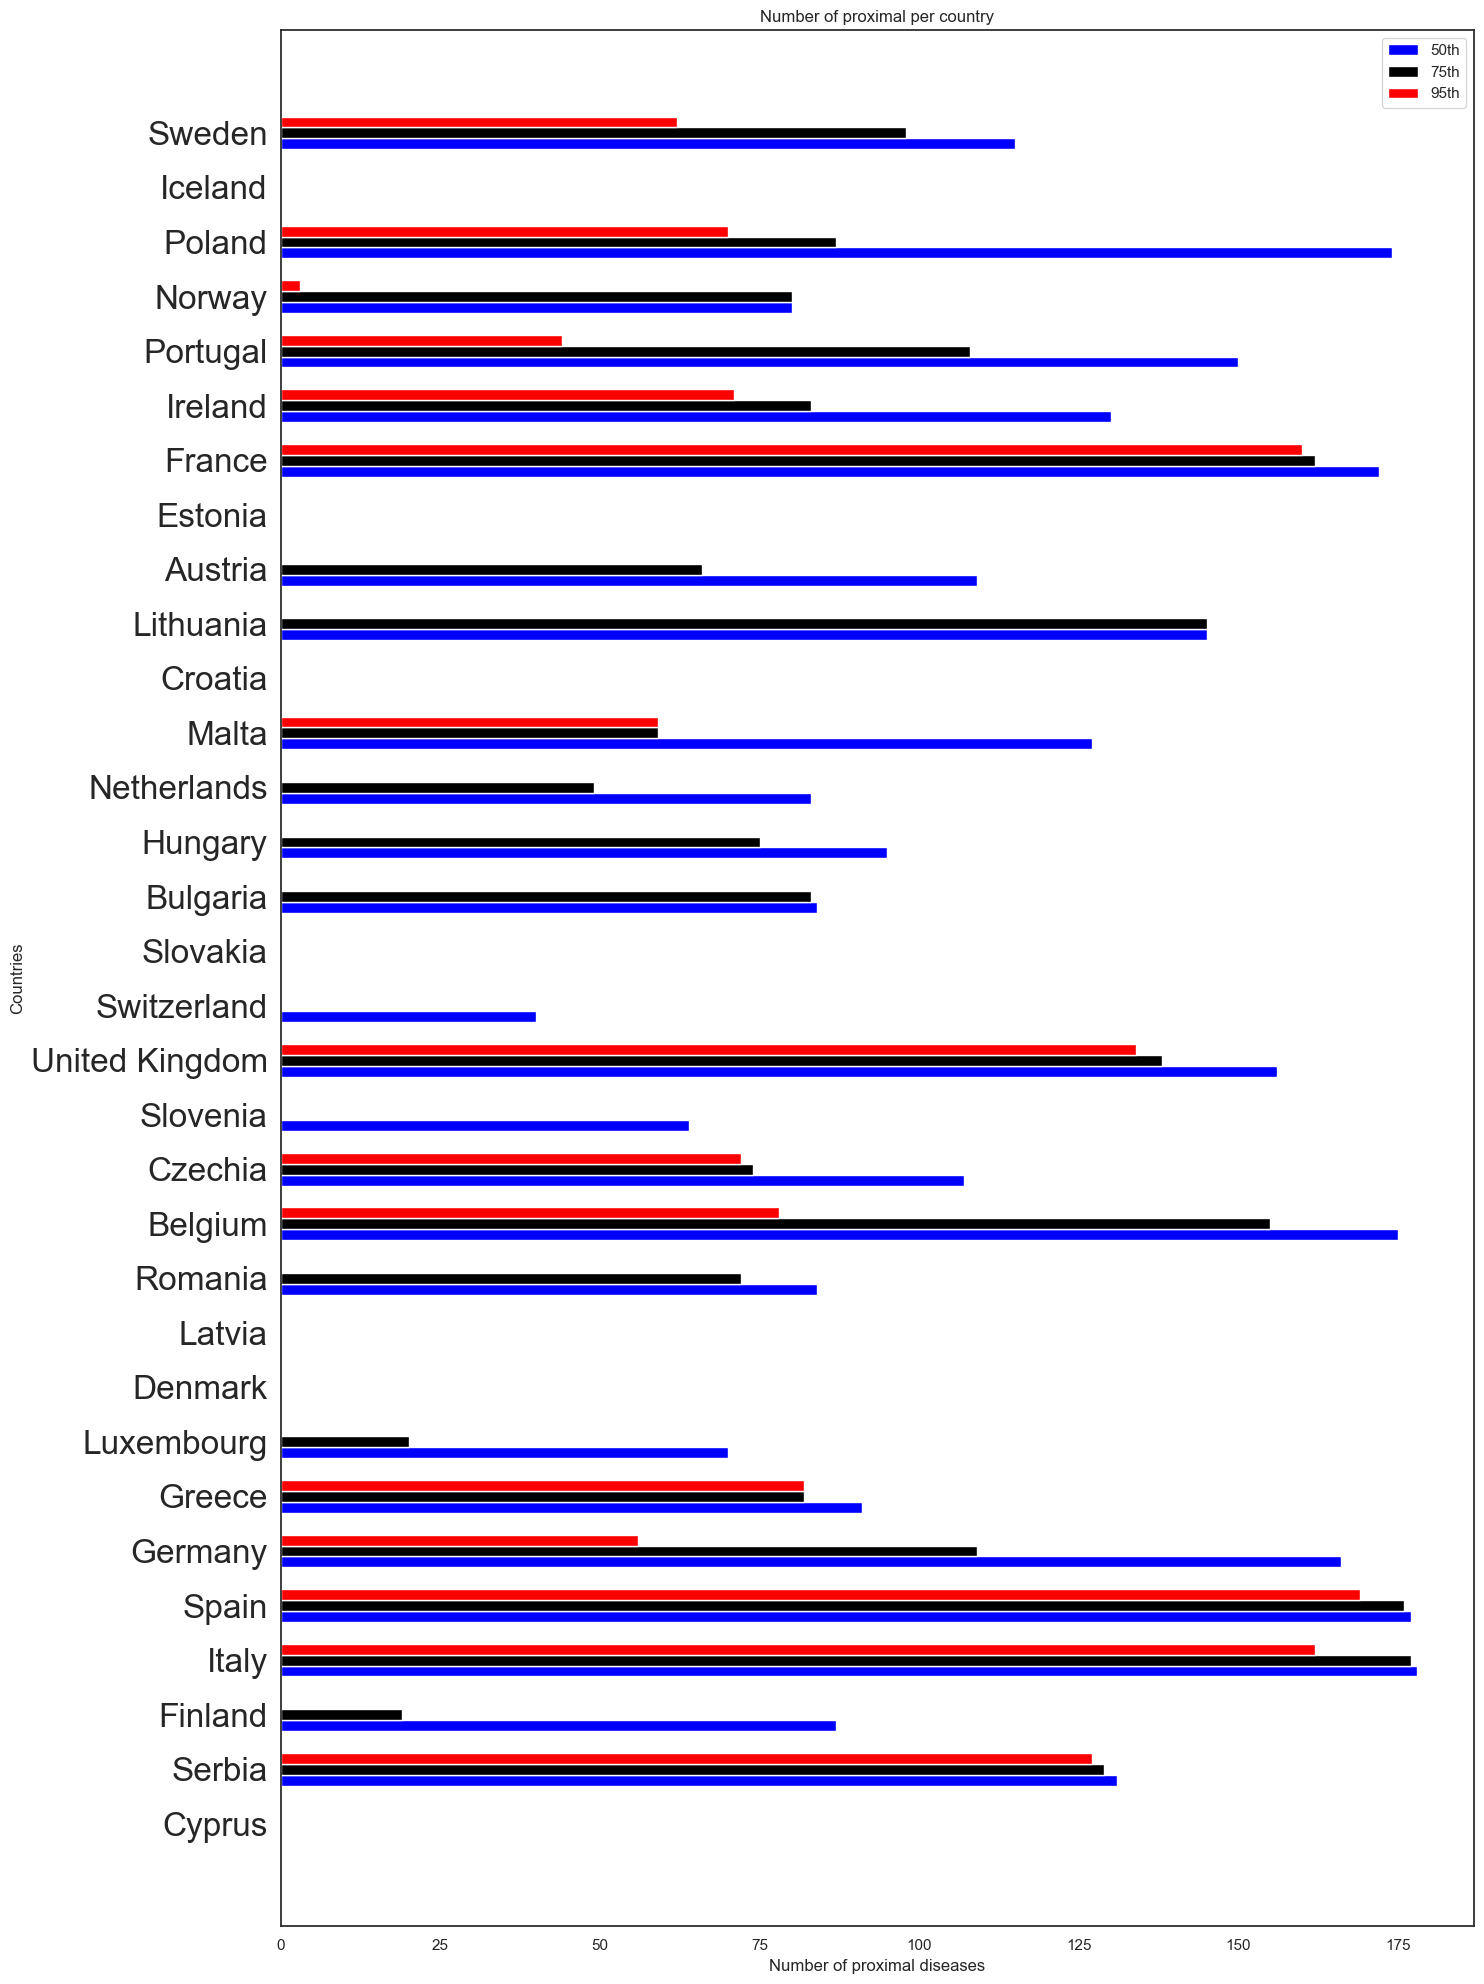

In [117]:


water_low_country_selected_dis_num_dict = {}
for country, dislist in water_low_country_selected_dis_dict.items():
    water_low_country_selected_dis_num_dict[country] = len(dislist)

water_country_selected_dis_num_dict = {}
for country, dislist in water_country_selected_dis_dict.items():
    water_country_selected_dis_num_dict[country] = len(dislist)
    
water_high_country_selected_dis_num_dict = {}
for country, dislist in water_high_country_selected_dis_dict.items():
    water_high_country_selected_dis_num_dict[country] = len(dislist)
    
# Get the list of countries (keys)
countries = list(water_country_selected_dis_dict.keys())

# Extract values from each dictionary
values_a = [water_low_country_selected_dis_num_dict[country] for country in countries]
values_b = [water_country_selected_dis_num_dict[country] for country in countries]
values_c = [water_high_country_selected_dis_num_dict[country] for country in countries]

# Define the position of bars on the x-axis
x = np.arange(len(countries))

# Width of a bar
width = 0.2

fig, ax = plt.subplots(figsize=(15, 20))

# Plotting the bars
rects1 = ax.barh(x - width, values_a, width, color='blue', label='50th')
rects2 = ax.barh(x, values_b, width, color='black', label='75th')
rects3 = ax.barh(x + width, values_c, width, color='red', label='95th')

# Adding labels, title, and customizing axes
ax.set_xlabel('Number of proximal diseases')
ax.set_ylabel('Countries')
ax.set_title('Number of proximal per country')
ax.set_yticks(x)
ax.set_yticklabels(countries,fontsize=24)
ax.legend()

# Show the plot
plt.tight_layout()
#plt.savefig('output/Figures/SF10B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [118]:

# Ensure same country order as plot
countries = list(water_country_selected_dis_dict.keys())

rows = []

for idx, country in enumerate(countries):
    rows.append({
        "Country": country,
        "Position_index": idx,
        "50th_percentile_count": water_low_country_selected_dis_num_dict.get(country, 0),
        "75th_percentile_count": water_country_selected_dis_num_dict.get(country, 0),
        "95th_percentile_count": water_high_country_selected_dis_num_dict.get(country, 0)
    })

df_barplot = pd.DataFrame(rows)

print("Total countries:", len(df_barplot))

# ----------------------------
# Save to Excel (single sheet)
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_barplot.to_excel(
        writer,
        sheet_name="SF16B",
        index=False
    )


Total countries: 32


In [119]:
water_disgenet_gbd_dict = air_disgenet_gbd_dict.copy()

In [120]:
#Let's add some more diseases manually
water_disgenet_gbd_dict['Amyotrophic Lateral Sclerosis']='Motor neuron disease'
water_disgenet_gbd_dict['Familial thoracic aortic aneurysm and aortic dissection']='Aortic aneurysm'
water_disgenet_gbd_dict['Bladder Neoplasm']='Bladder cancer'
water_disgenet_gbd_dict['Malignant neoplasm of esophagus']='Esophageal cancer'
water_disgenet_gbd_dict['Acute Promyelocytic Leukemia']='Leukemia'
water_disgenet_gbd_dict['Precursor T-Cell Lymphoblastic Leukemia-Lymphoma']='Leukemia'
water_disgenet_gbd_dict['Juvenile Myelomonocytic Leukemia']='Leukemia'
water_disgenet_gbd_dict['MIGRAINE WITH OR WITHOUT AURA, SUSCEPTIBILITY TO, 1']='Migraine'
water_disgenet_gbd_dict['Male infertility']='Male infertility'
water_disgenet_gbd_dict['Precursor Cell Lymphoblastic Leukemia Lymphoma']='Leukemia'
water_disgenet_gbd_dict['Osteoarthritis of hip']='Osteoarthritis hip'
water_disgenet_gbd_dict['Stomach Carcinoma']='Stomach cancer'
water_disgenet_gbd_dict['Hypertrophic Cardiomyopathy']='Other cardiomyopathy'
water_disgenet_gbd_dict['Cerebral Hemorrhage']='Intracerebral hemorrhage'

print(len(water_disgenet_gbd_dict))

103


In [121]:
country_water_dis_mean_prox_dict = {}
for country,disset in water_country_selected_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(water_country_selected_chem_id_dict[country])>0:
            for chem in water_country_selected_chem_id_dict[country]:
                try:
                    z_list.append(real_significant_final_exp_proximity[chem,dis][1])
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)
                    
    country_water_dis_mean_prox_dict[country] = dis_dict

In [122]:
country_water_chem_id_gbd_dict = {}

for country,dis_dict in country_water_dis_mean_prox_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([water_disgenet_gbd_dict[dis],z])
            except:
                pass
        country_water_chem_id_gbd_dict[country] = dis_z_list

In [123]:
country_water_chem_id_gbd_mean_dict = {}
for country,dislist in country_water_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0]) 
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    country_water_chem_id_gbd_mean_dict[country]=dis_dict


In [124]:
country_water_faraway_dis_dict={}
for country,chemset in water_country_selected_chem_id_dict.items():
    if len(chemset)>0:
        far_away_dis_set = []
        for chem in chemset:
            for chem_dis_pair in faraway_exp_dis_dict.keys():
                if chem in chem_dis_pair[0]:
                    far_away_dis_set.append(chem_dis_pair[1])
        country_water_faraway_dis_dict[country] = set(far_away_dis_set)

In [125]:
faraway_water_disset = []

for country,disset in country_water_faraway_dis_dict.items():
    for dis in disset:
        if dis not in faraway_water_disset:
            faraway_water_disset.append(dis)

print(len(faraway_water_disset))

296


In [126]:
n_long_faraway_water_disset_gbd_dict = {}
for dis1 in faraway_water_disset:
    dis1_processed = preprocess_string(dis1)
    # Initialize best match tracking
    best_match = (None, 0)  # (Best match disease name, similarity score)
    for dis2 in disease_set:
        dis2_processed = preprocess_string(dis2)
        similarity = get_similarity_score(dis1_processed, dis2_processed)
        # Update if this is the best match so far
        if similarity > best_match[1]:
            best_match = (dis2, similarity)
    
    # You may want to set a threshold for "good enough" matching
    if best_match[1] > 50:  # This threshold
        n_long_faraway_water_disset_gbd_dict[dis1] = best_match[0]

print(len(n_long_faraway_water_disset_gbd_dict))

165


In [127]:
keys_to_delete=['Weill-Marchesani-Like Syndrome','HYPOGONADOTROPIC HYPOGONADISM 11 WITH OR WITHOUT ANOSMIA','Night blindness, congenital stationary',
             'Narcolepsy 1', 'DEAFNESS, X-LINKED 4 (disorder)','Juvenile nephropathic cystinosis (disorder)', 'Congenital Pain Insensitivity',
                'Nephropathic cystinosis','Congenital long QT syndrome','Glomerulocystic Kidney Disease with Hyperuricemia and Isosthenuria',
                'Keutel syndrome','FICOLIN 3 DEFICIENCY','Autosomal Dominant Nocturnal Frontal Lobe Epilepsy','Cavitary Optic Disc Anomalies',
                'alpha, alpha-Trehalase deficiency','Nephritis, Tubulointerstitial','Cerebral ventriculomegaly','HYPOGONADOTROPIC HYPOGONADISM 4 WITH OR WITHOUT ANOSMIA',
                'Goiter','Medullary Cystic Kidney Disease Type 2','Malabsorption Syndrome','CATARACT 39, MULTIPLE TYPES',
                'Long Qt Syndrome 10','RETINITIS PIGMENTOSA 49','Olmsted syndrome','Cystinosis','HIRSCHSPRUNG DISEASE, SUSCEPTIBILITY TO, 4',
                'MASP2 Deficiency','Cone monochromatism','Enterokinase Deficiency','Retinitis Pigmentosa 7','Narcolepsy','Jarcho-Levin syndrome',
                'Waardenburg Syndrome, Type 4b','NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1E','Factor XIII, B Subunit, Deficiency Of',
                'Renal hypouricemia','MYASTHENIC SYNDROME, CONGENITAL, 1A, SLOW-CHANNEL','BLEEDING DISORDER, PLATELET-TYPE, 20',
                'SMALL PATELLA SYNDROME','Amish Infantile Epilepsy Syndrome','Scoliosis, unspecified','Focal glomerulosclerosis',
                'Meningococcal Infections','Indifference to Pain, Congenital, Autosomal Recessive','Neuropathy, Distal Hereditary Motor, Type VIIA',
                'Obstruction of pelviureteric junction','TELANGIECTASIA, HEREDITARY HEMORRHAGIC, TYPE 5','Marshall syndrome','STICKLER SYNDROME, TYPE II (disorder)',
                'Histiocytosis','Hypopigmentation disorder','PAROXYSMAL EXTREME PAIN DISORDER','NEMALINE MYOPATHY 10','DEAFNESS, AUTOSOMAL RECESSIVE 42 (disorder)',
                'Nivelon Nivelon Mabille syndrome','HERMANSKY-PUDLAK SYNDROME 4','Juvenile hemochromatosis','HEMOCHROMATOSIS, TYPE 2A','USHER SYNDROME, TYPE IJ',
                'CATARACT 47','Usher Syndrome, Type IF','Hypouricemia, Renal, 2','NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1G','Primary Erythermalgia',
                'Trimethylaminuria','Hypertrichosis','Congenital disorder of glycosylation, type 2C','Night Blindness, Congenital Stationary, Autosomal Dominant 3',
                'Lysinuric Protein Intolerance','RETINITIS PIGMENTOSA, JUVENILE, LRAT-RELATED','Trichotillomania','Hydrocephalus','Usher Syndrome, Type I',
                'STARGARDT DISEASE 1 (disorder)','Perisylvian syndrome','Liver Failure','CATARACT 4, MULTIPLE TYPES','DEAFNESS, AUTOSOMAL RECESSIVE 1A (disorder)',
                'CILIARY DYSKINESIA, PRIMARY, 7 (disorder)','Vesico-Ureteral Reflux','VAN DER WOUDE SYNDROME 1','Hyperaldosteronism','Popliteal pterygium syndrome',
                'Riboflavin Deficiency','Zunich neuroectodermal syndrome','Hypercalcemia, Infantile','CONE-ROD DYSTROPHY 3 (disorder)','RETINITIS PIGMENTOSA 19','CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Ip',
                'Juvenile macular degeneration',"Stargardt's disease",'RETINITIS PIGMENTOSA 48'
                
]

n_long_faraway_water_disset_gbd_dict_cleaned_v1 = {}
for disgenet_dis, gbd_dis in n_long_faraway_water_disset_gbd_dict.items():
    if disgenet_dis not in keys_to_delete:
        n_long_faraway_water_disset_gbd_dict_cleaned_v1[disgenet_dis] = gbd_dis
        

In [128]:
keys_to_delete_v2 = ['JOUBERT SYNDROME 16','Leber Congenital Amaurosis 14','Dursun Syndrome','Neutropenia, Severe Congenital, Autosomal Recessive 4',
                     'Dihydropyrimidinase deficiency','Deuteranomaly','CRANIOSYNOSTOSIS AND DENTAL ANOMALIES','Canavan Disease','Canavan Disease, Juvenile',
                     'Dimethylglycine Dehydrogenase Deficiency','Retinitis Pigmentosa','Amnesia','POLYARTERITIS NODOSA, CHILDHOOD-ONSET','RETINITIS PIGMENTOSA 30',
                     'NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1B','Weill-Marchesani syndrome','Ectodermal Dysplasia','MACULAR DYSTROPHY, PATTERNED, 1',
                     'STEEL SYNDROME','CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Iu','Pfaundler-Hurler Syndrome','CATARACT 19, MULTIPLE TYPES',
                     'RETINITIS PIGMENTOSA 45','HYPERGLYCINURIA (disorder)','Arterial calcification of infancy','HYPOGONADOTROPIC HYPOGONADISM 3 WITH OR WITHOUT ANOSMIA',
                     'Muscle eye brain disease','Epilepsy','SEIZURES, BENIGN FAMILIAL INFANTILE, 3','Deafness, Autosomal Dominant 3B','West Syndrome',
                     'Multiple synostoses syndrome 1','Hurler-Scheie Syndrome','Bardet-Biedl Syndrome','Sneddon Syndrome','Idiopathic Pulmonary Fibrosis',
                     'Holoprosencephaly','MYASTHENIC SYNDROME, CONGENITAL, 4A, SLOW-CHANNEL','Leber Congenital Amaurosis','CEROID LIPOFUSCINOSIS, NEURONAL, 13',
                     'Hermanski-Pudlak Syndrome','Pain','Gilles de la Tourette syndrome','Canavan Disease, Infantile','Congenital hemihypertrophy',
                     'Myasthenic Syndromes, Congenital','Meleda Disease','Intervertebral disc disorder','Nonsyndromic Deafness'
    
]



n_long_faraway_water_disset_gbd_dict_cleaned_v2 = {}
for disgenet_dis, gbd_dis in n_long_faraway_water_disset_gbd_dict_cleaned_v1.items():
    if disgenet_dis not in keys_to_delete_v2:
        n_long_faraway_water_disset_gbd_dict_cleaned_v2[disgenet_dis] = gbd_dis

n_long_faraway_water_disset_gbd_dict_cleaned_v2['Epilepsy'] = 'Idiopathic epilepsy'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['SEIZURES, BENIGN FAMILIAL INFANTILE, 3'] = 'Idiopathic epilepsy'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['CATARACT 39, MULTIPLE TYPES'] = 'Cataract'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1E'] = 'Blindness and vision loss'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['CATARACT 4, MULTIPLE TYPES'] = 'Cataract'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['CATARACT 47'] = 'Cataract'


water_faraway_dis_list = list(n_long_faraway_water_disset_gbd_dict_cleaned_v2.values())
water_faraway_dis_list.extend(['Congenital musculoskeletal and limb anomalies','Congenital birth defects','Congenital heart anomalies'])

print(len(water_faraway_dis_list))

32


In [129]:

faraway_manually_added_diseases = ['Congenital musculoskeletal and limb anomalies','Congenital birth defects','Congenital heart anomalies']

country_water_faraway_dis_dict = {}
for country,dis_dict in country_water_chem_id_gbd_mean_dict.items():
    chem_set = water_country_selected_chem_id_dict[country]
    country_faraway_dis_list = []
    country_specific_faraway_dis_dict = {}
    
    for dis in water_faraway_dis_list:
        if dis not in dis_dict.keys():
            country_faraway_dis_list.append(dis)
    for dis in country_faraway_dis_list:
        if dis not in faraway_manually_added_diseases:
            disgenet_name_list = []
            z_score_list = []
            for disgenet_name,gbd_id in n_long_faraway_water_disset_gbd_dict_cleaned_v2.items():
                if dis == gbd_id:
                    disgenet_name_list.append(disgenet_name)
                    for chem in chem_set:
                        try:
                            z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                        except:
                            pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        elif dis=='Congenital heart anomalies':
            disgenet_name_list = ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon',
                                 'Congenital long QT syndrome']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        
        elif dis=='Congenital musculoskeletal and limb anomalies':
            disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                 'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                 'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                 'Congenital Fibrosis of the Extraocular Muscles']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
            
        elif dis=='Congenital birth defects':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Congenital' in dis or 'congenital' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)

    country_water_faraway_dis_dict[country] = country_specific_faraway_dis_dict


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [130]:
#We will use the same no-proximal disease sets/dictionary that we have calcualted for the air pollution

country_noprox_water_dis_dict = {}
for country,dis_dict in country_water_chem_id_gbd_mean_dict.items():
    n_dis = len(dis_dict)
    chem_set = water_country_selected_chem_id_dict[country]
    country_noprox_dis_list = []
    country_specific_noprox_dis_dict = {}
    
    for gbd_dis,dislist in no_prox_air_disset_gbd_dict_cleaned_inv.items():
        if gbd_dis not in dis_dict.keys():
            if gbd_dis not in list(country_water_faraway_dis_dict[country].keys()):
                country_noprox_dis_list.append(gbd_dis)
    for dis in country_noprox_dis_list:
        disgenet_name_list = no_prox_air_disset_gbd_dict_cleaned_inv[dis]
        z_score_list = []
        for chem in chem_set:
            for disgenet_name in disgenet_name_list:
                try:
                    z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                except:
                    pass
        if np.mean(z_score_list)>-1.5:
            country_specific_noprox_dis_dict[dis]=np.mean(z_score_list)
    country_specific_noprox_dis_dict_sort = {k: v for k, v in sorted(country_specific_noprox_dis_dict.items(), key=lambda item: item[1])}
    
    if len(country_specific_noprox_dis_dict_sort)>n_dis:
        country_specific_noprox_dis_dict_sort_keys = list(country_specific_noprox_dis_dict_sort.keys())
        n_country_specific_noprox_dis_dict_sort = {}
        for k in list(country_specific_noprox_dis_dict_sort_keys)[:n_dis]:
            n_country_specific_noprox_dis_dict_sort[k]=country_specific_noprox_dis_dict_sort[k]
        
        country_noprox_water_dis_dict[country] = n_country_specific_noprox_dis_dict_sort
    else:
        country_noprox_water_dis_dict[country] = country_specific_noprox_dis_dict_sort
 

In [131]:
#Let's just merge the no-proximal dictionary and the faraway dictionary
new_water_country_distant_dis_dict = {}
for country,dis_dict in country_water_chem_id_gbd_mean_dict.items():
    n_proxdis = len(dis_dict)
    n_distantdis = len(country_water_faraway_dis_dict[country])
    noprox_list = list(country_noprox_water_dis_dict[country].keys())
    missing_dis = n_proxdis-n_distantdis
    try:
        dislist = noprox_list[:missing_dis]
        distant_dict = country_water_faraway_dis_dict[country].copy()
        for dis in dislist:
            distant_dict[dis] = country_noprox_water_dis_dict[country][dis]
        new_water_country_distant_dis_dict[country] = distant_dict
    except:
        distant_dict = {**country_water_faraway_dis_dict[country], **country_noprox_water_dis_dict[country]}
        new_water_country_distant_dis_dict[country] = distant_dict

In [132]:
proximal_dis_list=[] 
for country, disdict in country_water_chem_id_gbd_mean_dict.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list

proximal_dis_prevalence={}
for dis in set(proximal_dis_list):
    prevalence_list=[]
    for country in country_set:
        prevalence_list.append(country_dis_prevalence[country][dis])
    proximal_dis_prevalence[dis]=prevalence_list

proximal_dis_mortality={}
for dis in set(proximal_dis_list):
    mortality_list=[]
    for country in country_set:
        mortality_list.append(country_dis_mortality[country][dis])
    proximal_dis_mortality[dis]=mortality_list

proximal_dis_daly={}
for dis in set(proximal_dis_list):
    daly_list=[]
    for country in country_set:
        daly_list.append(country_dis_DALYs[country][dis])
    proximal_dis_daly[dis]=daly_list


In [133]:

water_country_proximal_zscore_dict={}
for country,dis_dict in country_water_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_incidence[dis])
        std = np.std(proximal_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list
    

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3247856332.py:8: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [134]:
distant_dis_list=[] 
for country, disdict in new_water_country_distant_dis_dict.items():
    distant_dis_list.extend(list(disdict.keys()))
    
distant_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(distant_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    distant_dis_incidence[dis]=incidence_list


distant_dis_prevalence={}
for dis in set(distant_dis_list):
     prevalence_list=[]
     for country in country_set:
         prevalence_list.append(country_dis_prevalence[country][dis])
     distant_dis_prevalence[dis]=prevalence_list

distant_dis_mortality={}
for dis in set(distant_dis_list):
     mortality_list=[]
     for country in country_set:
         mortality_list.append(country_dis_mortality[country][dis])
     distant_dis_mortality[dis]=mortality_list

distant_dis_daly={}
for dis in set(distant_dis_list):
     daly_list=[]
     for country in country_set:
         daly_list.append(country_dis_DALYs[country][dis])
     distant_dis_daly[dis]=daly_list


In [135]:
water_country_distant_zscore_dict={}

for country,dis_dict in new_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_incidence[dis])
        std = np.std(distant_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list
    

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/1859735108.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [136]:
water_pollution_zscore_df = pd.DataFrame()

selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

In [137]:
my_order = sorted(list(set(water_pollution_zscore_df['location'])))

In [ ]:
#Let's test the difference between proximal and no-proximal (because with distant is kind of obvious and it doesn't
#make so much sense)
import scipy
for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
        

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2018260574.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size=36)


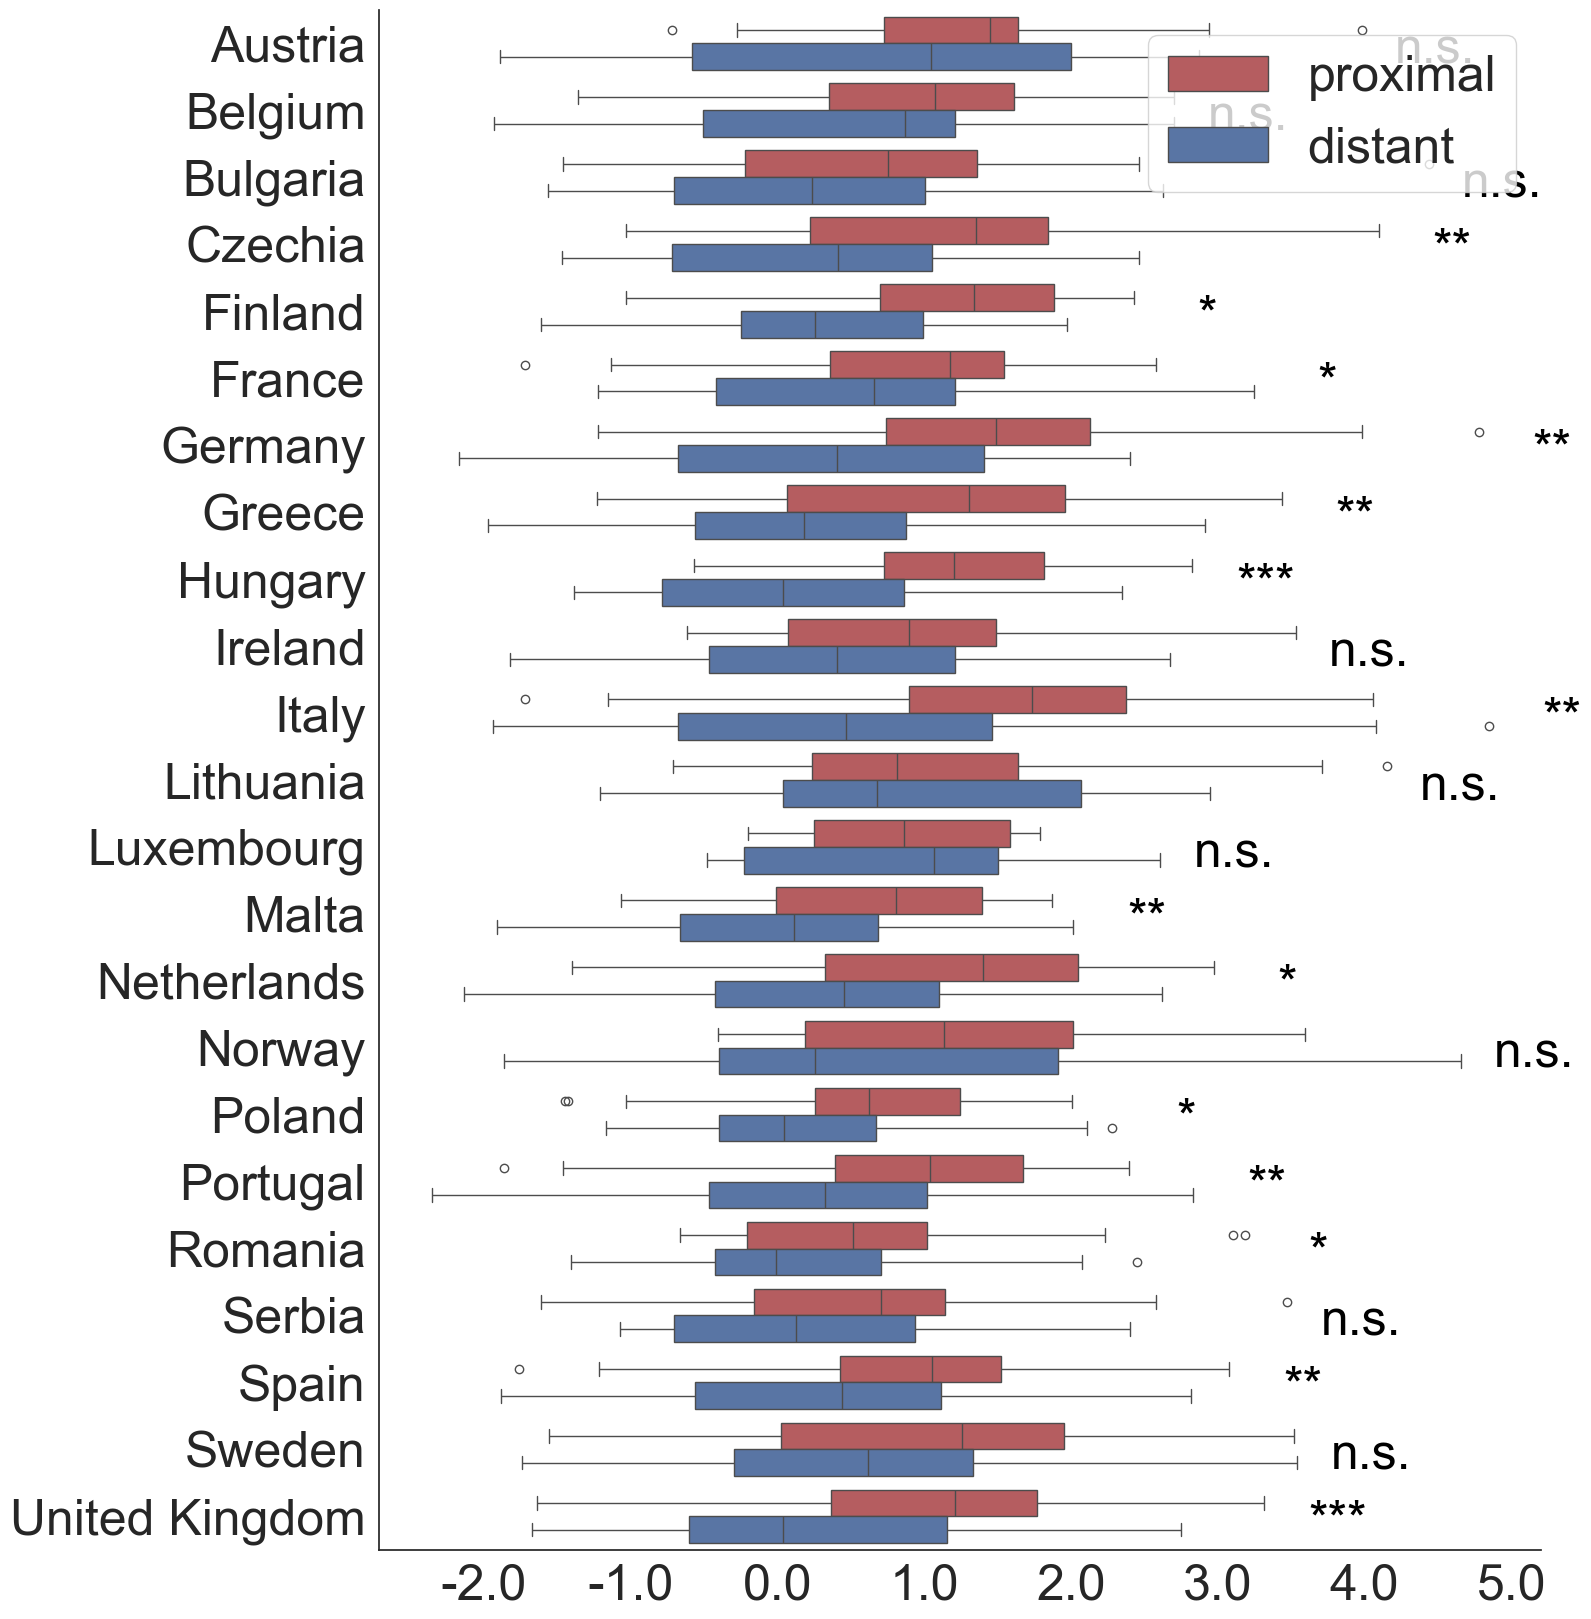

In [138]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["r", "b"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

#plt.savefig('output/Figures/Figure4F_v09.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Once everything is set, display or save the figure
plt.show()

In [139]:
#Prevalence

water_country_proximal_zscore_dict={}
for country,dis_dict in country_water_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_prevalence[dis])
        std = np.std(proximal_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_prevalence[dis])
        std = np.std(distant_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.5033880535803806 0.2635140599149104 0.0675
Finland 1.394021955985683 0.704122781569034 0.0912
Italy 1.8201084528565958 0.9450917862065278 0.0078
Spain 1.0882972403285662 0.6189732517170614 0.0061
Germany 1.7519232172780388 0.5068629847481344 0.0005
Greece 1.086330413039301 0.2897109077837728 0.0014
Luxembourg 1.0567524517547402 0.6373503215922386 0.2483
Romania 0.5801317435164202 0.2174148540137555 0.0181
Belgium 0.9515943131650123 0.6760542341786137 0.2299
Czechia 1.2042902628659267 0.37907168844288913 0.0021
United Kingdom 1.1605774329385474 0.3662821469206311 0.0016
Bulgaria 0.685143012197627 0.20834161736627507 0.0276
Hungary 1.1358613185861655 0.3851487468591084 0.0004
Netherlands 1.1453233631262547 0.4455226588921071 0.0256
Malta 0.6768977947142182 0.40937893109702816 0.0773
Lithuania 0.8054386422717084 0.610151341668709 0.1762
Austria 1.220148099491099 1.026952478184039 0.312
France 0.9194427698840192 0.5464198460483662 0.0445
Ireland 0.8083374909138014 0.31603079424605

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/655084621.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_prevalence[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/655084621.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_prevalence[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD12D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [140]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF18B_part1",
        index=False
    )

In [141]:
#mortality

water_country_proximal_zscore_dict={}
for country,dis_dict in country_water_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_mortality[dis])
        std = np.std(proximal_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_mortality[dis])
        std = np.std(distant_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.8526974564960663 0.32382087016393596 0.0236
Finland 0.8659678569343671 0.14704867009895922 0.0345
Italy 1.214627511291155 0.5910101652615637 0.0252
Spain 0.8374041536060528 0.3550418976918581 0.0245
Germany 1.231285062957581 0.6676221941856616 0.0163
Greece 0.9011026134701002 0.06140057039426138 0.008
Luxembourg 0.7027356175715319 -0.08014126956964658 0.0126
Romania 0.7783632966681461 0.14071981826606747 0.0094
Belgium 0.9314119558920794 0.8974399521376922 0.3776
Czechia 1.076594810653707 0.06058579691671833 0.0008
United Kingdom 1.0632962854309609 0.3644658592654678 0.0193
Bulgaria 1.204804643081574 0.5490614956356823 0.0471
Hungary 1.5514296085546302 0.26803539853940156 0.0023
Netherlands 0.7336199460190899 0.9171787298942303 0.4206
Malta 0.5666194588523698 0.06982670877641123 0.0135
Lithuania 1.1207772850299047 1.538614277149322 0.6098
Austria 1.1218855474803917 0.6084084248191023 0.0683
France 0.8671356775788837 0.634232412312499 0.0506
Ireland 0.45514635760909616 -0.22159

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2526871524.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2526871524.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD13D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [142]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF19B_part1",
        index=False
    )

In [143]:
#daly

water_country_proximal_zscore_dict={}
for country,dis_dict in country_water_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_daly[dis])
        std = np.std(proximal_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_daly[dis])
        std = np.std(distant_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.6756854088494548 0.05970177393508173 0.0036
Finland 0.6469380845284418 0.1694435821271587 0.0912
Italy 0.9810190008019152 0.7987623422391525 0.0838
Spain 0.6750235048738654 0.6047148840619421 0.1983
Germany 0.846942102713406 0.4247340873871437 0.0362
Greece 0.8151366615596594 0.13353873341593037 0.0062
Luxembourg 0.5291420068208332 0.3131779302007568 0.178
Romania 0.7394537222262572 -0.03010510211452082 0.0003
Belgium 0.6080995292878946 0.46993138914805754 0.2486
Czechia 1.0547466966113386 0.07201978517598408 0.0002
United Kingdom 0.8893797017602135 0.2835793601771811 0.0072
Bulgaria 1.0672438854473765 0.09728827306071762 0.0027
Hungary 1.496395519576322 0.16205322335606404 0.0
Netherlands 0.5861211284069973 0.5279236621665957 0.3567
Malta 0.40069319162909356 0.042711591539208095 0.029
Lithuania 1.1522574822433838 0.5317013502191289 0.084
Austria 0.7552945188742364 0.5626428343979545 0.157
France 0.5386303837748662 0.47476165046391877 0.3228
Ireland 0.4251107346044799 0.073617

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/440605997.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/440605997.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD14D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [144]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF20B_part1",
        index=False
    )

In [ ]:
#LOW

In [145]:
#Proximal
water_low_country_selected_dis_mean_prox_dict = {}
for country,disset in water_low_country_selected_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(water_low_country_selected_chem_id_dict[country])>0:
            for chem in water_low_country_selected_chem_id_dict[country]:
                try:
                    z_list.append(real_significant_final_exp_proximity[chem,dis][1])
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)            
    water_low_country_selected_dis_mean_prox_dict[country] = dis_dict

water_low_country_selected_chem_id_gbd_dict = {}
for country,dis_dict in water_low_country_selected_dis_mean_prox_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([water_disgenet_gbd_dict[dis],z])
            except:
                pass
        water_low_country_selected_chem_id_gbd_dict[country] = dis_z_list

water_low_country_selected_chem_id_gbd_mean_dict = {}
for country,dislist in water_low_country_selected_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    water_low_country_selected_chem_id_gbd_mean_dict[country]=dis_dict

proximal_dis_list=[] 
for country, disdict in water_low_country_selected_chem_id_gbd_mean_dict.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list


proximal_dis_prevalence={}
for dis in set(proximal_dis_list):
    prevalence_list=[]
    for country in country_set:
        prevalence_list.append(country_dis_prevalence[country][dis])
    proximal_dis_prevalence[dis]=prevalence_list

proximal_dis_mortality={}
for dis in set(proximal_dis_list):
    mortality_list=[]
    for country in country_set:
        mortality_list.append(country_dis_mortality[country][dis])
    proximal_dis_mortality[dis]=mortality_list

proximal_dis_daly={}
for dis in set(proximal_dis_list):
    daly_list=[]
    for country in country_set:
        daly_list.append(country_dis_DALYs[country][dis])
    proximal_dis_daly[dis]=daly_list


water_low_country_proximal_zscore_dict={}
for country,dis_dict in water_low_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_incidence[dis])
        std = np.std(proximal_dis_incidence[dis])
        z = (country_dis_incidence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        water_low_country_proximal_zscore_dict[country]=country_proximal_zscore_list



/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3573068514.py:88: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [146]:
#Distant
low_country_water_faraway_dis_dict={}
for country,chemset in water_low_country_selected_chem_id_dict.items():
    if len(chemset)>0:
        far_away_dis_set = []
        for chem in chemset:
            for chem_dis_pair in faraway_exp_dis_dict.keys():
                if chem in chem_dis_pair[0]:
                    far_away_dis_set.append(chem_dis_pair[1])
        low_country_water_faraway_dis_dict[country] = set(far_away_dis_set)

low_country_water_faraway_dis_dict = {}
for country,dis_dict in water_low_country_selected_chem_id_gbd_mean_dict.items():
    chem_set = water_low_country_selected_chem_id_dict[country]
    country_faraway_dis_list = []
    country_specific_faraway_dis_dict = {}
    for dis in faraway_dis_list:
        if dis not in dis_dict.keys():
            country_faraway_dis_list.append(dis)
    for dis in country_faraway_dis_list:
        if dis not in faraway_manually_added_diseases:
            disgenet_name_list = []
            z_score_list = []
            for disgenet_name,gbd_id in n_long_faraway_water_disset_gbd_dict_cleaned_v2.items():
                if dis == gbd_id:
                    disgenet_name_list.append(disgenet_name)
                    for chem in chem_set:
                        try:
                            z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                        except:
                            pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        elif dis=='Congenital heart anomalies':
            disgenet_name_list = ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon',
                                 'Congenital long QT syndrome']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        
        elif dis=='Congenital musculoskeletal and limb anomalies':
            disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                 'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                 'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                 'Congenital Fibrosis of the Extraocular Muscles']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
            
        elif dis=='Congenital birth defects':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Congenital' in dis or 'congenital' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)

        elif dis=='Turner syndrome':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Turner' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
    low_country_water_faraway_dis_dict[country] = country_specific_faraway_dis_dict


low_country_noprox_water_dis_dict = {}
for country,dis_dict in water_low_country_selected_chem_id_gbd_mean_dict.items():
    n_dis = len(dis_dict)
    chem_set = water_low_country_selected_chem_id_dict[country]
    country_noprox_dis_list = []
    country_specific_noprox_dis_dict = {}
    
    for gbd_dis,dislist in no_prox_air_disset_gbd_dict_cleaned_inv.items():
        if gbd_dis not in dis_dict.keys():
            if gbd_dis not in list(low_country_water_faraway_dis_dict[country].keys()):
                country_noprox_dis_list.append(gbd_dis)
    for dis in country_noprox_dis_list:
        disgenet_name_list = no_prox_air_disset_gbd_dict_cleaned_inv[dis]
        z_score_list = []
        for chem in chem_set:
            for disgenet_name in disgenet_name_list:
                try:
                    z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                except:
                    pass
        if np.mean(z_score_list)>-1.5:
            country_specific_noprox_dis_dict[dis]=np.mean(z_score_list)
    country_specific_noprox_dis_dict_sort = {k: v for k, v in sorted(country_specific_noprox_dis_dict.items(), key=lambda item: item[1])}
    
    if len(country_specific_noprox_dis_dict_sort)>n_dis:
        country_specific_noprox_dis_dict_sort_keys = list(country_specific_noprox_dis_dict_sort.keys())
        n_country_specific_noprox_dis_dict_sort = {}
        for k in list(country_specific_noprox_dis_dict_sort_keys)[:n_dis]:
            n_country_specific_noprox_dis_dict_sort[k]=country_specific_noprox_dis_dict_sort[k]
        
        low_country_noprox_water_dis_dict[country] = n_country_specific_noprox_dis_dict_sort
    else:
        low_country_noprox_water_dis_dict[country] = country_specific_noprox_dis_dict_sort

#Let's just merge the no-proximal dictionary and the faraway dictionary
new_low_water_country_distant_dis_dict = {}
for country,dis_dict in water_low_country_selected_chem_id_gbd_mean_dict.items():
    n_proxdis = len(dis_dict)
    n_distantdis = len(low_country_water_faraway_dis_dict[country])
    noprox_list = list(low_country_noprox_water_dis_dict[country].keys())
    missing_dis = n_proxdis-n_distantdis
    try:
        dislist = noprox_list[:missing_dis]
        distant_dict = low_country_water_faraway_dis_dict[country].copy()
        for dis in dislist:
            distant_dict[dis] = low_country_noprox_water_dis_dict[country][dis]
        new_low_water_country_distant_dis_dict[country] = distant_dict
    except:
        distant_dict = {**low_country_water_faraway_dis_dict[country], **low_country_noprox_water_dis_dict[country]}
        new_low_water_country_distant_dis_dict[country] = distant_dict

distant_dis_list=[] 
for country, disdict in new_low_water_country_distant_dis_dict.items():
    distant_dis_list.extend(list(disdict.keys()))
    
distant_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(distant_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    distant_dis_incidence[dis]=incidence_list


distant_dis_prevalence={}
for dis in set(distant_dis_list):
     prevalence_list=[]
     for country in country_set:
         prevalence_list.append(country_dis_prevalence[country][dis])
     distant_dis_prevalence[dis]=prevalence_list

distant_dis_mortality={}
for dis in set(distant_dis_list):
     mortality_list=[]
     for country in country_set:
         mortality_list.append(country_dis_mortality[country][dis])
     distant_dis_mortality[dis]=mortality_list

distant_dis_daly={}
for dis in set(distant_dis_list):
     daly_list=[]
     for country in country_set:
         daly_list.append(country_dis_DALYs[country][dis])
     distant_dis_daly[dis]=daly_list

water_low_country_distant_zscore_dict={}
for country,dis_dict in new_low_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_incidence[dis])
        std = np.std(distant_dis_incidence[dis])
        z = (country_dis_incidence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_low_country_distant_zscore_dict[country]=country_distant_zscore_list

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/1252264169.py:181: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [147]:
water_pollution_low_zscore_df = pd.DataFrame()

selected_countries=set(water_low_country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_low_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_low_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_low_zscore_df['location']=tot_country_list
water_pollution_low_zscore_df['z-score']=tot_zscore_list
water_pollution_low_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(water_pollution_low_zscore_df['location'])))

In [ ]:
#Let's test the difference between proximal and no-proximal (because with distant is kind of obvious and it doesn't
#make so much sense)
import scipy
for country in water_low_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_low_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_low_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
        

In [ ]:
import scipy 
# Assuming your data loading and plot setup code here

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_low_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = [] 
locations = [] 
stars = [] 


for country in my_order:
    proximallist_cleaned = [x for x in water_low_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_low_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4  
    xloc = max(water_pollution_low_zscore_df[water_pollution_low_zscore_df['location'] == loc]['z-score']) + 0.5  
  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD11C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()


In [174]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_low_zscore_df.to_excel(
        writer,
        sheet_name="SF17C",
        index=False
    )

In [155]:
#Prevalence

water_country_proximal_zscore_dict={}
for country,dis_dict in water_low_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_prevalence[dis])
        std = np.std(proximal_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_low_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_prevalence[dis])
        std = np.std(distant_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.5033880535803806 0.35117828520565586 0.1307
Finland 1.4110290813357322 0.533898803930098 0.0003
Italy 1.8201084528565958 0.9407291153645133 0.006
Spain 1.0882972403285662 0.5958830792566269 0.005
Germany 1.6408003208530775 0.6951531158361991 0.0023
Greece 1.040417522118493 0.391782715984727 0.0043
Luxembourg 0.9611205013973605 0.3587382747895652 0.0129
Romania 0.5851985521445686 0.2974601298711619 0.0403
Belgium 0.9672893537882201 0.3621292999545832 0.0166
Czechia 0.9337311895554788 0.44722231066909074 0.0201
Slovenia 1.1556966659813122 0.3807434322592935 0.001
United Kingdom 1.150843587410178 0.4760610881268531 0.0059
Switzerland 1.2451894570781459 0.5770441850628398 0.0279
Bulgaria 0.685143012197627 0.19947356963321447 0.0201
Hungary 1.050846390813899 0.4645178826575993 0.0031
Netherlands 1.170921060384909 0.37803717360265865 0.0032
Malta 0.7974572730340039 0.2558985634340446 0.0056
Lithuania 0.8054386422717084 0.610151341668709 0.1762
Austria 1.2963629115242943 0.8999609700

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/987850443.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_prevalence[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD12E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [156]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF18B_part2",
        index=False
    )

In [157]:
#mortality

water_country_proximal_zscore_dict={}
for country,dis_dict in water_low_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_mortality[dis])
        std = np.std(proximal_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_low_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_mortality[dis])
        std = np.std(distant_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.8526974564960663 0.43385878604526745 0.0549
Finland 1.0212901107258445 0.41787048149093214 0.0333
Italy 1.2146275112911553 0.5471834559144717 0.0156
Spain 0.8374041536060528 0.31988752129652626 0.0179
Germany 1.2134406273166247 0.5989863766622653 0.0109
Greece 0.899656882755661 0.21600261372147092 0.0142
Luxembourg 0.6140119497449419 0.062188504700277696 0.0215
Romania 0.7304640490228189 0.2249519403949851 0.0339
Belgium 0.9092242375349981 0.5966398123260184 0.12
Czechia 0.7147226394084655 0.12666597260213117 0.0295
Slovenia 1.2136055435005402 0.2874629846400287 0.0006
United Kingdom 1.0632962854309609 0.6458240800115356 0.0731
Switzerland 0.8114645980357258 0.32178318746471285 0.0346
Bulgaria 1.204804643081574 0.360086745360233 0.0085
Hungary 1.379033871818049 0.5283689973945604 0.0094
Netherlands 0.9219780690330796 0.2981673085115976 0.0058
Malta 0.5194340501336083 -0.030049709245902025 0.0078
Lithuania 1.1207772850299047 1.538614277149322 0.6098
Austria 0.9489780294414808 0

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/1516602172.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/1516602172.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD13E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [158]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF19B_part2",
        index=False
    )

In [159]:
#daly

water_country_proximal_zscore_dict={}
for country,dis_dict in water_low_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_daly[dis])
        std = np.std(proximal_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_low_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_daly[dis])
        std = np.std(distant_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.6756854088494548 0.13535330402967452 0.0083
Finland 0.8578459438936592 0.41147743513598956 0.0551
Italy 0.9810190008019152 0.7668600132695613 0.0637
Spain 0.6750235048738654 0.6024717306802279 0.1921
Germany 0.8367567801755199 0.3857821139862737 0.0329
Greece 0.7971427823301285 0.23522854808016236 0.0135
Luxembourg 0.4716134155381755 0.1691328483981894 0.0577
Romania 0.6951510327129983 0.03292529660239242 0.0009
Belgium 0.6363814457881789 0.2598869058672025 0.0544
Czechia 0.6426987664163508 0.03514090563766725 0.0061
Slovenia 0.9481018126369718 0.010903530436259289 0.0
United Kingdom 0.8893900400731097 0.4126508745414718 0.0206
Switzerland 0.5606027450564021 0.29737338855955214 0.1706
Bulgaria 1.0672438854473765 0.089598982292697 0.0017
Hungary 1.198248261054165 0.3068519298696806 0.0003
Netherlands 0.7347904025001768 0.22804538626569593 0.0243
Malta 0.47916445460653034 0.09993422809433022 0.0282
Lithuania 1.1522574822433838 0.5317013502191289 0.084
Austria 0.6405594138559726 

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3133434629.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3133434629.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD14E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [160]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF20B_part2",
        index=False
    )

In [ ]:
#HIGH


In [161]:
#Proximal
water_high_country_selected_dis_mean_prox_dict = {}
for country,disset in water_high_country_selected_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(water_high_country_selected_chem_id_dict[country])>0:
            for chem in water_high_country_selected_chem_id_dict[country]:
                try:
                    z_list.append(real_significant_final_exp_proximity[chem,dis][1])
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)            
    water_high_country_selected_dis_mean_prox_dict[country] = dis_dict

water_high_country_selected_chem_id_gbd_dict = {}
for country,dis_dict in water_high_country_selected_dis_mean_prox_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([water_disgenet_gbd_dict[dis],z])
            except:
                pass
        water_high_country_selected_chem_id_gbd_dict[country] = dis_z_list

water_high_country_selected_chem_id_gbd_mean_dict = {}
for country,dislist in water_high_country_selected_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    water_high_country_selected_chem_id_gbd_mean_dict[country]=dis_dict

proximal_dis_list=[] 
for country, disdict in water_high_country_selected_chem_id_gbd_mean_dict.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list


proximal_dis_prevalence={}
for dis in set(proximal_dis_list):
    prevalence_list=[]
    for country in country_set:
        prevalence_list.append(country_dis_prevalence[country][dis])
    proximal_dis_prevalence[dis]=prevalence_list

proximal_dis_mortality={}
for dis in set(proximal_dis_list):
    mortality_list=[]
    for country in country_set:
        mortality_list.append(country_dis_mortality[country][dis])
    proximal_dis_mortality[dis]=mortality_list

proximal_dis_daly={}
for dis in set(proximal_dis_list):
    daly_list=[]
    for country in country_set:
        daly_list.append(country_dis_DALYs[country][dis])
    proximal_dis_daly[dis]=daly_list


water_high_country_proximal_zscore_dict={}
for country,dis_dict in water_high_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_incidence[dis])
        std = np.std(proximal_dis_incidence[dis])
        z = (country_dis_incidence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    if len(country_proximal_zscore_list)>0:
        water_high_country_proximal_zscore_dict[country]=country_proximal_zscore_list




/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/3872796981.py:88: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [162]:
#Distant
high_country_water_faraway_dis_dict={}
for country,chemset in water_high_country_selected_chem_id_dict.items():
    if len(chemset)>0:
        far_away_dis_set = []
        for chem in chemset:
            for chem_dis_pair in faraway_exp_dis_dict.keys():
                if chem in chem_dis_pair[0]:
                    far_away_dis_set.append(chem_dis_pair[1])
        high_country_water_faraway_dis_dict[country] = set(far_away_dis_set)

high_country_water_faraway_dis_dict = {}
for country,dis_dict in water_high_country_selected_chem_id_gbd_mean_dict.items():
    chem_set = water_high_country_selected_chem_id_dict[country]
    country_faraway_dis_list = []
    country_specific_faraway_dis_dict = {}
    for dis in faraway_dis_list:
        if dis not in dis_dict.keys():
            country_faraway_dis_list.append(dis)
    for dis in country_faraway_dis_list:
        if dis not in faraway_manually_added_diseases:
            disgenet_name_list = []
            z_score_list = []
            for disgenet_name,gbd_id in n_long_faraway_water_disset_gbd_dict_cleaned_v2.items():
                if dis == gbd_id:
                    disgenet_name_list.append(disgenet_name)
                    for chem in chem_set:
                        try:
                            z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                        except:
                            pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        elif dis=='Congenital heart anomalies':
            disgenet_name_list = ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon',
                                 'Congenital long QT syndrome']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        
        elif dis=='Congenital musculoskeletal and limb anomalies':
            disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                 'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                 'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                 'Congenital Fibrosis of the Extraocular Muscles']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
            
        elif dis=='Congenital birth defects':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Congenital' in dis or 'congenital' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)

        elif dis=='Turner syndrome':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Turner' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
    high_country_water_faraway_dis_dict[country] = country_specific_faraway_dis_dict


high_country_noprox_water_dis_dict = {}
for country,dis_dict in water_high_country_selected_chem_id_gbd_mean_dict.items():
    n_dis = len(dis_dict)
    chem_set = water_high_country_selected_chem_id_dict[country]
    country_noprox_dis_list = []
    country_specific_noprox_dis_dict = {}
    
    for gbd_dis,dislist in no_prox_air_disset_gbd_dict_cleaned_inv.items():
        if gbd_dis not in dis_dict.keys():
            if gbd_dis not in list(high_country_water_faraway_dis_dict[country].keys()):
                country_noprox_dis_list.append(gbd_dis)
    for dis in country_noprox_dis_list:
        disgenet_name_list = no_prox_air_disset_gbd_dict_cleaned_inv[dis]
        z_score_list = []
        for chem in chem_set:
            for disgenet_name in disgenet_name_list:
                try:
                    z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                except:
                    pass
        if np.mean(z_score_list)>-1.5:
            country_specific_noprox_dis_dict[dis]=np.mean(z_score_list)
    country_specific_noprox_dis_dict_sort = {k: v for k, v in sorted(country_specific_noprox_dis_dict.items(), key=lambda item: item[1])}
    
    if len(country_specific_noprox_dis_dict_sort)>n_dis:
        country_specific_noprox_dis_dict_sort_keys = list(country_specific_noprox_dis_dict_sort.keys())
        n_country_specific_noprox_dis_dict_sort = {}
        for k in list(country_specific_noprox_dis_dict_sort_keys)[:n_dis]:
            n_country_specific_noprox_dis_dict_sort[k]=country_specific_noprox_dis_dict_sort[k]
        
        high_country_noprox_water_dis_dict[country] = n_country_specific_noprox_dis_dict_sort
    else:
        high_country_noprox_water_dis_dict[country] = country_specific_noprox_dis_dict_sort

#Let's just merge the no-proximal dictionary and the faraway dictionary
new_high_water_country_distant_dis_dict = {}
for country,dis_dict in water_high_country_selected_chem_id_gbd_mean_dict.items():
    n_proxdis = len(dis_dict)
    n_distantdis = len(high_country_water_faraway_dis_dict[country])
    noprox_list = list(high_country_noprox_water_dis_dict[country].keys())
    missing_dis = n_proxdis-n_distantdis
    try:
        dislist = noprox_list[:missing_dis]
        distant_dict = high_country_water_faraway_dis_dict[country].copy()
        for dis in dislist:
            distant_dict[dis] = high_country_noprox_water_dis_dict[country][dis]
        new_high_water_country_distant_dis_dict[country] = distant_dict
    except:
        distant_dict = {**high_country_water_faraway_dis_dict[country], **high_country_noprox_water_dis_dict[country]}
        new_high_water_country_distant_dis_dict[country] = distant_dict

distant_dis_list=[] 
for country, disdict in new_high_water_country_distant_dis_dict.items():
    distant_dis_list.extend(list(disdict.keys()))
    
distant_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(distant_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    distant_dis_incidence[dis]=incidence_list


distant_dis_prevalence={}
for dis in set(distant_dis_list):
     prevalence_list=[]
     for country in country_set:
         prevalence_list.append(country_dis_prevalence[country][dis])
     distant_dis_prevalence[dis]=prevalence_list

distant_dis_mortality={}
for dis in set(distant_dis_list):
     mortality_list=[]
     for country in country_set:
         mortality_list.append(country_dis_mortality[country][dis])
     distant_dis_mortality[dis]=mortality_list

distant_dis_daly={}
for dis in set(distant_dis_list):
     daly_list=[]
     for country in country_set:
         daly_list.append(country_dis_DALYs[country][dis])
     distant_dis_daly[dis]=daly_list


water_high_country_distant_zscore_dict={}
for country,dis_dict in new_high_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_incidence[dis])
        std = np.std(distant_dis_incidence[dis])
        z = (country_dis_incidence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)

        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_high_country_distant_zscore_dict[country]=country_distant_zscore_list

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2695512375.py:182: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][dis]-mu)/std


In [163]:
water_pollution_high_zscore_df = pd.DataFrame()

selected_countries=set(water_high_country_proximal_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_high_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_high_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_high_zscore_df['location']=tot_country_list
water_pollution_high_zscore_df['z-score']=tot_zscore_list
water_pollution_high_zscore_df['network_location']=location_network_list

my_order = sorted(list(set(water_pollution_high_zscore_df['location'])))

In [164]:
#Let's test the difference between proximal and no-proximal (because with distant is kind of obvious and it doesn't
#make so much sense)
import scipy
for country in water_high_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_high_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_high_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
        

Serbia 0.54872003940884 0.2469094903171684 0.1405
Italy 1.51796828883169 0.5463427447116749 0.002
Spain 0.9418959974234634 0.3588452279533612 0.0113
Germany 1.5772841153949126 0.665483445019059 0.0063
Greece 1.1015550656892985 0.3140495422361093 0.0163
Belgium 0.9644871700088706 0.25374334650356933 0.0084
Czechia 1.1890168506608723 0.14517120810831133 0.0007
United Kingdom 1.1047760532942958 0.23943865379713195 0.0011
Malta 0.7224625891787078 0.0489207996134494 0.005
France 0.8862545515519666 0.5403868676788585 0.0282
Ireland 0.8183015268364691 0.33651476058824803 0.0472
Portugal 0.9403758795693518 0.4110838249389101 0.0459
Norway 0.31381303937270577 1.2497974981639772 0.8333
Poland 0.6394838993655374 0.23272820647517062 0.0301
Sweden 1.228032596980807 0.5239789476845605 0.0336


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/856581589.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size=36)


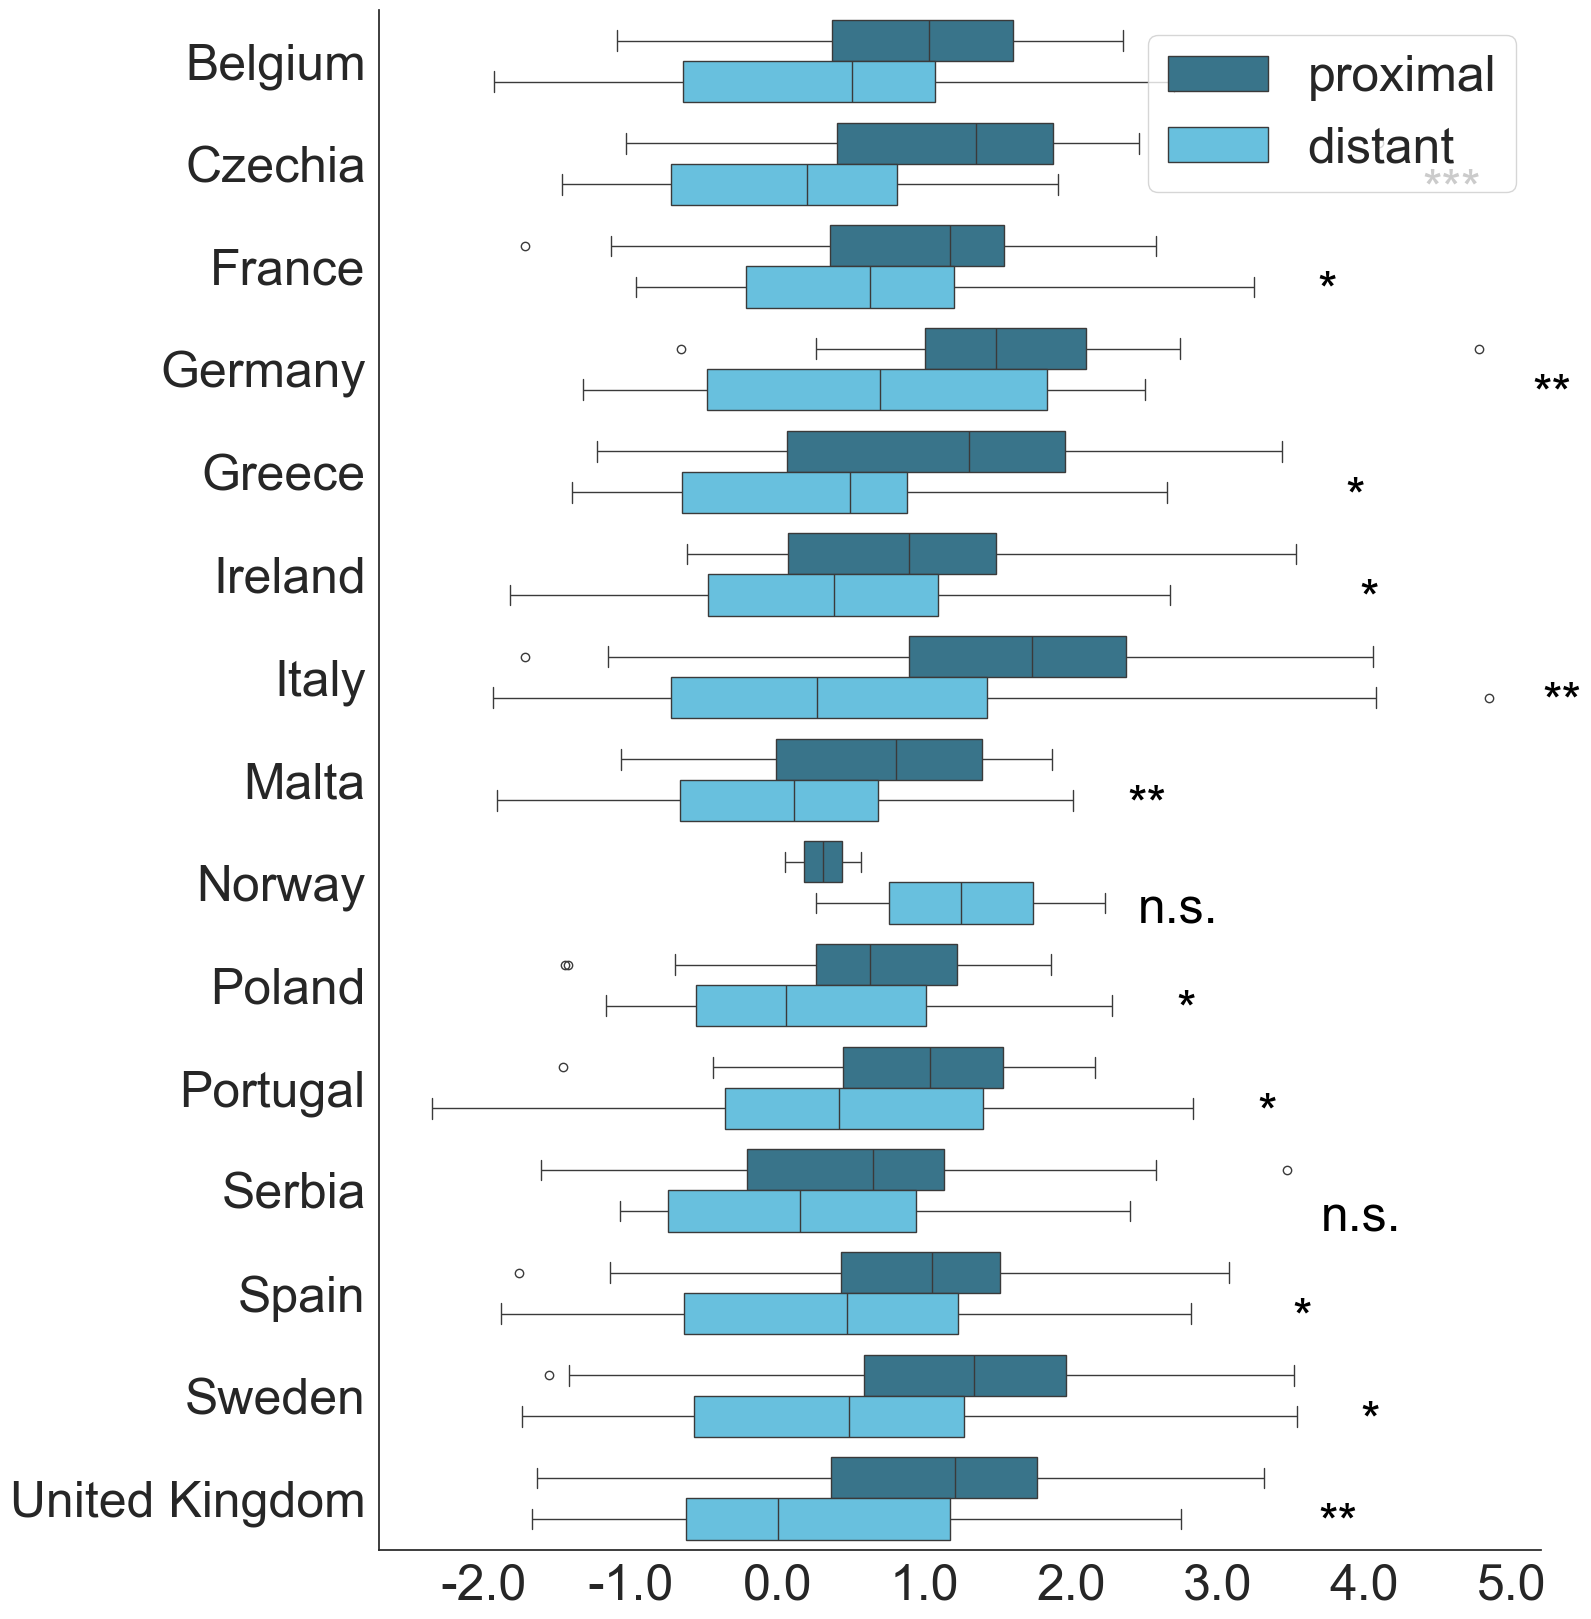

In [165]:
import scipy 
# Assuming your data loading and plot setup code here

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_high_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = [] 
locations = [] 
stars = [] 


for country in my_order:
    proximallist_cleaned = [x for x in water_high_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_high_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")

for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.4  
    xloc = max(water_pollution_high_zscore_df[water_pollution_high_zscore_df['location'] == loc]['z-score']) + 0.5  
  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')
#plt.savefig('output/Figures/SD11D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()


In [175]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_high_zscore_df.to_excel(
        writer,
        sheet_name="SF17D",
        index=False
    )

In [167]:
#Prevalence

water_country_proximal_zscore_dict={}
for country,dis_dict in water_high_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_prevalence[dis])
        std = np.std(proximal_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_high_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_prevalence[dis])
        std = np.std(distant_dis_prevalence[dis])
        z = (country_dis_prevalence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.5083889483842371 0.21640588510437014 0.039
Italy 1.8427978419023476 0.8880926359169814 0.0031
Spain 1.1046319004496108 0.65609784686149 0.0114
Germany 1.846014019673874 0.9695269148402205 0.0243
Greece 1.086330413039301 0.27211966370247237 0.0051
Belgium 0.9408575735648079 0.3876265823669672 0.0236
Czechia 1.2355042597986647 0.35393675173594225 0.0016
United Kingdom 1.1605774329385474 0.36898877383298206 0.002
Malta 0.6768977947142182 0.40937893109702816 0.0773
France 0.9194427698840192 0.5667177963642793 0.0506
Ireland 0.848547982208661 0.25947696717027474 0.0122
Portugal 0.830368551068661 0.5451120911855672 0.1617
Norway 0.5679343154519235 0.3385577120759547 0.3214
Poland 0.6731528553589949 0.21684436644894184 0.009
Sweden 1.2816688346214984 0.5513038087864863 0.0188


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2873918245.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_prevalence[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/2873918245.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_prevalence[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD12F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [168]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF18B_part3",
        index=False
    )

In [169]:
#mortality

water_country_proximal_zscore_dict={}
for country,dis_dict in water_high_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_mortality[dis])
        std = np.std(proximal_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_high_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_mortality[dis])
        std = np.std(distant_dis_mortality[dis])
        z = (country_dis_mortality[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.8825803007707497 0.39771097677230377 0.0382
Italy 1.214627511291155 0.48823775236932365 0.0092
Spain 0.8704641003874048 0.31102782204364754 0.0094
Germany 1.4136241639927811 0.7698714313250384 0.0071
Greece 0.9011026134701002 -0.16632288112975777 0.0045
Belgium 0.9911315691986936 0.19699631040191684 0.0069
Czechia 1.189434377791505 0.020320819706358833 0.0001
United Kingdom 1.0632962854309609 0.27906800587381114 0.0119
Malta 0.5666194588523698 0.06982670877641123 0.0135
France 0.8671356775788837 0.8823315536917788 0.2239
Ireland 0.4551463576090962 -0.23886818641765872 0.0071
Portugal 1.0777700695358359 0.6491147109170241 0.0145
Norway -0.288857486009954 0.574674092229491 0.6
Poland 0.9904446535198751 0.23233022250659716 0.0066
Sweden 1.2861038382289864 0.06812793063252157 0.0195


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/861311232.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/861311232.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_mortality[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD13F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [170]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF19B_part3",
        index=False
    )

In [171]:
#daly

water_country_proximal_zscore_dict={}
for country,dis_dict in water_high_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_daly[dis])
        std = np.std(proximal_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list


water_country_distant_zscore_dict={}
for country,dis_dict in new_high_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_daly[dis])
        std = np.std(distant_dis_daly[dis])
        z = (country_dis_DALYs[country][dis]-mu)/std
        country_distant_zscore_list.append(z)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list

water_pollution_zscore_df = pd.DataFrame()
selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

for country in water_country_proximal_zscore_dict.keys():
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))

Serbia 0.6977087037639002 0.06588202532959972 0.0035
Italy 0.9883774863260999 0.72844393133561 0.0459
Spain 0.6699275696700584 0.6334495636406966 0.2408
Germany 1.009245107460436 0.6336695293822845 0.0343
Greece 0.8151366615596594 0.13220554409545687 0.0119
Belgium 0.6650532291372455 0.20548432103627484 0.0164
Czechia 1.1542142138238844 -0.028434384280918622 0.0
United Kingdom 0.8893797017602135 0.25089727598385897 0.0054
Malta 0.40069319162909356 0.042711591539208095 0.029
France 0.538630383774866 0.4931561899518672 0.358
Ireland 0.45393172367734025 0.031391651791563294 0.0252
Portugal 0.8323843988531888 0.4092453660790375 0.0388
Norway -0.5636076880433261 0.3922714230155351 0.8333
Poland 0.8526783289158915 0.03089484348365896 0.0005
Sweden 0.8356215188648345 0.34632547030197597 0.0809


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/4039902182.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_76449/4039902182.py:22: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_DALYs[country][dis]-mu)/std


In [ ]:

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["#2B7A98", "#54CAF2"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

plt.savefig('output/Figures/SD14F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [172]:
# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    water_pollution_zscore_df.to_excel(
        writer,
        sheet_name="SF20B_part3",
        index=False
    )